In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
import torch.optim as optim
import tqdm as tq

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
n=1000
training_examples=50000
cv_examples=5000
testing_examples=5000

class Net_NHL(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(n+1,1)
  
  def forward(self, X):
    return self.fc(X)

class Net_1HL(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(n+1,n//2)
    self.fc1=nn.Linear(n//2,1)
  
  def forward(self, X):
    Op_1=F.relu(self.fc(X))
    Op_2=self.fc1(Op_1)
    return Op_2

class Net_2HL(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(n+1,n//2)
    self.fc1=nn.Linear(n//2,n//4)
    self.fc2=nn.Linear(n//4,1)
  
  def forward(self, X):
    Op_1=F.relu(self.fc(X))
    Op_2=F.relu(self.fc1(Op_1))
    Op_3=self.fc2(Op_2)
    return Op_3


In [3]:
def generate_dataset(examples,n,_type):
  if(_type=='uniform'):
    train = np.random.rand(examples,n)
  elif(_type=='normal'):
    train = np.random.normal(loc=0,scale=1,size=(examples,n))
  elif(_type=='exponential'):
    train=np.random.exponential(scale=np.random.randint(1,5),size=(examples,n))
  
  train.sort()
  search = np.random.randint(0,n,examples)
  val = train[np.arange(len(train)), search]
  final_train= np.c_[train,val]
  final_train=final_train.astype("float32")
  mini=np.amin(final_train,axis = 1).reshape(examples,1)
  maxi=np.amax(final_train,axis = 1).reshape(examples,1)
  final_train=(final_train-mini)/(maxi-mini)

  final_train_ans=search/n
  final_train_ans=final_train_ans.astype("float32")

  train_input= torch.from_numpy(final_train)
  train_ans = torch.from_numpy(final_train_ans)
  train_input = train_input.to('cuda')
  train_ans = train_ans.to('cuda')


  return train_input,train_ans

def train_dataset(net,train_input,train_ans,cv_input,cv_ans,examples,lr=1e-2,batch_size=5000,epochs=1000):
  optimizer = optim.Adam(net.parameters(),lr =lr)
  train_loss = []
  cv_loss = []

  for e in tq.tqdm(range(epochs)):
    epoch_loss = 0
    for b in range(int(examples/batch_size)):
      
      x = train_input[b*batch_size:(b+1)*batch_size]
      y = train_ans[b*batch_size:(b+1)*batch_size]
      out = net(x.view(-1,n+1))
      loss= F.mse_loss(out.view(-1),y)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    epoch_loss = epoch_loss/int(examples/batch_size)
    train_loss.append(epoch_loss)  
    print(epoch_loss)

    out = net(cv_input.view(-1,n+1))
    loss= F.mse_loss(out.view(-1),cv_ans)
    cv_loss.append(loss.item())

  plt.plot(np.arange(epochs),train_loss,label = 'Train')
  plt.plot(np.arange(epochs),cv_loss,label = 'Cross Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Average Epoch MSE Loss')
  plt.legend()
  plt.title('Loss vs Epochs')
  plt.show()


In [4]:
def binary_search(arr, l, r,x,cnt=0):
  # arr = list(arr)
  if r >= l:
        mid = l + int(np.floor((r - l)/ 2))
        if arr[mid] == x:
            return mid,cnt+1
        elif arr[mid] > x:
            return binary_search(arr, l, mid-1, x,cnt+1)
        else:
            return binary_search(arr, mid + 1, r, x,cnt+1)
  else:
        return r,cnt

def predict(net,test_input,n):
  out=net(test_input.view(-1,n+1))
  out=out*n
  return out

def get_predictions(test_input,n,examples,out):
  predictions_cnt = []
  bs_cnt = []
  for i in range(examples):
    bs_cnt.append(binary_search(test_input[i],0,n-1,test_input[i][n])[1])
    idx = int(out[i]) #predicted index
    if(idx>=n):
      idx = n-1
    if(idx<0):
      idx = 0
    
    if(test_input[i][idx] > test_input[i][n]):
      sub = 2
      cnt = 1
      while idx-sub >= 0:
        cnt+=1
        if(test_input[i][idx-sub] < test_input[i][n]):
          break;
        sub*= 2
      left = max(idx-sub,0)
      right = idx-(sub//2)
      predictions_cnt.append(binary_search(test_input[i],left,right,test_input[i][n],cnt)[1])
      
    elif (test_input[i][idx] < test_input[i][n]):
      sub = 2
      cnt = 1
      while idx+sub <= n-1:
        cnt+=1
        if(test_input[i][idx+sub] > test_input[i][n]):
          break;
        sub*= 2
      left = idx+(sub//2)
      right = min(idx+sub,n-1)
      predictions_cnt.append(binary_search(test_input[i],left,right,test_input[i][n],cnt)[1])
    else:
      predictions_cnt.append(1)
    
  return predictions_cnt,bs_cnt

In [5]:
def test_single_array(net,n,_type):
  np.random.seed(64)
  if(_type=='normal'):
    testing = np.random.normal(loc=0,scale=1,size=n)
  elif(_type=='uniform'):
    testing = np.random.rand(n)
  elif(_type=='exponential'):
    testing=np.random.exponential(scale=np.random.randint(1,5),size=n)

  testing.sort()
  testing=(testing-testing[0])/(testing[n-1]-testing[0])
  
  L=[]
  for i in range(n):
    test_val = testing[i]
    test = np.append(testing,test_val)
    test = test.astype('float32')
    test_input = torch.from_numpy(test)
    test_input = test_input.to("cuda")
    out = net(test_input.view(-1, n+1))
    L.append(out.item()*n)
  
  plt.scatter(np.arange(n),testing)
  plt.title('Test Array')
  plt.xlabel('Index')
  plt.ylabel('Test Array Value')
  plt.show()
  plt.scatter(np.arange(n),L)
  plt.title('Predicted Index for each element')
  plt.xlabel('Index')
  plt.ylabel('Predicted Index')
  plt.show()
    

In [6]:
def generate_plots(predictions_cnt,bs_cnt):
  unique1, counts1 = np.unique(predictions_cnt, return_counts=True)
  d1  = dict(zip(unique1, counts1))
  unique2, counts2 = np.unique(bs_cnt, return_counts=True)
  d2  = dict(zip(unique2, counts2))
  plt.plot(list(d1.keys()),list(d1.values()),label = 'Predictor')
  plt.plot(list(d2.keys()),list(d2.values()),label = 'Binary Search')
  plt.xlabel('Number of Array Lookups(Steps)')
  plt.ylabel('Count of Test Inputs')
  plt.legend()
  plt.show()

  return d1,d2

def average_steps(d1,d2):
  print('Average Number of Steps')
  s=0
  for i in d1:
    s+=d1[i]*i
  print('Through Predictor:'+str(s/testing_examples))
  s=0
  for i in d2:
    s+=d2[i]*i
  print('Through Binary Search:'+str(s/testing_examples))


#Uniform


 15%|█▍        | 22/150 [00:00<00:01, 106.02it/s]

4.297218585014344
1.1669159397482871
0.46963898465037346
0.220521991699934
0.12161235213279724
0.08821935504674912
0.07609911486506463
0.06784795671701431
0.06435500755906105
0.06091156154870987
0.05799184814095497
0.055393606424331665
0.05269341394305229
0.05010426379740238
0.04752344712615013
0.04500774070620537
0.04252983368933201
0.04012961015105247
0.037785318493843076
0.03552177213132381
0.03333609886467457
0.03123074285686016


 22%|██▏       | 33/150 [00:00<00:01, 100.25it/s]

0.02921181693673134
0.02728015650063753
0.025436375848948957
0.023681559972465037
0.022016014344990252
0.020439256355166434
0.018950380571186542
0.0175480792298913
0.016230564378201962
0.01499540898948908
0.013839343562722206
0.012757966667413712
0.01174553856253624
0.010795110650360585
0.009899337403476238
0.009052187111228705
0.008250797912478448
0.007496173959225416
0.006792028155177832
0.0061427861452102665
0.005551924044266343


 37%|███▋      | 55/150 [00:00<00:00, 102.04it/s]

0.005019644182175398
0.0045406526885926725
0.004106065351516008
0.0037086209282279014
0.003345037065446377
0.0030140179209411145
0.002713551954366267
0.0024408185156062244
0.002193476143293083
0.0019696740084327756
0.0017674791975878178
0.0015850400435738266
0.0014207133208401501
0.0012729268986731769
0.00114022163907066
0.001021249231416732
0.0009147519012913108
0.0008195740927476435
0.0007346443133428692
0.0006589759548660367
0.0005916633468586952
0.0005318771407473832


 51%|█████▏    | 77/150 [00:00<00:00, 101.18it/s]

0.0004788561112945899
0.00043190846045035867
0.0003904005046933889
0.00035375735315028577
0.00032145637378562243
0.00029302670736797154
0.00026804145309142766
0.0002461146141286008
0.00022689960314892232
0.00021008562471251934
0.00019539229106158018
0.0001825706087402068
0.00017139695555670186
0.00016167293797479941
0.00015322139515774324
0.00014588529302272946
0.00013952506560599431
0.00013401761971181257
0.00012925443734275178
0.00012513982510427014
0.00012158944809925742


 66%|██████▌   | 99/150 [00:00<00:00, 102.10it/s]

0.00011852955358335749
0.00011589512068894691
0.00011362893637851812
0.0001116801329771988
0.00011000292652170174
0.00010855601503862999
0.00010730193971539848
0.00010620769753586501
0.00010524548561079428
0.0001043933632900007
0.00010363406399847009
0.00010295674073859117
0.00010235834197374061
0.00010184130296693183
0.00010140328158740886
0.0001010304520605132
0.00010070377174997702
0.00010041013010777533
0.0001001461387204472
9.991044062189758e-05
9.96980961645022e-05
9.950421008397825e-05


 81%|████████  | 121/150 [00:01<00:00, 104.36it/s]

9.932690591085702e-05
9.916388662531972e-05
9.901291996357031e-05
9.887236083159224e-05
9.8741015244741e-05
9.861755388556049e-05
9.850129936239682e-05
9.839126141741872e-05
9.828724942053668e-05
9.818839535000735e-05
9.809488983592018e-05
9.800653206184506e-05
9.792314958758652e-05
9.78455376753118e-05
9.777382074389606e-05
9.770924880285748e-05
9.76530383923091e-05
9.760742614162154e-05
9.757548468769528e-05
9.756182917044497e-05
9.757315274327993e-05
9.761987021192909e-05


100%|██████████| 150/150 [00:01<00:00, 102.46it/s]

9.77163166680839e-05
9.788104434846901e-05
9.813653159653767e-05
9.84938298643101e-05
9.891750669339671e-05
9.926595594151877e-05
9.929370717145502e-05
9.884319733828306e-05
9.806297384784557e-05
9.720715461298823e-05
9.662485172157176e-05
9.658155104261824e-05
9.658597991801798e-05
9.643401499488391e-05
9.64585182373412e-05
9.649254352552816e-05
9.6751067758305e-05
9.751152174430899e-05
0.00010096184705616906
0.0001265258477360476


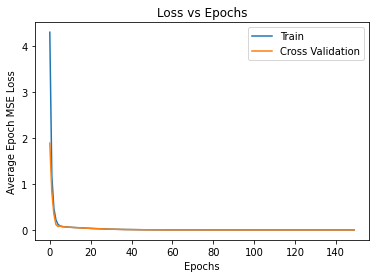

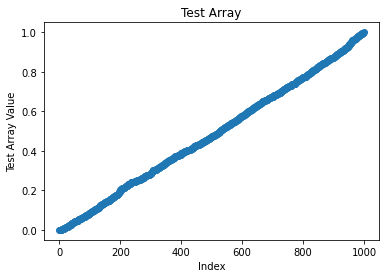

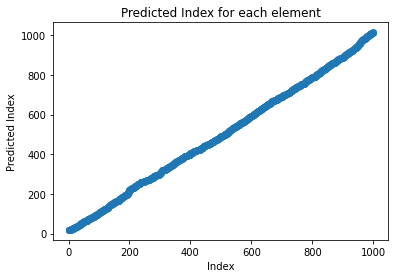

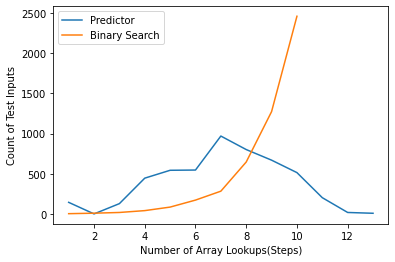

Average Number of Steps
Through Predictor:7.0568
Through Binary Search:8.9914
Predictor MSE Loss : 336754.84375


In [61]:
net=Net_NHL()
net.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='uniform')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='uniform')
train_dataset(net,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=150,lr=1e-2)
test_single_array(net,n,'uniform')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='uniform')
out=predict(net,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)
#print('Predictor MSE Loss : '+ str((F.mse_loss(out.view(-1),test_ans)).item()))



  2%|▏         | 4/200 [00:00<00:09, 19.85it/s]

0.7974979482591152
0.15107938051223754
0.0996011145412922
0.08623932525515557


  6%|▌         | 11/200 [00:00<00:07, 26.98it/s]

0.08557846769690514
0.08330544233322143
0.08324180915951729
0.08281832337379455
0.08268506899476051
0.08255233466625214
0.08241427019238472


  8%|▊         | 15/200 [00:00<00:06, 29.29it/s]

0.08228058144450187
0.08214436322450638
0.08200051560997963
0.08185159042477608
0.08169723525643349
0.0815360613167286
0.08136867731809616


 12%|█▏        | 23/200 [00:00<00:05, 31.31it/s]

0.08119432106614113
0.08101258352398873
0.0808230459690094
0.08062498643994331
0.08041778653860092
0.08020061627030373
0.07997258901596069


 16%|█▌        | 31/200 [00:01<00:05, 32.13it/s]

0.07973269447684288
0.07947980239987373
0.07921265140175819
0.07892983704805374
0.07862981408834457
0.07831085920333862
0.0779710866510868


 20%|█▉        | 39/200 [00:01<00:04, 32.27it/s]

0.07760843709111213
0.07722065895795822
0.07680530622601509
0.07635974511504173
0.07588115185499192
0.07536650374531746
0.07481261864304542


 22%|██▏       | 43/200 [00:01<00:04, 32.22it/s]

0.07421614751219749
0.07357358783483506
0.07288133949041367
0.07213572263717652
0.07133300974965096
0.07046949490904808
0.06954155564308166


 26%|██▌       | 51/200 [00:01<00:04, 32.74it/s]

0.06854571178555488
0.06747871711850166
0.06633771359920501
0.06512026861310005
0.0638244852423668
0.0624487143009901
0.0609907791018486


 30%|██▉       | 59/200 [00:01<00:04, 32.63it/s]

0.05944671109318733
0.057811681926250455
0.05608597993850708
0.05427366197109222
0.05237496942281723
0.050405049324035646
0.04837365746498108


 34%|███▎      | 67/200 [00:02<00:04, 32.65it/s]

0.046289780735969545
0.044146019220352176
0.04196326732635498
0.03975087031722069
0.037518051266670224
0.03528732843697071
0.033088193461298945


 36%|███▌      | 71/200 [00:02<00:03, 32.63it/s]

0.03094271048903465
0.02887284830212593
0.02681018356233835
0.024639920704066752
0.022399371303617955
0.020211813040077686
0.018325989507138728


 40%|███▉      | 79/200 [00:02<00:03, 32.68it/s]

0.016489468142390253
0.014787536673247814
0.013177839573472738
0.01168628977611661
0.010317893419414758
0.009073195047676563
0.007933204481378197


 44%|████▎     | 87/200 [00:02<00:03, 32.94it/s]

0.006862250389531255
0.005898955790325999
0.005066796252503991
0.004325779294595123
0.0036775489803403615
0.0031223072903230785
0.002652939176186919


 48%|████▊     | 95/200 [00:03<00:03, 33.00it/s]

0.0022722893161699178
0.0018855639616958797
0.0019723137258552013
0.0019148228224366904
0.0011381314950995147
0.0020268689026124776
0.0010273121704813093


 50%|████▉     | 99/200 [00:03<00:03, 32.76it/s]

0.0009036619099788368
0.0008378279104363173
0.00044514498440548775
0.001176184305222705
0.0009777204075362533
0.0005117576831253246
0.0004904305096715689


 54%|█████▎    | 107/200 [00:03<00:02, 32.74it/s]

0.0002218484369223006
0.0002003833040362224
0.000833597540622577
0.0005767031092545949
0.00037308762111933904
0.00026137297827517615
0.0003379150599357672


 57%|█████▊    | 115/200 [00:03<00:02, 32.81it/s]

0.0001597940325154923
0.0002150530053768307
0.00092098179156892
0.0003204328430001624
0.0002309599643922411
0.00017691214743535965
0.000292662886204198


 62%|██████▏   | 123/200 [00:03<00:02, 32.78it/s]

0.00036982292658649385
0.0003217459860024974
0.00020805748936254532
0.0002995573246153072
0.000753445626469329
0.00022314998059300706
0.00031712561467429624


 64%|██████▎   | 127/200 [00:03<00:02, 32.67it/s]

0.0001217790151713416
0.00010260426861350425
0.00019343886524438857
0.0013036786927841603
0.00040011788078118113
0.0002783664291200694
0.00014233771435101517


 68%|██████▊   | 135/200 [00:04<00:02, 32.48it/s]

0.00013216238512541166
0.000134837504447205
0.00030497111001750456
0.0005593909794697538
0.00016080216446425765
0.00017136696842499078
0.00042543416784610597


 72%|███████▏  | 143/200 [00:04<00:01, 32.43it/s]

0.0005834399082232267
0.00017183112067868932
0.0003836418181890622
0.00022327764454530553
0.00012830261985072867
0.0002849610391422175
0.0009682838921435177


 76%|███████▌  | 151/200 [00:04<00:01, 32.49it/s]

0.00026293384580640123
0.00018459042694303208
0.00023390168644255027
0.00025983202940551566
0.00022221127874217929
0.0003503474013996311
0.0005210848175920546


 78%|███████▊  | 155/200 [00:04<00:01, 32.47it/s]

0.0001630609534913674
0.00011790061762440018
0.0002703577687498182
0.0009825979999732227
0.0002940837308415212
0.00021067897396278567
0.0001438616258383263


 82%|████████▏ | 163/200 [00:05<00:01, 32.56it/s]

0.00015054447285365314
0.00017812325386330486
0.0006696224561892449
0.0005536273587495088
0.00034404366160742936
0.00013480127017828636
0.00013527391711249949


 86%|████████▌ | 171/200 [00:05<00:00, 32.68it/s]

0.000183197547448799
0.0005505819775862619
0.0005808666341181379
0.00025747777472133747
0.00025227839651051907
0.00010431373884784989
0.00010082074513775296


 90%|████████▉ | 179/200 [00:05<00:00, 32.75it/s]

0.000273338588885963
0.0012652159755816683
0.0003907580001396127
0.0002298634484759532
0.00014825018297415227
0.00012760012177750468
0.00010065281676361338


 92%|█████████▏| 183/200 [00:05<00:00, 32.81it/s]

0.00012940458982484414
0.0006395015632733702
0.0006360669474815949
0.0002958961253170855
0.00013251512791612186
0.0002151796710677445
0.000404947335482575


 96%|█████████▌| 191/200 [00:05<00:00, 32.59it/s]

0.00032576759258517995
0.00014444505068240688
0.00015529499505646528
0.0006538520683534443
0.0005402545881224796
0.0002647066125064157
0.0001699338376056403


100%|██████████| 200/200 [00:06<00:00, 32.10it/s]

0.00012303272815188392
0.0004089551541255787
0.0006508166115963832
0.0001624740478291642
0.00028839481237810107
0.0001681489811744541
0.0001272623565455433


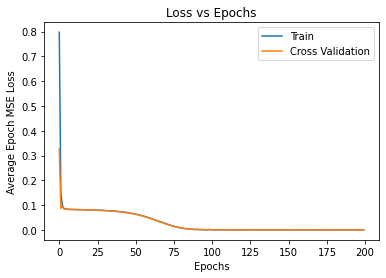

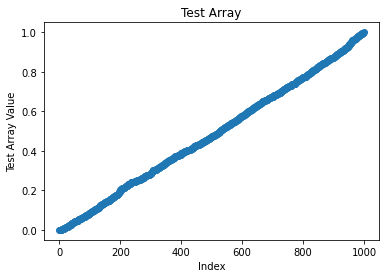

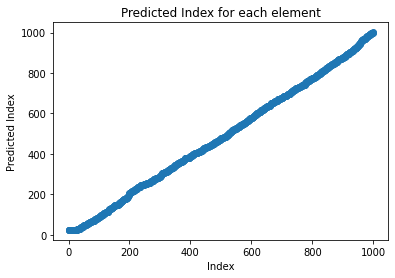

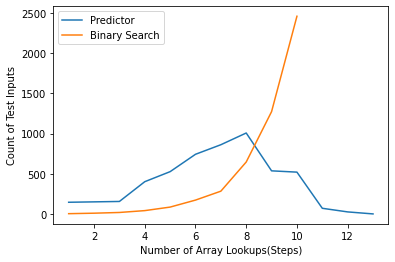

Average Number of Steps
Through Predictor:6.9124
Through Binary Search:8.9914
Predictor MSE Loss : 320144.40625


In [62]:
net_1=Net_1HL()
net_1.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='uniform')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='uniform')
train_dataset(net_1,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=200,lr=1e-3)
test_single_array(net_1,n,'uniform')

np.random.seed(42)
test_input,out=generate_dataset(testing_examples,n,_type='uniform')
out=predict(net_1,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

  1%|          | 2/200 [00:00<00:13, 14.81it/s]

0.16076173409819602
0.09273778349161148
0.08561159074306487


  4%|▎         | 7/200 [00:00<00:10, 18.70it/s]

0.08326573222875595
0.08244216442108154
0.08206524550914765
0.0817308023571968
0.0814543068408966


  6%|▋         | 13/200 [00:00<00:08, 21.83it/s]

0.08114480152726174
0.08083916381001473
0.08050504252314568
0.08014993816614151
0.0797726146876812


  8%|▊         | 16/200 [00:00<00:08, 22.55it/s]

0.0793639861047268
0.07892468199133873
0.07845164313912392
0.07793982177972794
0.0773853212594986


 11%|█         | 22/200 [00:01<00:07, 23.01it/s]

0.07677118107676506
0.07611295506358147
0.07539757043123245
0.07461270615458489
0.07374332696199418


 14%|█▍        | 28/200 [00:01<00:07, 23.24it/s]

0.07278753593564033
0.07173641473054886
0.07058427855372429
0.06933045536279678
0.0679750233888626


 16%|█▌        | 31/200 [00:01<00:07, 23.37it/s]

0.06647543683648109
0.06490103974938392
0.0632504504173994
0.06154240071773529
0.05976807810366154


 18%|█▊        | 37/200 [00:01<00:06, 23.69it/s]

0.05789587460458279
0.05589304305613041
0.053765004873275755
0.0515039324760437
0.04908588640391827


 22%|██▏       | 43/200 [00:01<00:06, 23.75it/s]

0.04647204503417015
0.04362759217619896
0.04058774039149284
0.037495773285627365
0.03470315411686897


 23%|██▎       | 46/200 [00:02<00:06, 23.65it/s]

0.031778314523398875
0.02890147566795349
0.026109532825648783
0.023198695667088032
0.020525875501334667


 26%|██▌       | 52/200 [00:02<00:06, 23.47it/s]

0.018412315286695957
0.01627605315297842
0.013519610092043877
0.011542910058051348
0.011827633529901505


 29%|██▉       | 58/200 [00:02<00:06, 23.25it/s]

0.009103589784353971
0.00716596394777298
0.005453652050346136
0.004238160443492234
0.0033880571834743025


 30%|███       | 61/200 [00:02<00:05, 23.37it/s]

0.0028375493129715323
0.004120344435796142
0.002225098863709718
0.0016341260634362698
0.0010079307132400573


 34%|███▎      | 67/200 [00:02<00:05, 23.67it/s]

0.00102439732872881
0.0007585052226204425
0.0018183910171501339
0.0006701342965243385
0.0005389789876062423


 36%|███▋      | 73/200 [00:03<00:05, 23.45it/s]

0.0003062452800804749
0.00024344179837498814
0.0012978990620467813
0.0005728560165152885
0.0002944242805824615


 38%|███▊      | 76/200 [00:03<00:05, 23.47it/s]

0.00020304292993387208
0.00014761909988010303
0.00020227522763889284
0.0004291481454856694
0.0007179978187195956


 41%|████      | 82/200 [00:03<00:05, 23.39it/s]

0.00027376374491723255
0.0001569288084283471
0.00012757510266965256
0.00027398334350436926
0.0009564288833644241


 44%|████▍     | 88/200 [00:03<00:04, 23.67it/s]

0.00026083542470587415
0.00020593808440025896
0.00013575158445746637
0.00011702196061378345
0.00037302692071534694


 46%|████▌     | 91/200 [00:03<00:04, 23.66it/s]

0.0009327281826699618
0.00027631908233161084
0.00019581228043534792
0.00013571286108344794
0.00018831582492566666


 48%|████▊     | 97/200 [00:04<00:04, 23.55it/s]

0.0004431991488672793
0.00028703962452709676
0.0001434628757124301
0.00013308227935340255
0.00017217066197190435


 52%|█████▏    | 103/200 [00:04<00:04, 23.40it/s]

0.001669367597787641
0.0005907301470870152
0.00034133144799852744
0.00014654216429335065
0.00014289070750237443


 53%|█████▎    | 106/200 [00:04<00:04, 23.41it/s]

0.00011333820220897906
0.00012866183096775784
0.00011078737370553426
0.0001468831738748122
0.0006878888118080795


 56%|█████▌    | 112/200 [00:04<00:03, 23.54it/s]

0.000519759905000683
0.00021681253565475345
0.0001763500549714081
0.00010765007173176854
0.00010329478609492072


 59%|█████▉    | 118/200 [00:05<00:03, 23.46it/s]

0.00033396428771084177
0.0014331367230624892
0.00046471659443341194
0.00020430980293895118
0.00017086394000216388


 60%|██████    | 121/200 [00:05<00:03, 23.43it/s]

0.00011320851190248505
0.0001253709415323101
0.00014914902712916955
0.0001855591428466141
0.0005964975745882839


 64%|██████▎   | 127/200 [00:05<00:03, 23.32it/s]

0.0004005059279734269
0.00018787013686960563
0.00019441610493231565
0.00040942773339338603
0.00022891948174219579


 66%|██████▋   | 133/200 [00:05<00:02, 23.35it/s]

0.00011066361112170853
0.00014567634934792295
0.000929687757161446
0.001000911772280233
0.0002841484973032493


 68%|██████▊   | 136/200 [00:05<00:02, 23.44it/s]

0.000205952933174558
0.0001327971891441848
0.00014800974386162125
0.00010166618958464823
0.00010098181592184119


 71%|███████   | 142/200 [00:06<00:02, 23.39it/s]

0.00028755687744705936
0.001255276266601868
0.00032315486896550283
0.00023703127953922376
0.0001445931877242401


 74%|███████▍  | 148/200 [00:06<00:02, 23.23it/s]

0.00014831878288532608
9.721733804326504e-05
0.00010082716107717715
0.0003143765876302496
0.0012343468464678154


 76%|███████▌  | 151/200 [00:06<00:02, 23.18it/s]

0.000323393005237449
0.000231304293993162
0.00014117461614659987
0.00014719311948283576
9.644084566389211e-05


 78%|███████▊  | 157/200 [00:06<00:01, 23.34it/s]

9.934250629157759e-05
0.0003017488714249339
0.0012824203455238602
0.0003322260447021108
0.00023753193381708114


 82%|████████▏ | 163/200 [00:07<00:01, 23.37it/s]

0.00014460735546890647
0.0001381993366521783
9.661059448262677e-05
0.00010178126103710383
0.00032969289168249816


 83%|████████▎ | 166/200 [00:07<00:01, 23.35it/s]

0.0010850371822016315
0.0002822937574819662
0.00022031907428754494
0.00012877144399681129
0.00013828293740516528


 86%|████████▌ | 172/200 [00:07<00:01, 23.53it/s]

0.0001755019315169193
0.00021220277703832836
0.0005486673617269844
0.00035531024041119964
0.0001720673084491864


 89%|████████▉ | 178/200 [00:07<00:00, 23.45it/s]

0.00010955059042316861
0.00040999666816787794
0.0007897118841356133
0.00023645133696845733
0.00021958303623250685


 90%|█████████ | 181/200 [00:07<00:00, 23.43it/s]

0.00011110196937806905
9.826624227571301e-05
0.00010257967078359797
0.0008011611149413511
0.0013232436307589524


 94%|█████████▎| 187/200 [00:08<00:00, 23.47it/s]

0.0003725651753484271
0.00017346146996715105
0.00015022734951344318
0.0001077225650078617
0.00011326827661832795


 96%|█████████▋| 193/200 [00:08<00:00, 23.62it/s]

9.348172607133165e-05
0.00010817414222401567
0.00040896935388445854
0.0008413405354076531
0.00024717459964449515


 98%|█████████▊| 196/200 [00:08<00:00, 23.38it/s]

0.00021478433554875665
0.0001059697606251575
9.912429304677061e-05
0.0001597701157152187
0.0008066790032899007


100%|██████████| 200/200 [00:08<00:00, 23.19it/s]


0.00040922893458628096
0.00019341994629940018


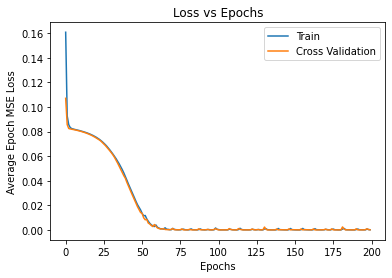

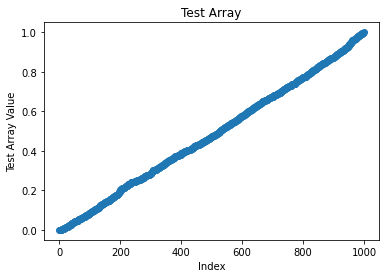

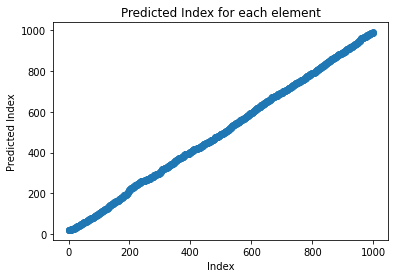

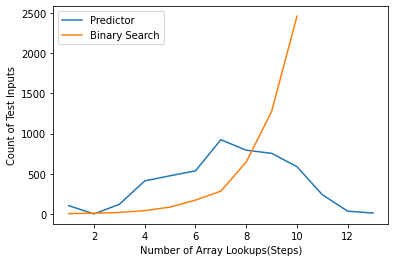

Average Number of Steps
Through Predictor:7.288
Through Binary Search:8.9914
Predictor MSE Loss : 338083.9375


In [63]:
net_2=Net_2HL()
net_2.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='uniform')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='uniform')
train_dataset(net_2,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=200,lr=1e-4)
test_single_array(net_2,n,'uniform')

np.random.seed(42)
test_input,out=generate_dataset(testing_examples,n,_type='uniform')
out=predict(net_2,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

#Normal


  2%|▏         | 22/1000 [00:00<00:09, 106.52it/s]

0.14124646186828613
0.09845067411661149
0.08914524763822555
0.08625573664903641
0.0847819410264492
0.08373136222362518
0.08285568282008171
0.08208592310547828
0.0813882365822792
0.08073958605527878
0.08010513857007026
0.07945135235786438
0.0787922278046608
0.07813888117671013
0.07748235911130905
0.07682518661022186
0.07616962715983391
0.07551358640193939
0.07485919967293739
0.07420543730258941
0.07355329915881156
0.07290250808000565


  4%|▍         | 44/1000 [00:00<00:09, 104.35it/s]

0.0722535066306591
0.07160643562674522
0.07096149921417236
0.07031899690628052
0.0696791686117649
0.06904230490326882
0.06840875297784806
0.06777884513139724
0.06715298146009445
0.0665315866470337
0.06591512113809586
0.06530408412218094
0.06469898968935013
0.0641003742814064
0.0635087426751852
0.06292451918125153
0.062348001077771185
0.06177926547825337
0.0612180694937706
0.060663802921772
0.060115428641438484
0.05957148224115372


  7%|▋         | 66/1000 [00:00<00:08, 106.39it/s]

0.05903018712997436
0.058489584177732465
0.057947741076350215
0.05740292258560657
0.05685377605259419
0.05629940144717693
0.055739393830299376
0.05517377704381943
0.054602949693799016
0.05402760282158851
0.05344862751662731
0.052867072820663455
0.05228411443531513
0.05170108042657375
0.0511194221675396
0.05054077468812466
0.04996687322854996
0.04939947798848152
0.048840175941586496
0.04829015806317329
0.04775001108646393
0.04721961095929146
0.04669824950397015


  9%|▉         | 88/1000 [00:00<00:08, 105.25it/s]

0.0461849007755518
0.045678581669926645
0.045178553089499474
0.04468436352908611
0.044195720553398134
0.04371233806014061
0.04323397278785705
0.042760399356484416
0.042291457578539846
0.041827020421624186
0.041366982832551004
0.04091123528778553
0.040459709241986275
0.040012337267398834
0.039569060504436496
0.039129826799035074
0.03869459219276905
0.038263320177793506
0.03783598020672798
0.03741253986954689
0.03699296042323112
0.03657722473144531


 11%|█         | 110/1000 [00:01<00:08, 103.49it/s]

0.036165300756692886
0.03575718104839325
0.035352836921811105
0.03495224602520466
0.03455538898706436
0.034162255749106404
0.033772822842001914
0.03338708281517029
0.033005012199282646
0.032626597210764885
0.032251829653978346
0.031880691275000574
0.03151317536830902
0.03114926815032959
0.030788945965468884
0.03043221402913332
0.030079053528606892
0.029729464650154115
0.029383439011871813
0.029040964879095556
0.0287020493298769


 13%|█▎        | 132/1000 [00:01<00:08, 103.89it/s]

0.02836668100208044
0.02803486455231905
0.027706604078412057
0.027381902933120726
0.027060770988464357
0.026743215695023536
0.026429258286952972
0.02611891459673643
0.025812211632728576
0.025509172677993776
0.025209824182093145
0.024914203397929668
0.02462234515696764
0.024334278889000416
0.024050038307905197
0.023769631423056124
0.023493068292737007
0.023220319487154483
0.02295135110616684
0.022686073929071425
0.02242436707019806
0.022166061215102673


 15%|█▌        | 154/1000 [00:01<00:08, 103.49it/s]

0.02191094160079956
0.021658757328987123
0.021409225277602674
0.021162042580544948
0.0209169028326869
0.020673517882823945
0.02043163124471903
0.02019101455807686
0.01995150577276945
0.019712965190410613
0.019475316815078258
0.019238506630063056
0.019002531096339224
0.018767396174371242
0.018533125147223474
0.018299775570631026
0.018067433312535287
0.01783626340329647
0.017606497369706632
0.01737847048789263
0.01715266741812229
0.016929681599140167


 18%|█▊        | 176/1000 [00:01<00:07, 105.02it/s]

0.016710152104496955
0.016494706459343433
0.016283811628818513
0.01607762984931469
0.01587600791826844
0.01567855142056942
0.015484775882214308
0.015294285956770182
0.015106831025332213
0.014922293648123742
0.01474057398736477
0.014561572577804327
0.014385202527046203
0.014211389422416686
0.01404008325189352
0.01387123977765441
0.013704817369580269
0.013540783617645501
0.01337910108268261
0.013219758681952954
0.013062729686498641
0.012908001150935888


 20%|█▉        | 198/1000 [00:01<00:07, 104.11it/s]

0.012755559105426074
0.012605389580130577
0.012457477487623691
0.012311824597418308
0.012168426252901553
0.012027283292263746
0.011888397391885519
0.011751773301512003
0.011617428250610828
0.011485377792268991
0.01135562825948
0.011228200793266297
0.011103116627782583
0.010980401188135147
0.010860074963420629
0.010742147266864777
0.010626635979861021
0.01051353570073843
0.010402829106897115
0.010294466372579336
0.01018838407471776
0.010084476973861455


 22%|██▏       | 220/1000 [00:02<00:07, 104.68it/s]

0.009982618689537048
0.009882645960897208
0.009784348774701357
0.00968752671033144
0.009591992013156414
0.009497551526874305
0.00940404636785388
0.00931137204170227
0.0092194733209908
0.009128335956484079
0.009037991520017385
0.00894848071038723
0.008859874494373799
0.008772250451147556
0.008685677498579025
0.008600213658064603
0.008515914436429739
0.008432828821241856
0.008350988011807203
0.008270415384322405
0.008191120531409978
0.008113115467131138


 24%|██▍       | 242/1000 [00:02<00:07, 105.03it/s]

0.008036403683945537
0.007960994355380535
0.00788687840104103
0.007814044039696455
0.007742476696148515
0.007672176137566567
0.007603122666478157
0.007535315817221999
0.007468733144924045
0.007403356768190861
0.0073391734156757595
0.0072761734016239645
0.007214338751509786
0.007153654983267188
0.007094100303947926
0.0070356606040149925
0.006978321028873325
0.006922071240842343
0.0068668977357447146
0.006812775274738669
0.006759688491001725
0.006707630539312959


 26%|██▋       | 264/1000 [00:02<00:06, 105.35it/s]

0.006656591081991792
0.006606542691588402
0.0065574646461755036
0.00650936053134501
0.006462205480784178
0.00641599870286882
0.006370707182213664
0.006326326355338097
0.006282833265140652
0.00624021659605205
0.006198473460972309
0.006157593475654722
0.006117550656199455
0.006078324746340513
0.006039913184940815
0.006002297578379512
0.005965469917282462
0.005929419491440058
0.005894135031849146
0.005859594605863094
0.005825780890882015
0.005792694725096225


 28%|██▊       | 275/1000 [00:02<00:06, 104.01it/s]

0.005760323302820325
0.005728652235120535
0.005697670159861445
0.005667355703189969
0.005637708818539977
0.0056087156292051075
0.005580353876575827
0.005552622023969889
0.005525519698858261
0.005499018775299192
0.0054731124080717565
0.005447782063856721
0.0054230431094765665
0.005398863926529884
0.00537523846141994
0.005352141615003347
0.005329586286097765
0.00530755608342588
0.0052860393188893795
0.005265025701373815
0.005244508525356651


 30%|██▉       | 297/1000 [00:02<00:06, 104.73it/s]

0.005224472610279918
0.005204908968880773
0.005185807356610894
0.005167167633771896
0.005148975132033229
0.005131221283227206
0.005113896448165178
0.00509699247777462
0.0050804995000362395
0.0050644115544855595
0.005048713553696871
0.005033407639712095
0.0050184799823909994
0.0050039272755384445
0.004989739507436752
0.004975901078432798
0.00496240989305079
0.0049492633435875176
0.00493645672686398
0.00492397379130125
0.0049118076916784045
0.004899953352287411


 32%|███▏      | 319/1000 [00:03<00:06, 104.85it/s]

0.004888401133939624
0.0048771487083286045
0.004866195563226938
0.004855522932484746
0.004845131142064929
0.004835010459646583
0.004825151013210416
0.004815555457025766
0.0048062197864055635
0.004797135200351477
0.004788285261020065
0.004779671365395188
0.0047712866216897964
0.004763134475797415
0.004755206126719713
0.004747490864247084
0.004739980632439256
0.004732670821249485
0.004725568555295467
0.004718663776293397
0.0047119478695094585
0.004705410450696945


 34%|███▍      | 341/1000 [00:03<00:06, 104.65it/s]

0.004699057014659047
0.004692884860560298
0.004686879925429821
0.004681047238409519
0.004675375996157527
0.0046698665246367455
0.004664504621177912
0.004659295780584216
0.004654237860813737
0.004649320337921381
0.004644542513415217
0.004639901733025908
0.004635391570627689
0.00463100983761251
0.004626754252240062
0.004622624348849058
0.004618608672171831
0.004614709177985787
0.004610922234132886
0.004607244580984116
0.0046036768238991495
0.004600210068747401


 36%|███▋      | 363/1000 [00:03<00:06, 106.13it/s]

0.004596842220053077
0.004593574348837138
0.004590398212894797
0.004587314324453473
0.004584322497248649
0.004581420123577118
0.004578599147498608
0.0045758550055325035
0.0045731956604868175
0.00457061636261642
0.004568111291155219
0.00456567439250648
0.0045633114408701655
0.004561020759865642
0.0045587947126477955
0.004556629620492458
0.004554527485743165
0.004552496178075671
0.004550516745075584
0.004548590397462249
0.004546726541593671
0.004544913256540895


 38%|███▊      | 385/1000 [00:03<00:05, 103.92it/s]

0.004543155618011952
0.00454145073890686
0.004539789445698261
0.004538172762840987
0.004536602413281798
0.004535080911591649
0.004533603647723794
0.004532171273604035
0.00453077545389533
0.004529421683400869
0.004528101999312639
0.004526821151375771
0.004525579046458006
0.0045243642758578066
0.004523188201710581
0.004522045236080885
0.004520933097228408
0.004519851226359606
0.004518797621130943
0.004517773911356926
0.004516781214624644
0.004515811428427696


 41%|████      | 407/1000 [00:03<00:05, 103.82it/s]

0.004514864319935441
0.004513948457315564
0.00451305415481329
0.004512181179597974
0.00451133162714541
0.004510504007339477
0.004509695852175355
0.004508912237361074
0.00450815400108695
0.004507409501820802
0.004506682092323899
0.004505969537422061
0.0045052793808281425
0.004504604497924447
0.004503939207643271
0.004503296175971627
0.0045026704668998715
0.004502054257318378
0.00450145686045289
0.0045008751098066565
0.0045003016013652085


 43%|████▎     | 429/1000 [00:04<00:05, 101.40it/s]

0.004499743040651083
0.004499191977083683
0.004498656606301665
0.004498131154105067
0.004497622000053525
0.004497118992730975
0.004496626509353519
0.004496148461475969
0.004495677864179015
0.004495216999202967
0.004494762234389782
0.0044943139422684904
0.00449388176202774
0.004493457917124033
0.004493033885955811
0.004492627084255218
0.004492224659770727
0.00449182465672493
0.004491436202079058
0.004491056920960546
0.004490680061280727


 45%|████▌     | 451/1000 [00:04<00:05, 103.80it/s]

0.004490309348329902
0.0044899455737322565
0.00448958701454103
0.004489238420501351
0.004488893877714872
0.004488552780821919
0.004488214384764433
0.004487880365923047
0.004487554309889674
0.004487240500748157
0.004486925154924393
0.0044866134878247975
0.004486306151375174
0.004486007709056139
0.004485709080472589
0.004485413804650307
0.004485118202865124
0.004484836058691144
0.00448455628938973
0.004484273307025432
0.0044839927460998295
0.004483721265569329


 47%|████▋     | 473/1000 [00:04<00:05, 104.57it/s]

0.004483461193740368
0.004483192740008235
0.004482927266508341
0.004482665844261646
0.004482411360368132
0.004482156783342362
0.004481906397268176
0.004481658898293972
0.004481411818414926
0.004481170186772942
0.004480930604040622
0.004480689857155084
0.00448045008815825
0.004480220936238765
0.004479990806430578
0.004479763982817531
0.004479536460712552
0.004479310335591435
0.004479090496897697
0.0044788714498281475
0.004478650074452162
0.004478434938937426


 50%|████▉     | 495/1000 [00:04<00:04, 104.61it/s]

0.0044782208278775215
0.004478012211620808
0.004477800568565726
0.0044775853864848615
0.004477377561852336
0.004477175138890743
0.004476974066346884
0.004476774949580431
0.00447657355107367
0.0044763745740056034
0.004476178577169776
0.004475978622213006
0.0044757852796465155
0.004475598363205791
0.0044754055794328455
0.004475213773548603
0.00447502825409174
0.0044748433865606785
0.00447465842589736
0.0044744704384356735
0.004474290972575545
0.004474108247086406


 52%|█████▏    | 517/1000 [00:04<00:04, 102.41it/s]

0.004473933437839151
0.004473751178011298
0.004473570315167308
0.004473390663042665
0.004473219672217965
0.004473053105175495
0.004472882067784667
0.004472708655521273
0.004472534684464335
0.004472368396818638
0.00447220066562295
0.004472034377977252
0.004471870139241219
0.0044717049226164814
0.0044715423602610825
0.004471378354355693
0.004471216676756739
0.0044710566755384205
0.004470901610329747
0.004470746917650104
0.004470590315759182


 54%|█████▍    | 539/1000 [00:05<00:04, 103.45it/s]

0.004470433108508587
0.004470275295898318
0.004470117576420307
0.004469965817406774
0.004469819832593203
0.0044696669094264506
0.004469514125958085
0.0044693635310977696
0.004469221457839012
0.00446907551959157
0.00446892911568284
0.004468776378780603
0.004468635423108935
0.0044684912078082565
0.004468349926173687
0.004468206409364938
0.004468067921698094
0.004467927338555455
0.0044677866157144305
0.004467648034915328
0.004467511130496859
0.004467375483363867


 56%|█████▌    | 561/1000 [00:05<00:04, 103.72it/s]

0.004467236762866378
0.00446709911338985
0.004466964630410075
0.004466830985620618
0.004466702183708549
0.004466576734557748
0.004466442996636033
0.004466310748830438
0.004466175613924861
0.00446604429744184
0.004465922061353922
0.00446579516865313
0.004465667484328151
0.004465538542717695
0.004465416772291064
0.004465289600193501
0.0044651667587459086
0.004465043731033802
0.0044649185612797735
0.004464800376445055
0.004464681446552277


 58%|█████▊    | 583/1000 [00:05<00:03, 104.30it/s]

0.004464561026543379
0.004464437905699015
0.004464318696409464
0.0044642029330134395
0.004464080696925521
0.004463966190814972
0.004463852988556028
0.004463738342747092
0.00446361736394465
0.004463500762358308
0.004463390447199345
0.004463279899209738
0.004463166743516922
0.004463051771745085
0.004462940245866775
0.004462829511612654
0.00446271994151175
0.00446261684410274
0.004462505411356688
0.004462391510605812
0.004462285107001663
0.004462180472910404


 60%|██████    | 605/1000 [00:05<00:03, 104.74it/s]

0.004462076211348176
0.004461968922987581
0.0044618619605898855
0.004461757373064756
0.004461650410667062
0.004461547313258052
0.004461446730419994
0.0044613452162593605
0.004461241187527776
0.004461139068007469
0.004461040068417787
0.004460940975695849
0.004460840905085206
0.004460738506168127
0.004460639273747802
0.004460541205480695
0.004460444580763579
0.0044603506103158
0.004460254218429327
0.004460153542459011
0.004460058594122529
0.00445996099151671


 63%|██████▎   | 627/1000 [00:06<00:03, 102.81it/s]

0.004459869302809239
0.004459776543080806
0.004459678800776601
0.0044595853891223666
0.00445949318818748
0.004459401173517108
0.004459311719983816
0.004459224315360189
0.004459128761664033
0.004459036700427532
0.004458949482068419
0.0044588592369109396
0.004458769783377647
0.004458679398521781
0.004458594927564263
0.004458505613729358
0.004458415228873492
0.004458329500630498
0.0044582500122487545
0.004458161676302553
0.004458072455599904


 65%|██████▍   | 649/1000 [00:06<00:03, 104.14it/s]

0.004457986913621426
0.004457902163267136
0.004457819974049926
0.004457743186503649
0.004457656294107437
0.0044575691223144535
0.004457485023885965
0.004457407724112272
0.004457324650138617
0.004457243857905269
0.004457158502191305
0.004457078222185373
0.004457004135474563
0.004456925671547651
0.004456840781494975
0.004456759383901954
0.00445668725296855
0.004456615587696433
0.004456532094627619
0.004456451674923301
0.004456376237794757
0.004456300614401698


 67%|██████▋   | 671/1000 [00:06<00:03, 105.00it/s]

0.0044562232214957476
0.004456148482859135
0.00445607528090477
0.004455995000898838
0.004455915279686451
0.004455847945064306
0.004455780703574419
0.004455705359578133
0.004455628665164113
0.004455552529543638
0.004455479653552174
0.004455411015078426
0.004455338837578893
0.004455269407480955
0.004455196531489491
0.004455123795196414
0.004455053526908159
0.004454984050244093
0.004454914852976799
0.004454844817519188
0.0044547772035002705
0.004454709775745869


 69%|██████▉   | 693/1000 [00:06<00:02, 104.23it/s]

0.0044546403456479314
0.004454568354412913
0.004454499203711748
0.004454433545470237
0.004454372357577086
0.004454305348917842
0.004454234801232815
0.004454165138304234
0.004454100877046585
0.004454037779942155
0.0044539722613990305
0.004453906416893005
0.004453841270878911
0.0044537755660712715
0.004453713819384575
0.004453650675714016
0.004453585483133793
0.004453524434939027
0.004453459801152348
0.004453400429338217
0.004453336866572499
0.004453270649537444


 72%|███████▏  | 715/1000 [00:06<00:02, 104.13it/s]

0.00445320806466043
0.004453149810433388
0.004453087784349918
0.004453026037663221
0.004452965827658773
0.004452904500067234
0.004452846525236964
0.004452787758782506
0.004452727548778057
0.00445266799069941
0.004452603915706277
0.0044525439850986006
0.004452490666881204
0.00445244051516056
0.004452382493764162
0.004452318325638771
0.00445225671865046
0.00445219948887825
0.004452143888920545
0.00445208759047091
0.004452033387497068
0.0044519758317619566


 74%|███████▎  | 737/1000 [00:07<00:02, 103.35it/s]

0.004451918974518776
0.00445186635479331
0.004451807402074337
0.004451753478497267
0.004451703792437911
0.004451648984104395
0.004451590916141867
0.004451532103121281
0.00445147454738617
0.004451422626152635
0.004451374616473913
0.004451326327398419
0.004451273800805211
0.004451217968016863
0.004451161948964
0.004451105510815978
0.004451051354408264
0.004451004788279533
0.004450956266373396
0.004450905043631792
0.004450851865112781


 76%|███████▌  | 759/1000 [00:07<00:02, 101.31it/s]

0.004450797708705068
0.00445075174793601
0.0044507022947072985
0.004450648743659258
0.004450597334653139
0.004450546531006694
0.004450499266386032
0.004450450371950865
0.004450397659093141
0.004450346762314439
0.00445029828697443
0.004450252093374729
0.00445020841434598
0.004450161894783378
0.004450113046914339
0.004450061451643705
0.004450008412823081
0.004449957050383091
0.004449914582073689
0.004449871182441711
0.004449820937588811


 78%|███████▊  | 781/1000 [00:07<00:02, 103.62it/s]

0.004449774418026209
0.004449730692431331
0.004449689947068691
0.004449641052633524
0.0044495916925370695
0.004449542704969644
0.004449500143527985
0.0044494577217847105
0.004449409665539861
0.004449367150664329
0.004449323797598481
0.004449275089427829
0.004449230898171663
0.0044491854030638935
0.004449141724035144
0.004449096834287047
0.004449053201824427
0.004449010686948895
0.0044489696621894835
0.004448924353346229
0.004448880674317479
0.004448839137330652


 80%|████████  | 803/1000 [00:07<00:01, 103.69it/s]

0.004448798019438982
0.004448757413774729
0.004448714526370167
0.0044486700557172295
0.004448626935482025
0.004448584280908108
0.004448542045429349
0.004448499344289303
0.0044484588783234354
0.004448421904817224
0.004448384419083596
0.004448344279080629
0.004448304185643792
0.004448256501927972
0.004448213521391154
0.004448174871504307
0.004448134917765856
0.004448093194514513
0.004448053101077676
0.004448016313835979
0.004447975289076566


 82%|████████▎ | 825/1000 [00:07<00:01, 104.60it/s]

0.004447939526289702
0.004447902319952846
0.0044478651136159895
0.004447824554517865
0.004447785019874573
0.004447751864790917
0.004447712749242783
0.004447670467197895
0.004447627114132047
0.004447587579488754
0.004447551304474473
0.004447512980550528
0.004447476146742702
0.004447442106902599
0.004447404481470585
0.0044473650399595496
0.004447324620559812
0.004447290254756808
0.004447261430323124
0.004447228321805596
0.004447192093357444
0.004447151953354478


 85%|████████▍ | 847/1000 [00:08<00:01, 103.00it/s]

0.004447117215022445
0.0044470761436969045
0.004447039356455207
0.00444700694642961
0.004446973418816924
0.004446933465078473
0.004446897888556123
0.004446866596117616
0.004446831485256553
0.004446793487295509
0.0044467583764344456
0.004446722846478224
0.004446686571463942
0.00444665146060288
0.00444661695510149
0.004446585476398468
0.004446553811430931
0.004446522379294038
0.004446489457041025
0.004446457559242845


 87%|████████▋ | 869/1000 [00:08<00:01, 102.80it/s]

0.004446420026943088
0.0044463860336691145
0.004446353437379003
0.004446322936564684
0.00444628931581974
0.0044462543446570635
0.004446219420060515
0.0044461863581091166
0.004446154180914164
0.00444612018764019
0.004446089034900069
0.004446057975292206
0.004446027148514986
0.004445995809510351
0.004445963492617011
0.004445930384099484
0.004445897089317441
0.00444586630910635
0.0044458406046032906
0.004445808008313179
0.004445773735642433
0.004445741046220064


 89%|████████▉ | 891/1000 [00:08<00:01, 103.90it/s]

0.0044457171577960254
0.004445690242573619
0.004445655690506101
0.0044456189032644035
0.004445589054375887
0.004445561021566391
0.004445535829290748
0.00444550565443933
0.004445468913763762
0.0044454372953623535
0.004445410706102848
0.004445379599928856
0.0044453470967710015
0.004445317387580872
0.004445289494469762
0.0044452578760683535
0.0044452323578298095
0.004445202322676778
0.004445172054693103
0.004445142904296517
0.0044451173394918445
0.0044450918212533


 90%|█████████ | 902/1000 [00:08<00:00, 102.07it/s]

0.004445065977051854
0.0044450338929891585
0.004445004928857088
0.004444975778460503
0.004444947233423591
0.004444916732609272
0.004444888280704618
0.0044448622968047856
0.004444835567846894
0.004444808838889003
0.004444780340418219
0.004444754077121615
0.004444723250344396
0.0044446926098316904
0.004444667277857662
0.004444641526788473
0.004444614518433809
0.0044445883017033335
0.004444564320147037
0.004444538010284304
0.004444509232416749
0.004444482829421758


 94%|█████████▎| 935/1000 [00:09<00:00, 105.03it/s]

0.0044444559141993524
0.004444428300485015
0.00444440352730453
0.0044443780090659855
0.004444352630525827
0.00444432427175343
0.004444295354187488
0.004444270115345717
0.004444247018545866
0.004444226529449225
0.004444199940189719
0.004444170184433461
0.004444142384454608
0.004444116540253162
0.004444091347977519
0.004444067599251866
0.0044440428726375105
0.00444401684217155
0.004443990997970104
0.004443966411054134
0.0044439423363655806
0.00444391742348671


 95%|█████████▍| 946/1000 [00:09<00:00, 99.15it/s] 

0.004443892044946551
0.004443869832903147
0.004443845013156533
0.004443820333108306
0.0044437932781875135
0.004443767527118325
0.004443748062476516
0.004443724919110536
0.004443698283284903
0.0044436713214963675
0.004443649528548121
0.004443626571446657
0.00444360664114356
0.0044435822870582346
0.004443556256592274
0.004443530272692442
0.004443512717261911
0.0044434929266572
0.004443468526005745
0.004443441517651081


 97%|█████████▋| 968/1000 [00:09<00:00, 101.90it/s]

0.004443414742127061
0.004443392902612686
0.004443370923399925
0.004443345684558153
0.004443321190774441
0.004443300049751997
0.004443279700353742
0.0044432566966861485
0.00444323574192822
0.0044432136230170725
0.004443188244476914
0.004443164402619004
0.004443142982199788
0.0044431236106902364
0.004443105030804873
0.0044430827256292105
0.004443054180592298
0.004443030199036002
0.004443013528361917
0.004442994017153978
0.004442973295226693
0.004442952293902636


 99%|█████████▉| 990/1000 [00:09<00:00, 103.92it/s]

0.004442927474156022
0.004442905494943261
0.004442884027957917
0.004442864935845137
0.004442842537537217
0.00444281823001802
0.004442795366048813
0.004442780278623104
0.004442761233076453
0.004442740324884653
0.004442713223397732
0.004442693945020437
0.004442675923928619
0.004442654130980372
0.0044426318723708395
0.004442613245919347
0.004442592803388834
0.004442571103572846
0.00444254707545042
0.004442528821527958
0.004442508053034544
0.004442487051710487


100%|██████████| 1000/1000 [00:09<00:00, 103.67it/s]


0.0044424660503864285


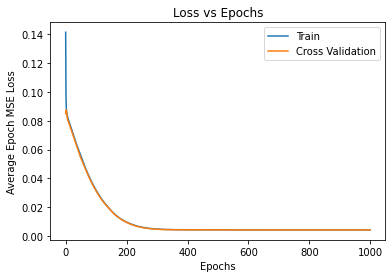

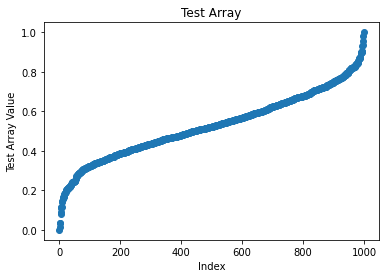

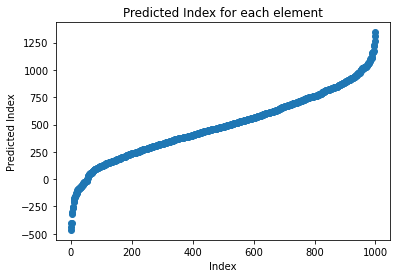

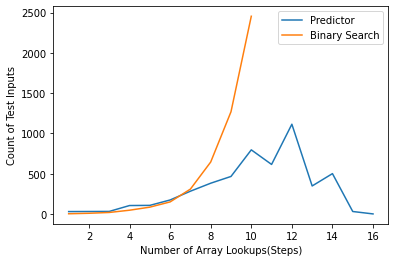

Average Number of Steps
Through Predictor:10.3204
Through Binary Search:8.986
Predictor MSE Loss : 303859.15625


In [64]:
net=Net_NHL()
net.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='normal')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='normal')
train_dataset(net,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=1000,lr=1e-3)
test_single_array(net,n,'normal')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='normal')
out=predict(net,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

  1%|          | 5/500 [00:00<00:22, 22.07it/s]

0.9139971256256103
0.12194909527897835
0.1083337940275669
0.08791624233126641
0.08641978353261948


  2%|▏         | 9/500 [00:00<00:18, 26.96it/s]

0.08497871458530426
0.08431619480252266
0.08416740372776985
0.08404315412044525
0.08397502675652505
0.08389136120676995
0.08383624702692032


  3%|▎         | 17/500 [00:00<00:15, 30.48it/s]

0.0837674081325531
0.0836952306330204
0.0836263582110405
0.08354959413409233
0.08347264155745507
0.08339183554053306
0.08330805897712708


  5%|▌         | 25/500 [00:00<00:14, 31.87it/s]

0.08322156593203545
0.0831316165626049
0.0830387257039547
0.08294234350323677
0.08284262269735336
0.08273924887180328
0.08263214752078056


  7%|▋         | 33/500 [00:01<00:14, 32.33it/s]

0.08252108693122864
0.08240588232874871
0.08228628858923911
0.0821620687842369
0.08203293606638909
0.08189859092235566
0.08175870850682258


  7%|▋         | 37/500 [00:01<00:14, 32.05it/s]

0.08161293715238571
0.08146088048815728
0.08130213618278503
0.08113625422120094
0.08096275329589844
0.08078112080693245
0.08059080839157104


  9%|▉         | 45/500 [00:01<00:14, 32.12it/s]

0.08039123564958572
0.08018177002668381
0.07996176406741143
0.07973051220178604
0.07948728799819946
0.07923131510615349
0.07896179631352425


 11%|█         | 53/500 [00:01<00:13, 32.51it/s]

0.07867789492011071
0.07837874814867973
0.07806348204612731
0.0777312010526657
0.07738102301955223
0.07701208591461181
0.07662357613444329


 12%|█▏        | 61/500 [00:01<00:13, 32.73it/s]

0.07621474862098694
0.07578499540686608
0.07533385530114174
0.07486106902360916
0.07436657026410103
0.07385040149092674
0.07331243827939034


 13%|█▎        | 65/500 [00:02<00:13, 32.67it/s]

0.07275157943367958
0.07216344252228737
0.07153523415327072
0.07084076926112175
0.07005124762654305
0.06917250156402588
0.06825680658221245


 15%|█▍        | 73/500 [00:02<00:13, 32.55it/s]

0.06734452471137047
0.06643070876598359
0.06547376662492752
0.06445922255516053
0.06340431682765484
0.062299377843737604
0.061146384850144384


 16%|█▌        | 81/500 [00:02<00:12, 32.51it/s]

0.05994366966187954
0.05869200862944126
0.0573910653591156
0.056042497232556346
0.05464816130697727
0.053210824728012085
0.05173274204134941


 18%|█▊        | 89/500 [00:02<00:12, 32.55it/s]

0.050210827961564064
0.04863777421414852
0.047016992792487146
0.0453504603356123
0.043680344521999356
0.04199481345713139
0.04029111117124558


 19%|█▊        | 93/500 [00:02<00:12, 32.43it/s]

0.038581022247672084
0.036882557719945905
0.035201720893383026
0.03354386240243912
0.031840648502111435
0.030051328428089618
0.02852614801377058


 20%|██        | 101/500 [00:03<00:12, 32.54it/s]

0.02704896554350853
0.025755630619823933
0.024800639413297177
0.022903621010482312
0.021061350777745246
0.025988968089222908
0.02233252041041851


 22%|██▏       | 109/500 [00:03<00:12, 32.37it/s]

0.01819218248128891
0.016747081838548183
0.01563242543488741
0.014343847706913947
0.013229217007756233
0.016753469966351985
0.026286846678704023


 23%|██▎       | 117/500 [00:03<00:11, 32.53it/s]

0.015548397414386272
0.011725337337702512
0.01065696682780981
0.009528790041804314
0.008800246939063072
0.008346002083271742
0.007924266578629612


 24%|██▍       | 121/500 [00:03<00:11, 32.58it/s]

0.007502969680353999
0.007085606176406145
0.006561175500974059
0.006156355515122414
0.005937556317076087
0.014243529131636023
0.009197595715522765


 26%|██▌       | 129/500 [00:04<00:11, 32.56it/s]

0.007033524522557855
0.005929373716935515
0.0052861029282212256
0.004867928707972169
0.004546070192009211
0.004347649076953531
0.004213661653921008


 27%|██▋       | 137/500 [00:04<00:11, 32.36it/s]

0.004114321526139974
0.004788864683359861
0.007426823442801833
0.004585230886004865
0.00419958580750972
0.00430186134763062
0.003606441942974925


 29%|██▉       | 145/500 [00:04<00:10, 32.55it/s]

0.0037829698994755745
0.009463731804862619
0.0049279127037152645
0.004247181583195925
0.0037366477074101566
0.0034940152429044245
0.0033935582963749767


 30%|██▉       | 149/500 [00:04<00:10, 32.50it/s]

0.0034927216591313483
0.0034227374708279967
0.004855774575844407
0.005174071295186877
0.0038384507410228253
0.00377412592060864
0.003556442679837346


 31%|███▏      | 157/500 [00:04<00:10, 32.49it/s]

0.003167245676741004
0.003978947014547885
0.006143526919186115
0.0038044049870222807
0.0035643351962789892
0.0033781423466280104
0.0030967854894697667


 33%|███▎      | 165/500 [00:05<00:10, 32.54it/s]

0.003545071603730321
0.005822177231311798
0.0034645442385226486
0.0032661764416843653
0.003818027302622795
0.0036675815703347326
0.0032750693382695316


 35%|███▍      | 173/500 [00:05<00:10, 32.32it/s]

0.0042673774994909765
0.0043588239466771485
0.0032033015741035342
0.0030862886924296618
0.004410637030377984
0.00480883449781686
0.003508145618252456


 35%|███▌      | 177/500 [00:05<00:09, 32.35it/s]

0.00342212098184973
0.003494330937974155
0.003066875250078738
0.003755981847643852
0.004848683392629028
0.0031282291747629642
0.003069437202066183


 37%|███▋      | 185/500 [00:05<00:09, 32.42it/s]

0.003860556706786156
0.004863330326043069
0.0031849572667852046
0.003077474143356085
0.004025573353283107
0.003938846383243799
0.002996313525363803


 39%|███▊      | 193/500 [00:06<00:09, 32.59it/s]

0.003201716486364603
0.005159727949649096
0.0035723986569792033
0.0032576882978901265
0.003450156142935157
0.003913319855928421
0.0031436583492904903


 40%|████      | 201/500 [00:06<00:09, 32.30it/s]

0.0033315617125481366
0.0046535228379070755
0.0033389708027243615
0.0030111708445474507
0.0033821324119344353
0.0051786367315798994
0.0032104197423905136


 41%|████      | 205/500 [00:06<00:09, 32.18it/s]

0.0030888603534549473
0.003610328771173954
0.004095202311873436
0.0030328651191666722
0.0031457417411729694
0.00471708457916975
0.003601229446940124


 43%|████▎     | 213/500 [00:06<00:08, 32.30it/s]

0.003113927668891847
0.0032584640197455884
0.004515118570998311
0.0032345307990908623
0.0029636128107085823
0.0036562742665410043
0.004764061560854316


 44%|████▍     | 221/500 [00:06<00:08, 32.20it/s]

0.003050947794690728
0.003006955608725548
0.0039761274587363
0.00405916734598577
0.0029625215334817766
0.003089604224078357
0.00465301163494587


 46%|████▌     | 229/500 [00:07<00:08, 32.38it/s]

0.0036035438533872366
0.003068625833839178
0.0032720292452722787
0.004423448303714395
0.003165920148603618
0.0029551582178100944
0.003905290481634438


 47%|████▋     | 233/500 [00:07<00:08, 32.24it/s]

0.004418184561654925
0.003029421460814774
0.0030313058057799937
0.004232591157779098
0.0036691064247861504
0.002935971459373832
0.0032697413582354782


 48%|████▊     | 241/500 [00:07<00:08, 32.29it/s]

0.0047576067503541705
0.0031648174859583377
0.002962618600577116
0.003605037718079984
0.0044946429086849095
0.002971052285283804
0.0029801159631460904


 50%|████▉     | 249/500 [00:07<00:07, 32.40it/s]

0.004181658430024981
0.003938754484988749
0.0029776830691844226
0.003130976064130664
0.004482243396341801
0.003325513890013099
0.002927072998136282


 51%|█████▏    | 257/500 [00:08<00:07, 32.35it/s]

0.0035252942936494945
0.004589206445962191
0.0029770016437396405
0.002961820689961314
0.004072193149477243
0.003983548516407609
0.0029477661242708563


 52%|█████▏    | 261/500 [00:08<00:07, 32.28it/s]

0.003115596785210073
0.004487283807247877
0.003328479430638254
0.0029212120920419694
0.003509988822042942
0.0045300370547920465
0.002963644149713218


 54%|█████▍    | 269/500 [00:08<00:07, 32.25it/s]

0.002960141305811703
0.004130527400411666
0.0038899086881428956
0.002939958474598825
0.0031584997195750475
0.0044828612357378
0.003209247626364231


 55%|█████▌    | 277/500 [00:08<00:06, 32.39it/s]

0.002911853208206594
0.0037136914441362025
0.0043257578741759065
0.002929986477829516
0.003016359475441277
0.004318496538326144
0.003524125088006258


 57%|█████▋    | 285/500 [00:08<00:06, 32.23it/s]

0.002906673029065132
0.003381270379759371
0.004508996568620205
0.002977629750967026
0.002940841158851981
0.004112501000054181
0.003855211683548987


 58%|█████▊    | 289/500 [00:08<00:06, 32.14it/s]

0.0029235485708341002
0.0031973649514839054
0.004428917821496725
0.0030693541746586563
0.0029155942611396313
0.004000649368390441
0.004002533201128244


 59%|█████▉    | 297/500 [00:09<00:06, 32.27it/s]

0.0029359406093135477
0.0031379545340314507
0.004342538584023714
0.003116393834352493
0.0029125398257747294
0.003988864738494158
0.003995677828788758


 61%|██████    | 305/500 [00:09<00:06, 32.31it/s]

0.002933300007134676
0.003142667328938842
0.0043313466012477875
0.003094079508446157
0.002915873262099922
0.004028423107229173
0.003926512063480913


 63%|██████▎   | 313/500 [00:09<00:05, 32.39it/s]

0.0029279648093506693
0.003172158217057586
0.004321790998801589
0.0030517423991113903
0.0029260854702442885
0.004093316965736449
0.003825144306756556


 63%|██████▎   | 317/500 [00:09<00:05, 32.21it/s]

0.002919983305037022
0.003215919737704098
0.004312566597945988
0.00300244705285877
0.002943186950869858
0.004190070135518908
0.0036909365560859443


 65%|██████▌   | 325/500 [00:10<00:05, 32.27it/s]

0.0029124578926712275
0.0032862106803804637
0.004285840108059347
0.002950385841540992
0.0029688546899706127
0.004278625431470573
0.0035341270733624695


 67%|██████▋   | 333/500 [00:10<00:05, 32.25it/s]

0.0028985454933717846
0.003385696792975068
0.0042496279813349245
0.0029058095533400774
0.0029993712203577163
0.004345881193876267
0.0033911139937117694


 68%|██████▊   | 341/500 [00:10<00:04, 32.35it/s]

0.002882998064160347
0.003503787098452449
0.004200701881200075
0.002881737635470927
0.003033214085735381
0.004365405952557922
0.0032619542675092817


 69%|██████▉   | 345/500 [00:10<00:04, 32.34it/s]

0.002873812848702073
0.0036462194519117476
0.004122910462319851
0.002874831110239029
0.0030787321738898754
0.004361406387761235
0.003134515485726297


 71%|███████   | 353/500 [00:10<00:04, 32.42it/s]

0.002880574110895395
0.003847027360461652
0.003951981919817627
0.0028820088598877193
0.0031663199653849004
0.004307152470573783
0.0030046463245525954


 72%|███████▏  | 361/500 [00:11<00:04, 32.28it/s]

0.0029200812336057425
0.0041126363910734655
0.003655590582638979
0.0028835173230618238
0.003327833884395659
0.0042189857689663764
0.0029035554267466067


 74%|███████▍  | 369/500 [00:11<00:04, 32.09it/s]

0.0029995112912729383
0.004304229468107224
0.0033192684641107917
0.0028665651800110934
0.0035906740929931404
0.004097466170787811
0.002864357898943126


 75%|███████▍  | 373/500 [00:11<00:03, 32.29it/s]

0.0030858444748446344
0.004346306947991252
0.0030927272979170083
0.0028813522309064864
0.0038990744622424247
0.003833615779876709
0.0028717668727040293


 76%|███████▌  | 381/500 [00:11<00:03, 32.27it/s]

0.0032236007740721107
0.004253329033963383
0.00294215593021363
0.0029536226065829396
0.004209840809926391
0.003441335307434201
0.0028651924571022392


 78%|███████▊  | 389/500 [00:12<00:03, 32.01it/s]

0.003487406321801245
0.004117252118885517
0.0028616584837436675
0.0030699085211381314
0.004323228588327765
0.0031018521171063186
0.0028773988131433727


 79%|███████▉  | 397/500 [00:12<00:03, 32.02it/s]

0.0038934495532885194
0.0037955058272928
0.002865255065262318
0.003256812272593379
0.0042120038997381926
0.002910096477717161
0.0029809710802510382


 80%|████████  | 401/500 [00:12<00:03, 31.88it/s]

0.0042491919128224255
0.003305076016113162
0.002857802319340408
0.0036173107801005244
0.0040022906381636855
0.002853044238872826
0.003138136048801243


 82%|████████▏ | 409/500 [00:12<00:02, 32.01it/s]

0.004262710944749415
0.0029669501818716526
0.0028242853935807944
0.0034680298063904046
0.0032452095998451113
0.002881643455475569
0.003989916085265577


 83%|████████▎ | 417/500 [00:12<00:02, 32.14it/s]

0.0036632005823776124
0.0028695096028968693
0.0032640531193464995
0.003956950339488685
0.0027538943337276577
0.0030315423384308813
0.004321319190785289


 85%|████████▌ | 425/500 [00:13<00:02, 32.29it/s]

0.0029079128289595246
0.002774059516377747
0.003947420604526996
0.003576209908351302
0.0028339812997728586
0.0032260692911222576
0.003911831974983215


 86%|████████▌ | 429/500 [00:13<00:02, 32.28it/s]

0.0027420988073572515
0.0030952363042160867
0.004152779909782111
0.0028222181601449845
0.002857762109488249
0.004193159728311002
0.0031499681062996387


 87%|████████▋ | 437/500 [00:13<00:01, 32.21it/s]

0.002762795030139387
0.0033855461282655598
0.003828284586779773
0.0027056619059294463
0.0031438877107575537
0.00410261214710772
0.0027434135088697078


 89%|████████▉ | 445/500 [00:13<00:01, 32.32it/s]

0.0029972363030537964
0.004140784824267029
0.0028712413972243668
0.0028001768281683327
0.0041420292807742955
0.0031683034729212524
0.002810542704537511


 91%|█████████ | 453/500 [00:14<00:01, 32.36it/s]

0.003210939816199243
0.0038203694159165023
0.002737925108522177
0.0034111167769879103
0.0035995318554341792
0.002672166936099529
0.003286502370610833


 91%|█████████▏| 457/500 [00:14<00:01, 32.18it/s]

0.0038211136357858776
0.0026648176135495305
0.0031887232325971127
0.003927495772950351
0.0026692328276112674
0.003389726672321558
0.003627301403321326


 93%|█████████▎| 465/500 [00:14<00:01, 32.39it/s]

0.0027457954827696087
0.002770113619044423
0.004021366569213569
0.0030018731486052275
0.002806177851743996
0.003614948270842433
0.002783624175935984


 95%|█████████▍| 473/500 [00:14<00:00, 32.16it/s]

0.002566301543265581
0.004083170183002948
0.0034362825332209467
0.003610104392282665
0.004715717420913279
0.0063237188383936885
0.004555863118730486


 96%|█████████▌| 481/500 [00:14<00:00, 32.25it/s]

0.003811877639964223
0.002949094120413065
0.00253419557120651
0.0025258398614823817
0.0025216566398739816
0.0024912245105952026
0.0024791285395622253


 97%|█████████▋| 485/500 [00:15<00:00, 32.05it/s]

0.0024699308443814514
0.0024796832352876664
0.0024804766289889812
0.0025255591608583927
0.002635420439764857
0.0028037233743816612
0.00292323618195951


 99%|█████████▊| 493/500 [00:15<00:00, 32.29it/s]

0.002921958127990365
0.002967982576228678
0.0029511240543797614
0.002957589947618544
0.0029797024792060254
0.002961800782941282
0.0029831266729161143


100%|██████████| 500/500 [00:15<00:00, 32.16it/s]

0.0029699327424168587
0.0029820824274793267
0.002969690761528909
0.002977993409149349
0.0029680927749723197


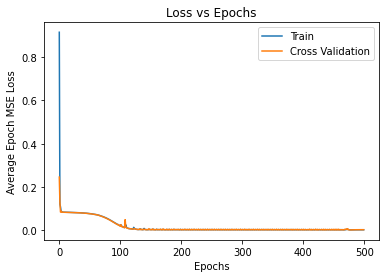

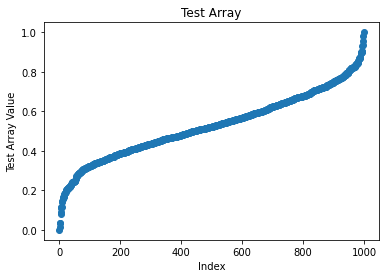

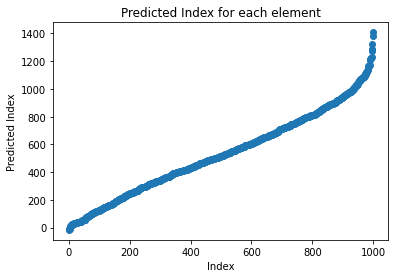

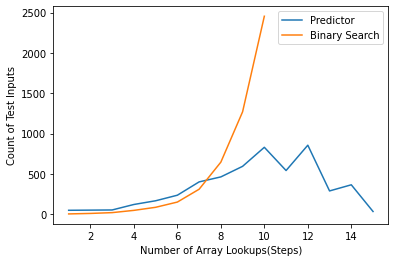

Average Number of Steps
Through Predictor:9.7422
Through Binary Search:8.986
Predictor MSE Loss : 349468.96875


In [65]:
net_1=Net_1HL()
net_1.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='normal')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='normal')
train_dataset(net_1,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=500,lr=1e-3)
test_single_array(net_1,n,'normal')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='normal')
out=predict(net_1,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

  0%|          | 2/500 [00:00<00:33, 14.78it/s]

0.12581658214330674
0.08803778439760208
0.08516548797488213


  1%|▏         | 7/500 [00:00<00:26, 18.29it/s]

0.0843854308128357
0.08405618220567704
0.08372782990336418
0.08364610001444817
0.08341880068182946


  3%|▎         | 13/500 [00:00<00:22, 21.44it/s]

0.08323525041341781
0.08308218494057655
0.08289137482643127
0.08268369659781456
0.08247536495327949


  3%|▎         | 16/500 [00:00<00:22, 21.99it/s]

0.08226068168878556
0.08203373551368713
0.08180040419101715
0.08153891041874886
0.0812898688018322


  4%|▍         | 22/500 [00:01<00:21, 22.73it/s]

0.08102640360593796
0.0807266503572464
0.0803666315972805
0.07992600575089455
0.07941195517778396


  6%|▌         | 28/500 [00:01<00:20, 22.91it/s]

0.07887198850512504
0.078346336632967
0.07782847955822944
0.07726233378052712
0.07665113657712937


  6%|▌         | 31/500 [00:01<00:20, 23.02it/s]

0.07599313482642174
0.07528490647673607
0.07452075555920601
0.0737010233104229
0.0728189155459404


  7%|▋         | 37/500 [00:01<00:20, 23.04it/s]

0.07184586003422737
0.07077264487743377
0.06956731602549553
0.0683295950293541
0.06696459501981736


  9%|▊         | 43/500 [00:01<00:19, 23.15it/s]

0.06552766412496566
0.06402999199926854
0.06222857609391212
0.06073822267353535
0.058640233054757115


  9%|▉         | 46/500 [00:02<00:19, 22.93it/s]

0.05683151856064796
0.05542861744761467
0.05257429890334606
0.050121691823005673
0.048830213770270345


 10%|█         | 52/500 [00:02<00:19, 23.13it/s]

0.04745228625833988
0.04415252394974232
0.04100029654800892
0.039117886871099475
0.03759374842047691


 12%|█▏        | 58/500 [00:02<00:19, 23.11it/s]

0.03469081148505211
0.031549439579248426
0.03706818222999573
0.03082134872674942
0.02667495533823967


 12%|█▏        | 61/500 [00:02<00:19, 23.10it/s]

0.024461681395769118
0.022148924879729748
0.020690594986081123
0.01925803069025278
0.017783410102128982


 13%|█▎        | 67/500 [00:02<00:18, 23.15it/s]

0.017603984102606773
0.01747533669695258
0.014489598013460636
0.013345647789537906
0.011387685872614383


 15%|█▍        | 73/500 [00:03<00:18, 23.05it/s]

0.010134623572230338
0.016681755613535642
0.012148471642285585
0.009824594389647246
0.0082795272115618


 15%|█▌        | 76/500 [00:03<00:18, 23.23it/s]

0.007331809541210532
0.006580261792987585
0.006138016004115343
0.005712749203667045
0.0052048759534955025


 16%|█▋        | 82/500 [00:03<00:18, 23.14it/s]

0.004915614007040858
0.008412122819572687
0.005560738267377019
0.0048354552825912835
0.00425822171382606


 18%|█▊        | 88/500 [00:03<00:17, 23.15it/s]

0.0036705701611936094
0.00353945919778198
0.00342176160775125
0.007281523523852229
0.004519129381515085


 18%|█▊        | 91/500 [00:04<00:17, 23.22it/s]

0.0037336288951337337
0.002834427054040134
0.0027818816248327493
0.0025431800168007612
0.002512898249551654


 19%|█▉        | 97/500 [00:04<00:17, 23.15it/s]

0.0036670520901679994
0.0034075260860845446
0.0027833124157041313
0.0026762153953313827
0.0031536949332803487


 21%|██        | 103/500 [00:04<00:17, 23.23it/s]

0.002118380647152662
0.0022416279884055258
0.003468942269682884
0.0032742181210778654
0.002769079594872892


 21%|██        | 106/500 [00:04<00:17, 23.09it/s]

0.0021014062338508667
0.0024012607289478185
0.002329547971021384
0.0017827756819315255
0.0017420637421309948


 22%|██▏       | 112/500 [00:04<00:16, 23.05it/s]

0.0035622760653495787
0.00429929131641984
0.0025324586778879164
0.0018548005842603742
0.0019601736566983163


 24%|██▎       | 118/500 [00:05<00:16, 23.27it/s]

0.0016321418108418584
0.001740996481385082
0.0018805441679432989
0.0020139908068813384
0.0021428524982184173


 24%|██▍       | 121/500 [00:05<00:16, 23.33it/s]

0.002011108794249594
0.002060434373561293
0.002368705777917057
0.0015902369981631637
0.0018296518130227924


 25%|██▌       | 127/500 [00:05<00:15, 23.32it/s]

0.0034359848476015033
0.002058996760752052
0.001939842675346881
0.001698280859272927
0.0014722062740474939


 27%|██▋       | 133/500 [00:05<00:15, 23.21it/s]

0.002225731883663684
0.002301285765133798
0.0017818860593251883
0.0015990891959518194
0.002937808271963149


 27%|██▋       | 136/500 [00:05<00:15, 23.28it/s]

0.001937542052473873
0.0016677618958055973
0.002301208337303251
0.0015052534989081323
0.0014331029495224356


 28%|██▊       | 142/500 [00:06<00:15, 23.29it/s]

0.0026901916833594443
0.0019849032862111924
0.0017339825513772666
0.002312933700159192
0.0015873332391493022


 30%|██▉       | 148/500 [00:06<00:15, 23.24it/s]

0.0014689583447761833
0.0019076522439718246
0.002114822075236589
0.0017185114906169475
0.0015225798240862786


 30%|███       | 151/500 [00:06<00:15, 23.22it/s]

0.0025672246236354114
0.0017850490054115652
0.0015088210115209223
0.002435466251336038
0.0016104152193292976


 31%|███▏      | 157/500 [00:06<00:14, 23.16it/s]

0.0014292478794232012
0.0023909309529699385
0.0015727547579444945
0.0015050217974931003
0.0022365723154507576


 33%|███▎      | 163/500 [00:07<00:14, 23.27it/s]

0.0018451755866408348
0.001642961474135518
0.0020542426500469446
0.0016887021018192172
0.0015005612978711725


 33%|███▎      | 166/500 [00:07<00:14, 23.31it/s]

0.0017388230306096375
0.0020789014524780214
0.001645808306057006
0.0015548066701740026
0.0022648501326330006


 34%|███▍      | 172/500 [00:07<00:14, 23.30it/s]

0.0016494588111527265
0.0014757281867787242
0.0022332800435833633
0.0015395480673760175
0.0013558604987338185


 36%|███▌      | 178/500 [00:07<00:13, 23.20it/s]

0.002377403457649052
0.001550686068367213
0.0014415539684705437
0.002368450886569917
0.001653360144700855


 36%|███▌      | 181/500 [00:07<00:13, 23.07it/s]

0.001538195286411792
0.0021524960175156593
0.0014515787246637047
0.0013886783039197327
0.001981975941453129


 37%|███▋      | 187/500 [00:08<00:13, 23.33it/s]

0.0018009425955824554
0.001596477208659053
0.0019412562134675682
0.001907353848218918
0.001550985616631806


 39%|███▊      | 193/500 [00:08<00:13, 23.29it/s]

0.001849672058597207
0.0015464893775060772
0.00133218978298828
0.0015313386800698936
0.0021464973106049


 39%|███▉      | 196/500 [00:08<00:13, 23.25it/s]

0.0016310971113853157
0.0014071372686885297
0.002342498698271811
0.0016800252837128938
0.0014687968301586806


 40%|████      | 202/500 [00:08<00:12, 23.23it/s]

0.0020719725056551398
0.001447289576753974
0.0013552914722822606
0.0021072305273264645
0.001394740503747016


 42%|████▏     | 208/500 [00:09<00:12, 23.18it/s]

0.0012601383146829902
0.0023467037826776505
0.0015799318556673826
0.001533593493513763
0.0023232528124935924


 42%|████▏     | 211/500 [00:09<00:12, 23.25it/s]

0.0015618916368111968
0.0014084339491091669
0.001946937956381589
0.0012473089620471001
0.0012011998798698187


 43%|████▎     | 217/500 [00:09<00:12, 23.26it/s]

0.0019320847932249308
0.0018092628451995552
0.0016196464886888862
0.001995136123150587
0.001993725472129881


 45%|████▍     | 223/500 [00:09<00:11, 23.11it/s]

0.0015428784885443748
0.001633850729558617
0.001183560467325151
0.0012225121026858687
0.0019434022600762547


 45%|████▌     | 226/500 [00:09<00:11, 23.04it/s]

0.0013242480694316328
0.0011328795924782753
0.0015112877706997096
0.0025559471105225384
0.0019409279804676772


 46%|████▋     | 232/500 [00:10<00:11, 23.00it/s]

0.0018399288412183524
0.002095796819776297
0.0014716958627104758
0.0014737641671672464
0.0011401683557778596


 48%|████▊     | 238/500 [00:10<00:11, 23.16it/s]

0.0013544244691729545
0.0017227435251697897
0.0011628187377937139
0.0016677661333233118
0.002074690954759717


 48%|████▊     | 241/500 [00:10<00:11, 23.20it/s]

0.0015704827033914625
0.001332056277897209
0.0022438883665017785
0.0016674075508490206
0.0015000922023318708


 49%|████▉     | 247/500 [00:10<00:10, 23.16it/s]

0.001983614661730826
0.00141660925000906
0.0015431292820721864
0.001576250762445852
0.0012014438048936426


 51%|█████     | 253/500 [00:11<00:10, 23.12it/s]

0.0013415184570476414
0.0020152955665253105
0.0014615959022194146
0.0012357071042060851
0.002230642398353666


 51%|█████     | 256/500 [00:11<00:10, 23.08it/s]

0.0015502342372201382
0.001357865543104708
0.0021404367638751865
0.0014536580070853232
0.0012907516211271286


 52%|█████▏    | 262/500 [00:11<00:10, 23.24it/s]

0.0018732076045125724
0.0012501757009886205
0.0011618106043897569
0.002088894532062113
0.0013037904514931141


 54%|█████▎    | 268/500 [00:11<00:10, 23.08it/s]

0.001262610492995009
0.002185094484593719
0.0016095859929919243
0.0015307419351302087
0.0019964516162872315


 54%|█████▍    | 271/500 [00:11<00:09, 23.15it/s]

0.001216231274884194
0.0011391768930479884
0.0018909611273556948
0.001243377255741507
0.001226090337149799


 55%|█████▌    | 277/500 [00:12<00:09, 23.14it/s]

0.0017230890109203756
0.0018037952017039061
0.0015621645376086234
0.0019987138104625045
0.00171931772492826


 57%|█████▋    | 283/500 [00:12<00:09, 23.27it/s]

0.0013816025224514306
0.0015189053607173263
0.0010461815109010786
0.001139468332985416
0.0017923915176652372


 57%|█████▋    | 286/500 [00:12<00:09, 23.09it/s]

0.0011198611231520773
0.0010179329197853803
0.0023012318881228564
0.0019310209201648832
0.0016406737500801682


 58%|█████▊    | 292/500 [00:12<00:09, 23.07it/s]

0.001804075506515801
0.0010513012879528106
0.001053849351592362
0.0018184766639024019
0.0011560958286281676


 60%|█████▉    | 298/500 [00:12<00:08, 22.93it/s]

0.001114471984328702
0.0012669842632021754
0.0020826700958423315
0.0014802445424720646
0.001209408655995503


 60%|██████    | 301/500 [00:13<00:08, 23.03it/s]

0.002198680362198502
0.001522491843206808
0.001333093480207026
0.0018735023564659058
0.0012076545041054486


 61%|██████▏   | 307/500 [00:13<00:08, 22.96it/s]

0.0011507792281918229
0.001737764512654394
0.0010731950809713454
0.0010099381615873426
0.0020505496067926288


 63%|██████▎   | 313/500 [00:13<00:08, 22.97it/s]

0.0013755838212091477
0.001413308788323775
0.002143005991820246
0.0015695003734435887
0.0013434699329081922


 63%|██████▎   | 316/500 [00:13<00:07, 23.00it/s]

0.0014730710769072174
0.000937287212582305
0.0010832314554136246
0.0017082860111258924
0.0009946396807208658


 64%|██████▍   | 322/500 [00:14<00:07, 22.87it/s]

0.0009519797808025032
0.002276937896385789
0.0017776931636035442
0.001590880542062223
0.0017261842847801745


 66%|██████▌   | 328/500 [00:14<00:07, 23.14it/s]

0.0009944766410626472
0.0009922450524754822
0.0017322269966825842
0.0010601610410958529
0.0010238394781481475


 66%|██████▌   | 331/500 [00:14<00:07, 23.01it/s]

0.0011932930385228247
0.0020425840571988373
0.001418499369174242
0.0011755462095607073
0.0021452232962474228


 67%|██████▋   | 337/500 [00:14<00:07, 23.06it/s]

0.0015091902285348624
0.0013331476657185704
0.001780012232484296
0.001166680466849357
0.0011474254657514392


 69%|██████▊   | 343/500 [00:14<00:06, 23.00it/s]

0.0015392118599265813
0.0009938837145455181
0.0009653005574364216
0.0020089996396563947
0.00118195257964544


 69%|██████▉   | 346/500 [00:15<00:06, 22.97it/s]

0.0012636878760531544
0.0020105481380596757
0.0015713176340796053
0.0014496018993668258
0.0015309519658330828


 70%|███████   | 352/500 [00:15<00:06, 22.97it/s]

0.0009046083549037575
0.0009723744937218725
0.0016630061902105809
0.0009793770441319793
0.0009107638674322516


 72%|███████▏  | 358/500 [00:15<00:06, 23.00it/s]

0.001404014346189797
0.0019361383863724768
0.001636400236748159
0.0016836958297062666
0.0019392628164496273


 72%|███████▏  | 361/500 [00:15<00:06, 23.01it/s]

0.001325570180779323
0.001124207756947726
0.0008686027023941279
0.001250018720747903
0.0012207069667056203


 73%|███████▎  | 367/500 [00:15<00:05, 22.98it/s]

0.0008792532258667052
0.0017431152053177356
0.0014719032042194158
0.0013703337928745896
0.0016236819501500577


 75%|███████▍  | 373/500 [00:16<00:05, 22.98it/s]

0.001715911232167855
0.0013491453777533025
0.00140201534377411
0.000890356139279902
0.0009028438711538911


 75%|███████▌  | 376/500 [00:16<00:05, 23.09it/s]

0.0016020097536966205
0.0010731450922321529
0.0009227135102264583
0.0009668942948337644
0.0022046416997909546


 76%|███████▋  | 382/500 [00:16<00:05, 22.85it/s]

0.001308400643756613
0.0013242939545307308
0.0020645857264753433
0.0014091209392063319
0.0011718790279701351


 78%|███████▊  | 388/500 [00:16<00:04, 22.90it/s]

0.0014642314286902546
0.00095756592345424
0.0009874384151771665
0.001585514860926196
0.0009096684167161584


 78%|███████▊  | 391/500 [00:17<00:04, 22.77it/s]

0.0008769249427132309
0.0017291005118750037
0.0014559840376023204
0.0014157405239529908
0.001935752120334655


 79%|███████▉  | 397/500 [00:17<00:04, 22.98it/s]

0.0015904462081380189
0.0012592877552378922
0.001129673223476857
0.0008033052203245461
0.0011476208223029972


 81%|████████  | 403/500 [00:17<00:04, 23.15it/s]

0.0012058433378115297
0.0008452383684925735
0.0016739238693844528
0.0012630848330445587
0.0012426027213223278


 81%|████████  | 406/500 [00:17<00:04, 23.01it/s]

0.0011941085220314562
0.001681616116547957
0.001414541935082525
0.0015235005295835436
0.0016050640086177736


 82%|████████▏ | 412/500 [00:17<00:03, 22.88it/s]

0.001176903664600104
0.0012101563974283636
0.0008295309904497117
0.000932420848403126
0.0014286253252066671


 84%|████████▎ | 418/500 [00:18<00:03, 22.88it/s]

0.0008752629626542329
0.0010299466084688902
0.0018216934404335916
0.0010578075132798403
0.001064453402068466


 84%|████████▍ | 421/500 [00:18<00:03, 22.97it/s]

0.0017247998679522426
0.0013088587613310665
0.001316668512299657
0.0019264736329205334
0.001298772537847981


 85%|████████▌ | 427/500 [00:18<00:03, 23.08it/s]

0.0011225222959183156
0.0012566077697556467
0.0007643594406545162
0.0008863535069394857
0.0015180778806097805


 87%|████████▋ | 433/500 [00:18<00:02, 22.96it/s]

0.0008130653237458319
0.0007666559307835996
0.0017453710781410337
0.001641407364513725
0.001505982835078612


 87%|████████▋ | 436/500 [00:18<00:02, 22.99it/s]

0.0016642038477584719
0.0009249177935998886
0.0008688037167303264
0.0014627503289375455
0.0009740671201143413


 88%|████████▊ | 442/500 [00:19<00:02, 22.94it/s]

0.0009504267305601388
0.001300213928334415
0.0014592330844607204
0.0012934200058225542
0.0015748958336189388


 90%|████████▉ | 448/500 [00:19<00:02, 22.94it/s]

0.001355198578676209
0.0011132782441563905
0.0012461101054213942
0.0007688299287110567
0.0007616367365699261


 90%|█████████ | 451/500 [00:19<00:02, 22.98it/s]

0.0014796624425798654
0.0010059473919682206
0.0009584445389918983
0.0008297432505059987
0.001906505215447396


 91%|█████████▏| 457/500 [00:19<00:01, 22.97it/s]

0.0009572335868142546
0.001081934111425653
0.001739724399521947
0.001407040486810729
0.0014410671312361956


 93%|█████████▎| 463/500 [00:20<00:01, 22.84it/s]

0.001380691322265193
0.0007594130409415811
0.0007786917150951922
0.0014638559659942985
0.0008192864421289414


 93%|█████████▎| 466/500 [00:20<00:01, 22.91it/s]

0.0007715237967204303
0.001047571178060025
0.0017374097602441906
0.0014003891439642758
0.0011805640649981796


 94%|█████████▍| 472/500 [00:20<00:01, 23.04it/s]

0.0017598821315914393
0.0012374571175314485
0.0011835574521683156
0.0008232593070715665
0.0007043630059342832


 96%|█████████▌| 478/500 [00:20<00:00, 22.89it/s]

0.001182937086559832
0.0012375870835967361
0.0010139841528143735
0.000816839374601841
0.001749827351886779


 96%|█████████▌| 481/500 [00:20<00:00, 22.87it/s]

0.0009493257035501302
0.0010100022540427745
0.0018591895408462734
0.001331778516760096
0.0014021355891600251


 97%|█████████▋| 487/500 [00:21<00:00, 22.99it/s]

0.001238199172075838
0.0007879786600824446
0.0009169811673928052
0.001140766846947372
0.0006704432715196162


 99%|█████████▊| 493/500 [00:21<00:00, 23.11it/s]

0.0009123452997300774
0.0016223062120843679
0.0011233237979467957
0.0010305898438673466
0.0017329562862869353


 99%|█████████▉| 496/500 [00:21<00:00, 23.07it/s]

0.0013548503164201974
0.0012211280991323292
0.0013663893972989173
0.0009638148767407984
0.001068397198105231


100%|██████████| 500/500 [00:21<00:00, 22.96it/s]


0.0008133359951898456
0.0006683148501906544


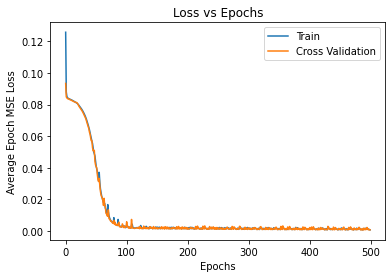

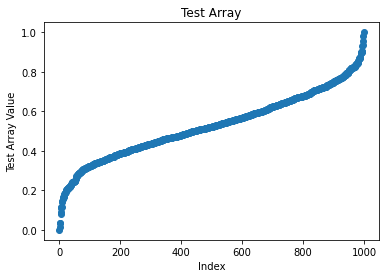

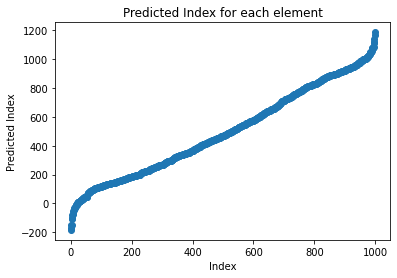

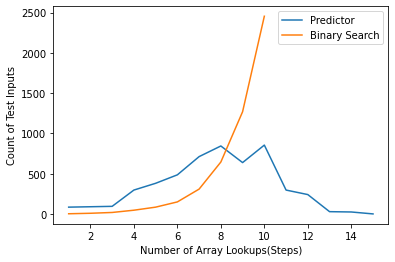

Average Number of Steps
Through Predictor:7.8852
Through Binary Search:8.986
Predictor MSE Loss : 311822.21875


In [66]:
net_2=Net_2HL()
net_2.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='normal')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='normal')
train_dataset(net_2,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=500,lr=1e-4)
test_single_array(net_2,n,'normal')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='normal')
out=predict(net_2,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

#Exponential


  2%|▏         | 11/500 [00:00<00:04, 100.24it/s]

0.1340947762131691
0.09621361047029495
0.09050904214382172
0.08771328404545783
0.08651388511061668
0.0855377271771431
0.08479163646697999
0.08408716842532157
0.08335280269384385
0.08267533928155898
0.08199329450726509
0.08129818961024285
0.08061099722981453
0.07992913648486137
0.07924663051962852
0.07856526300311088
0.07788760513067246
0.07721395045518875
0.07654398456215858
0.0758778691291809
0.07521603032946586
0.07455886676907539


  9%|▉         | 44/500 [00:00<00:04, 105.89it/s]

0.07390664294362068
0.07325955256819724
0.0726177841424942
0.07198148742318153
0.0713507927954197
0.0707257904112339
0.07010652050375939
0.06949298083782196
0.06888509765267373
0.06828274577856064
0.06768574491143227
0.06709386184811592
0.06650683954358101
0.06592439040541649
0.06534626260399819
0.06477223187685013
0.06420214995741844
0.06363596655428409
0.06307374089956283
0.0625156369060278
0.061961918324232104
0.06141294501721859


 13%|█▎        | 66/500 [00:00<00:04, 105.19it/s]

0.06086910627782345
0.060330826044082644
0.05979849174618721
0.05927244909107685
0.05875294804573059
0.058240140601992604
0.05773405991494655
0.05723464749753475
0.05674176551401615
0.05625524073839187
0.05577489510178566
0.055300557613372804
0.05483210012316704
0.05436940230429173
0.05391238033771515
0.05346094705164432
0.0530150230973959
0.05257453620433807
0.05213940553367138
0.05170956514775753
0.05128494873642921
0.05086548812687397


 18%|█▊        | 88/500 [00:00<00:03, 105.27it/s]

0.05045112259685993
0.05004179365932941
0.04963743425905705
0.049237992614507675
0.04884340800344944
0.048453622683882716
0.0480685830116272
0.04768823236227036
0.04731251560151577
0.0469413835555315
0.04657478258013725
0.046212656795978545
0.045854964107275006
0.045501647517085075
0.045152650028467176
0.044807929918169974
0.04446743912994862
0.044131125509738925
0.043798946961760524
0.04347085133194924
0.04314679615199566
0.04282673187553883


 20%|█▉        | 99/500 [00:00<00:03, 104.71it/s]

0.042510618641972545
0.04219840951263905
0.041890059411525724
0.04158553071320057
0.04128477722406387
0.04098775684833526
0.04069442413747311
0.04040474370121956
0.04011867456138134
0.039836179837584494
0.0395572192966938
0.039281755313277246
0.03900974467396736
0.038741153478622434
0.03847594633698463
0.03821408748626709
0.037955543398857115
0.03770027607679367
0.03744825050234794
0.03719943128526211
0.03695378787815571


 24%|██▍       | 121/500 [00:01<00:03, 100.98it/s]

0.0367112897336483
0.03647189810872078
0.03623558320105076
0.03600231260061264
0.03577205501496792
0.035544781014323235
0.03532045967876911
0.035099060460925105
0.034880555048584935
0.03466491252183914
0.034452106803655624
0.03424210660159588
0.03403488285839558
0.03383041694760323
0.0336286686360836
0.033429618924856186
0.033233237266540525
0.0330394983291626
0.03284837156534195
0.03265984021127224
0.03247387111186981


 29%|██▊       | 143/500 [00:01<00:03, 100.60it/s]

0.032290438935160634
0.032109517976641654
0.03193109482526779
0.03175513446331024
0.031581611931324007
0.031410505063831806
0.031241793558001517
0.031075447052717208
0.030911448784172534
0.030749770998954772
0.030590391159057616
0.030433285981416702
0.030278431437909602
0.03012581430375576
0.029975402541458605
0.029827179759740828
0.029681121185421943
0.029537208378314972
0.02939541880041361
0.02925572693347931
0.02911811973899603


 33%|███▎      | 165/500 [00:01<00:03, 103.89it/s]

0.02898256927728653
0.028849059343338014
0.0287175627425313
0.02858806513249874
0.028460541926324367
0.028334981016814708
0.028211356326937675
0.02808965351432562
0.02796984501183033
0.027851918525993825
0.027735851332545282
0.027621624991297722
0.027509220503270627
0.027398617751896382
0.027289802394807338
0.027182752266526222
0.0270774457603693
0.02697387021034956
0.026872008480131625
0.02677183710038662
0.02667334359139204
0.026576506718993188


 37%|███▋      | 187/500 [00:01<00:03, 103.71it/s]

0.026481308043003082
0.026387728191912173
0.02629575375467539
0.026205365732312202
0.026116543635725974
0.02602927517145872
0.025943537428975105
0.025859313271939754
0.02577658537775278
0.02569533698260784
0.025615549832582473
0.025537204928696156
0.025460284017026425
0.025384767912328243
0.025310639292001724
0.02523788008838892
0.02516647130250931
0.025096392445266246
0.025027622282505036
0.0249601436778903
0.02489394024014473
0.024828987009823323


 42%|████▏     | 209/500 [00:02<00:02, 105.34it/s]

0.024765265733003618
0.02470275778323412
0.024641443602740766
0.024581300653517248
0.024522313475608827
0.02446445934474468
0.02440772168338299
0.024352079443633556
0.0242975078523159
0.024243995919823645
0.024191520921885968
0.024140066094696523
0.024089611507952212
0.024040140584111212
0.02399163655936718
0.023944084346294404
0.023897467367351054
0.023851768299937248
0.02380697466433048
0.023763069696724416
0.02372003812342882
0.023677869327366353


 46%|████▌     | 231/500 [00:02<00:02, 104.08it/s]

0.023636547103524207
0.02359606008976698
0.023556393571197987
0.02351753804832697
0.023479478247463704
0.023442204110324383
0.02340570241212845
0.023369960859417914
0.023334970511496068
0.023300717957317828
0.023267193138599394
0.023234385438263415
0.02320228610187769
0.02317088358104229
0.023140165209770202
0.02311012092977762
0.023080740682780744
0.023052016273140907
0.023023935966193676
0.022996485605835913
0.022969659604132175


 51%|█████     | 253/500 [00:02<00:02, 105.44it/s]

0.02294344678521156
0.02291783634573221
0.02289281878620386
0.02286838348954916
0.022844521142542363
0.022821224480867385
0.02279847804456949
0.02277627419680357
0.022754605300724505
0.022733460180461407
0.02271282970905304
0.022692703083157538
0.022673073038458825
0.02265392765402794
0.022635260224342348
0.02261706069111824
0.022599317505955695
0.022582024335861206
0.02256516981869936
0.022548749670386316
0.02253275141119957
0.022517166659235956


 55%|█████▌    | 275/500 [00:02<00:02, 103.49it/s]

0.022501985542476177
0.02248720396310091
0.022472809441387652
0.022458794899284838
0.022445151582360268
0.022431873343884946
0.022418950498104096
0.022406376153230666
0.022394140623509882
0.02238223943859339
0.022370661422610284
0.022359401732683182
0.022348450683057308
0.022337802685797215
0.022327449545264243
0.02231738604605198
0.022307603619992733
0.02229809407144785
0.022288853675127028
0.022279873490333557
0.022271145693957807


 59%|█████▉    | 297/500 [00:02<00:01, 101.92it/s]

0.022262665815651415
0.022254427522420885
0.022246425785124303
0.022238650172948838
0.022231097519397735
0.022223761305212975
0.022216635383665563
0.02220971304923296
0.022202990017831326
0.02219645883888006
0.0221901161596179
0.022183954156935214
0.022177968360483646
0.02217215336859226
0.02216650377959013
0.02216101475059986
0.022155679948627948
0.022150494530797003
0.022145453095436095
0.022140551544725894
0.022135784849524498


 64%|██████▍   | 319/500 [00:03<00:01, 103.43it/s]

0.022131146118044853
0.022126633301377298
0.022122239880263805
0.022117961943149567
0.022113794833421706
0.022109732404351233
0.02210577204823494
0.0221019072458148
0.022098134271800518
0.022094450145959853
0.02209084704518318
0.02208732217550278
0.022083871625363828
0.022080490738153456
0.02207717429846525
0.02207391895353794
0.022070720233023165
0.022067573852837086
0.02206447497010231
0.022061420790851115
0.022058406099677085


 68%|██████▊   | 341/500 [00:03<00:01, 101.95it/s]

0.022055427730083465
0.022052481956779956
0.022049564868211746
0.02204667218029499
0.022043799981474876
0.02204094920307398
0.02203811313956976
0.022035289369523526
0.022032478637993336
0.02202967368066311
0.022026879154145716
0.02202409114688635
0.022021307609975338
0.02201853133738041
0.022015762887895106
0.02201300226151943
0.022010252252221106
0.022007516399025918
0.02200479730963707
0.02200210075825453
0.021999428421258925


 73%|███████▎  | 363/500 [00:03<00:01, 102.89it/s]

0.021996787935495376
0.021994185261428358
0.021991625241935254
0.02198911514133215
0.021986661292612553
0.02198426779359579
0.02198194246739149
0.02197968866676092
0.0219775116071105
0.02197541482746601
0.021973399631679057
0.021971468441188337
0.021969622187316417
0.02196786105632782
0.021966184861958025
0.021964590065181255
0.021963075362145902
0.02196164019405842
0.021960280649363995
0.02195899412035942
0.02195777725428343
0.021956625580787658


 77%|███████▋  | 385/500 [00:03<00:01, 104.26it/s]

0.021955537796020507
0.02195451073348522
0.02195354104042053
0.021952625177800656
0.0219517607241869
0.021950944885611536
0.021950173936784268
0.021949446946382522
0.02194875981658697
0.021948111802339555
0.021947499550879
0.02194692175835371
0.0219463761895895
0.02194586005061865
0.021945373341441154
0.021944914013147354
0.021944479644298555
0.021944069303572178
0.021943681873381138
0.021943316049873828
0.02194297146052122
0.021942644938826562


 81%|████████▏ | 407/500 [00:03<00:00, 104.94it/s]

0.021942336671054365
0.021942046470940113
0.02194177210330963
0.021941513381898405
0.021941269934177398
0.0219410402700305
0.021940823644399643
0.021940620616078377
0.021940428763628006
0.021940249763429166
0.021940081007778646
0.021939923427999018
0.02193977478891611
0.02193963825702667
0.02193950805813074
0.021939389407634735
0.021939278952777384
0.021939175948500634
0.021939081884920598
0.021938995085656644
0.021938916482031345
0.021938844211399557


 86%|████████▌ | 430/500 [00:04<00:00, 106.75it/s]

0.021938780695199965
0.02193872258067131
0.021938672848045827
0.02193862907588482
0.021938591822981836
0.021938560530543327
0.021938536129891873
0.021938518807291984
0.02193850614130497
0.02193850018084049
0.021938500739634038
0.021938508190214635
0.021938519552350044
0.021938536874949933
0.021938562020659448
0.02193859275430441
0.021938629820942877
0.02193867228925228
0.021938722394406796
0.02193877790123224
0.021938839741051198
0.021938908472657205


 90%|█████████ | 452/500 [00:04<00:00, 106.48it/s]

0.021938983537256717
0.021939065493643283
0.021939154900610446
0.021939250640571117
0.02193935364484787
0.021939464658498765
0.02193958330899477
0.021939709223806857
0.0219398433342576
0.02193998619914055
0.021940137073397637
0.021940296702086925
0.02194046638906002
0.02194064445793629
0.021940831281244754
0.02194103002548218
0.021941236965358258
0.02194145563989878
0.02194168362766504
0.02194192335009575
0.021942174062132835
0.021942435763776302


 95%|█████████▍| 474/500 [00:04<00:00, 103.18it/s]

0.021942709758877754
0.021942994371056557
0.021943292766809463
0.02194360103458166
0.02194392215460539
0.021944256126880647
0.021944600529968737
0.021944958716630936
0.021945327147841455
0.02194570768624544
0.02194609958678484
0.021946500428020953
0.02194691263139248
0.02194733340293169
0.021947763115167617
0.021948199719190598
0.021948642656207086
0.021949090994894505
0.021949543990194796
0.02194999884814024
0.021950455382466316


 99%|█████████▉| 496/500 [00:04<00:00, 102.94it/s]

0.021950912103056906
0.021951365284621716
0.02195181604474783
0.021952262707054616
0.021952702850103378
0.021953133493661882
0.021953556314110757
0.021953967027366163
0.021954367868602276
0.021954753249883652
0.021955124847590924
0.021955481357872488
0.02195582240819931
0.02195614669471979
0.02195645421743393
0.02195674516260624
0.021957018971443178
0.021957275830209254
0.021957515552639962
0.021957737766206263
0.021957944333553314


100%|██████████| 500/500 [00:04<00:00, 103.31it/s]


0.021958134695887567
0.021958311088383198
0.021958471089601517
0.02195861879736185


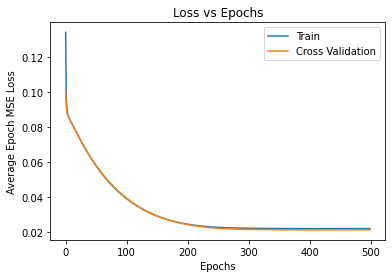

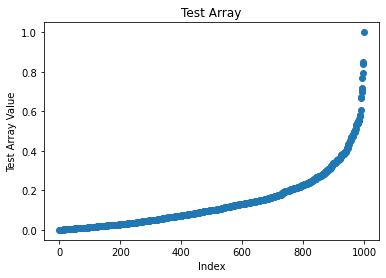

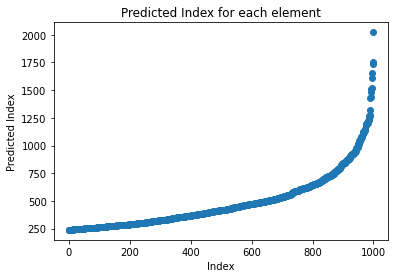

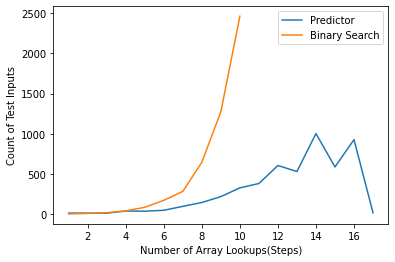

Average Number of Steps
Through Predictor:12.8356
Through Binary Search:8.9918


In [52]:
net=Net_NHL()
net.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='exponential')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='exponential')
train_dataset(net,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=500,lr=1e-3)
test_single_array(net,n,'exponential')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='exponential')
out=predict(net,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

  1%|          | 3/500 [00:00<00:23, 21.08it/s]

0.15066345557570457
0.09505253955721855
0.09013367369771004
0.08653158247470856
0.08487462922930718


  2%|▏         | 9/500 [00:00<00:19, 25.72it/s]

0.08339099809527398
0.08175772055983543
0.08001997321844101
0.07813240438699723
0.0759759820997715
0.07343857809901237
0.0704818457365036


  3%|▎         | 17/500 [00:00<00:16, 29.45it/s]

0.06709884256124496
0.06325151473283767
0.05911030881106853
0.054739561304450034
0.05009195618331432
0.04497961550951004
0.04032093286514282


  5%|▌         | 25/500 [00:00<00:15, 30.76it/s]

0.03608056530356407
0.03224860280752182
0.029900435730814932
0.02798705603927374
0.02777999695390463
0.025103820860385893
0.023246648162603377


  7%|▋         | 33/500 [00:01<00:14, 31.27it/s]

0.025146923772990704
0.02346629146486521
0.0227029200643301
0.022189778462052345
0.022165660746395588
0.022662142664194106
0.022070617787539958


  7%|▋         | 37/500 [00:01<00:14, 31.11it/s]

0.022072337195277215
0.022253565676510333
0.021838226169347764
0.021885660104453565
0.021938934363424777
0.02170241791754961
0.021701881662011147


  9%|▉         | 45/500 [00:01<00:14, 31.43it/s]

0.021692916937172412
0.021543755382299423
0.02150093950331211
0.021453885920345785
0.02133717406541109
0.021265119314193726
0.021188984997570513


 11%|█         | 53/500 [00:01<00:14, 31.53it/s]

0.021077674813568592
0.020984656177461147
0.02088330201804638
0.020759546011686326
0.020627089217305182
0.020384752564132212
0.020352756977081297


 12%|█▏        | 61/500 [00:02<00:13, 31.50it/s]

0.020158923976123334
0.0200000436976552
0.019886307790875433
0.019688416831195356
0.01952048987150192
0.019355104491114616
0.019152996875345708


 13%|█▎        | 65/500 [00:02<00:13, 31.57it/s]

0.018961484357714654
0.018765459209680556
0.018553282506763934
0.018341463431715964
0.018120411969721317
0.017893392778933048
0.01765894368290901


 15%|█▍        | 73/500 [00:02<00:13, 31.52it/s]

0.017419302463531496
0.017173988558351994
0.01691783741116524
0.016657706536352634
0.01640296746045351
0.016129909828305245
0.015863801073282956


 16%|█▌        | 81/500 [00:02<00:13, 31.43it/s]

0.015582027193158866
0.015305912587791681
0.015022473502904176
0.014736060611903667
0.014445003494620324
0.014157886803150176
0.013859189301729202


 18%|█▊        | 89/500 [00:02<00:13, 31.56it/s]

0.013565223757177591
0.013283207546919584
0.012966244481503963
0.012681477423757314
0.012404834572225808
0.012100804690271616
0.011820949148386717


 19%|█▊        | 93/500 [00:03<00:12, 31.60it/s]

0.01152847334742546
0.011239851918071508
0.010959039069712162
0.01067923279479146
0.01040310999378562
0.010132921021431684
0.00986227635294199


 20%|██        | 101/500 [00:03<00:12, 31.43it/s]

0.009605655446648598
0.009331357572227717
0.009097883477807045
0.00882185334339738
0.00860766153782606
0.008336486527696252
0.008141197031363845


 22%|██▏       | 109/500 [00:03<00:12, 31.45it/s]

0.007859625341370701
0.007697497447952628
0.007409160863608122
0.007275754818692803
0.006976388394832611
0.006893454818055034
0.006560552073642612


 23%|██▎       | 117/500 [00:03<00:12, 31.49it/s]

0.00654185120947659
0.006170874880626798
0.0062198343221098185
0.00581250935792923
0.005918701644986868
0.00548614370636642
0.005635580327361822


 24%|██▍       | 121/500 [00:03<00:12, 31.40it/s]

0.005196044640615583
0.005357919726520777
0.004905396047979594
0.005091278161853552
0.004630535421893
0.004837675066664815
0.004380228254012764


 26%|██▌       | 129/500 [00:04<00:11, 31.47it/s]

0.004594644904136658
0.004168407618999481
0.004365312168374658
0.003968846634961665
0.004126143641769886
0.003780898964032531
0.0038840707624331118


 27%|██▋       | 137/500 [00:04<00:11, 31.36it/s]

0.0036290270974859594
0.003612911212258041
0.0035544668789952993
0.0033042889554053545
0.0035929226549342276
0.003095164685510099
0.0034132138593122364


 29%|██▉       | 145/500 [00:04<00:11, 31.31it/s]

0.0032345296116545797
0.002906815754249692
0.0034281127620488403
0.002800676319748163
0.002817945904098451
0.0032718384638428686
0.0025198015617206694


 30%|██▉       | 149/500 [00:04<00:11, 31.17it/s]

0.0027647299692034723
0.003075972804799676
0.00232556511182338
0.0026595990406349302
0.0029447001637890936
0.0021676248870790005
0.0024590319022536277


 31%|███▏      | 157/500 [00:05<00:10, 31.32it/s]

0.002927952422760427
0.00204454226186499
0.002167972130700946
0.0029820323223248126
0.0020472788834013044
0.0019597375066950917
0.002608522982336581


 33%|███▎      | 165/500 [00:05<00:10, 31.34it/s]

0.0020645566983148456
0.0017883249442093075
0.002459452301263809
0.0022828211425803603
0.001761358801741153
0.002069942362140864
0.0018843542085960508


 35%|███▍      | 173/500 [00:05<00:10, 31.47it/s]

0.0016037926659919321
0.0022712253499776124
0.002288426458835602
0.0015927661093883216
0.001792419608682394
0.0017892222618684172
0.0014559328788891434


 35%|███▌      | 177/500 [00:05<00:10, 31.22it/s]

0.0019329347065649926
0.002281776559539139
0.0013732864055782557
0.0014107119874097406
0.0021615973790176215
0.0015733114210888743
0.0012693790602497756


 37%|███▋      | 185/500 [00:05<00:10, 31.09it/s]

0.0015521502937190235
0.0023224191390909255
0.0012344528804533184
0.0012058760738000273
0.0017708110390231013
0.0018756404984742402
0.0011648801853880286


 39%|███▊      | 193/500 [00:06<00:09, 31.25it/s]

0.001165115472394973
0.0020688296761363746
0.0015483148628845811
0.0011928958469070495
0.001333729550242424
0.0014316481887362898
0.0010793256107717753


 40%|████      | 201/500 [00:06<00:09, 31.29it/s]

0.0013317704782821239
0.002186077507212758
0.0010651576449163258
0.001031884492840618
0.00127699637087062
0.0016375788254663348
0.0009619438962545246


 41%|████      | 205/500 [00:06<00:09, 31.15it/s]

0.0008806275844108313
0.001173182314960286
0.0028779064770787953
0.0012295855558477342
0.0010876931075472385
0.0008981695165857673
0.0008735988347325474


 43%|████▎     | 213/500 [00:06<00:09, 31.36it/s]

0.0010288582649081945
0.001036018051672727
0.001251282449811697
0.001471426314674318
0.0008570979465730488
0.0007510959869250656
0.0008451802539639175


 44%|████▍     | 221/500 [00:07<00:08, 31.36it/s]

0.003050864115357399
0.0021585027920082212
0.001739865989657119
0.0012108140217605978
0.0007959092210512609
0.0007562777609564364
0.0007203171087894588


 46%|████▌     | 229/500 [00:07<00:08, 31.34it/s]

0.0006820343143772334
0.0006834491796325892
0.0006704668805468828
0.000661340169608593
0.0007351377687882632
0.0014513543283101171
0.0014260590833146125


 47%|████▋     | 233/500 [00:07<00:08, 31.34it/s]

0.0008057906467001885
0.0007364875229541213
0.0008445522689726204
0.0008052325341850519
0.0011948307161219417
0.0013550385599955916
0.0006336010352242738


 48%|████▊     | 241/500 [00:07<00:08, 31.17it/s]

0.0006593018013518303
0.0005860225821379573
0.0010635152575559914
0.002723604178754613
0.0013309826550539582
0.0012909040378872305
0.0011611288937274367


 50%|████▉     | 249/500 [00:08<00:08, 31.24it/s]

0.0007575283176265657
0.0006641624728217721
0.000564586411928758
0.0005638776230625809
0.0005338797112926841
0.0005275757692288607
0.0006223486561793834


 51%|█████▏    | 257/500 [00:08<00:07, 31.25it/s]

0.0017107603896874934
0.0013284548418596386
0.001040296326391399
0.0009093637636397034
0.0008628172217868268
0.000733868996030651
0.0006751768989488483


 52%|█████▏    | 261/500 [00:08<00:07, 31.20it/s]

0.0006103716121288016
0.0005147356103407219
0.0004945823224261403
0.0008758789394050836
0.0018035467306617647
0.0006916199112311005
0.0005998354987241328


 54%|█████▍    | 269/500 [00:08<00:07, 31.14it/s]

0.000695940904552117
0.0004805354925338179
0.00045634877169504763
0.000654107125592418
0.0027124937158077957
0.0011585864325752483
0.000849085213849321


 55%|█████▌    | 277/500 [00:08<00:07, 31.14it/s]

0.0006371016381308437
0.0005663903837557882
0.0004920172767015174
0.0004871499084401876
0.00042614511621650306
0.00042666066146921364
0.000619616435142234


 57%|█████▋    | 285/500 [00:09<00:06, 31.20it/s]

0.0022340161725878716
0.000995824596611783
0.0008019589731702581
0.0005981110502034426
0.0005371648469008506
0.00044867266260553154
0.00042981956503354015


 58%|█████▊    | 289/500 [00:09<00:06, 31.32it/s]

0.0004506797413341701
0.0007944618759211153
0.0011575514217838645
0.0004504259559325874
0.0005683332739863545
0.00047874179435893895
0.0005426728574093431


 59%|█████▉    | 297/500 [00:09<00:06, 31.29it/s]

0.001308590272674337
0.0009078716684598476
0.0009240842307917773
0.0004970430716639384
0.00045929616899229584
0.0005374217900680379
0.0011051564710214735


 61%|██████    | 305/500 [00:09<00:06, 31.05it/s]

0.0005789753893623128
0.0005032541521359235
0.000678935699397698
0.0005766649439465255
0.0006951431569177657
0.0008494496927596628
0.0005021477758418768


 63%|██████▎   | 313/500 [00:10<00:05, 31.26it/s]

0.00045961439027450977
0.0011199075728654862
0.0009333704540040344
0.0009816009231144562
0.0005129248718731105
0.0005334356188541278
0.0006857328553451225


 63%|██████▎   | 317/500 [00:10<00:05, 31.25it/s]

0.0005862328776856885
0.0004646561021218076
0.0007520561921410263
0.0004997588985133916
0.00047773704282008114
0.0009956225694622844
0.0006674625154118985


 65%|██████▌   | 325/500 [00:10<00:05, 31.31it/s]

0.000976032012840733
0.0007179093779996037
0.0007584361330373213
0.0006737513816915452
0.0004445736267371103
0.0006633818207774312
0.0003765261732041836


 67%|██████▋   | 333/500 [00:10<00:05, 31.24it/s]

0.0007487945549655706
0.0004366474022390321
0.0003296047012554482
0.0006287741387495771
0.0011896916868863628
0.0006385480490280315
0.0008903277310309931


 68%|██████▊   | 341/500 [00:10<00:05, 31.25it/s]

0.0007460556022124365
0.0005056706606410444
0.0003344227065099403
0.00048377018538303673
0.0003433347825193778
0.0004289484699256718
0.0010379369719885289


 69%|██████▉   | 345/500 [00:11<00:04, 31.25it/s]

0.0004508560086833313
0.0008475899958284572
0.0006039232335751876
0.0008396969380555675
0.0007301122415810824
0.00048016364453360436
0.0005417899490566924


 71%|███████   | 353/500 [00:11<00:04, 31.38it/s]

0.0006725678889779374
0.0005637957452563569
0.0005904700374230742
0.0006832331564510241
0.0006298466876614838
0.0004577157349558547
0.0006117366458056495


 72%|███████▏  | 361/500 [00:11<00:04, 31.24it/s]

0.000623918155906722
0.0004549446457531303
0.0005851854599313811
0.0006164408929180354
0.0005361150600947439
0.0006151615001726895
0.0005941579118371009


 74%|███████▍  | 369/500 [00:11<00:04, 31.21it/s]

0.0005769961455371231
0.0004254493280313909
0.00048287222452927383
0.0006714792019920423
0.0006365609136992134
0.0006568927958142013
0.0007597763527883217


 75%|███████▍  | 373/500 [00:11<00:04, 31.17it/s]

0.0005033715657191351
0.00037517306918744
0.00034579682687763125
0.00027119860460516064
0.0004238052002619952
0.0002577956111053936
0.00045803253597114234


 76%|███████▌  | 381/500 [00:12<00:03, 31.20it/s]

0.0005364543132600375
0.0008465871593216434
0.0009668740152847022
0.0011766069801524282
0.001107072687591426
0.0014499583281576633
0.0010156486241612583


 78%|███████▊  | 389/500 [00:12<00:03, 31.19it/s]

0.000371477501175832
0.0002486757701262832
0.00023463324032491073
0.00021489682403625921
0.00021356155048124492
0.0002100300189340487
0.00021562874171650038


 79%|███████▉  | 397/500 [00:12<00:03, 31.24it/s]

0.00021474392269738019
0.0002395878327661194
0.0002935591386631131
0.00031658186053391547
0.0003867948893457651
0.00040427330241072924
0.00044652271608356384


 80%|████████  | 401/500 [00:12<00:03, 31.15it/s]

0.0004535322426818311
0.0002800155387376435
0.000766238191863522
0.000612194174027536
0.0013661841250723228
0.0015024364140117541
0.001838177230092697


 82%|████████▏ | 409/500 [00:13<00:02, 31.21it/s]

0.0009047009953064844
0.000546075269812718
0.0004633062038919888
0.00038847682590130715
0.00035192308278055864
0.0003378779656486586
0.00027522658492671324


 83%|████████▎ | 417/500 [00:13<00:02, 31.17it/s]

0.00025847018114291134
0.00022364969190675766
0.0002061175793642178
0.0001960404682904482
0.00019610599847510456
0.00018315053312107922
0.00021418327087303625


 85%|████████▌ | 425/500 [00:13<00:02, 31.09it/s]

0.00023769295803504064
0.00024355540808755903
0.00033211334666702894
0.00029640416032634677
0.0003557500574970618
0.0004114274648600258
0.00019302301952848211


 86%|████████▌ | 429/500 [00:13<00:02, 31.06it/s]

0.0005714915372664109
0.0004433922833413817
0.0008796797585091554
0.0009561786704580299
0.0007833939394913614
0.0006325178183033131
0.0003741236738278531


 87%|████████▋ | 437/500 [00:14<00:02, 31.01it/s]

0.0002002712179091759
0.00018448342743795365
0.0002480532333720475
0.00031392588425660506
0.00016555004840483888
0.00020265098573872818
0.0006732044392265379


 89%|████████▉ | 445/500 [00:14<00:01, 31.10it/s]

0.00046822605654597285
0.0008820433577056974
0.0012567916535772383
0.0011644015146885067
0.002516391675453633
0.0012678103521466255
0.0008032442739931867


 91%|█████████ | 453/500 [00:14<00:01, 30.91it/s]

0.0005004224483855068
0.0003103491064393893
0.00020974287908757106
0.00018614675791468472
0.0001787228276953101
0.00017287210357608274
0.0001721485721645877


 91%|█████████▏| 457/500 [00:14<00:01, 31.00it/s]

0.00016979356441879646
0.0001687189665972255
0.00016859873285284265
0.00016868914099177346
0.00017018076177919284
0.00017567847389727832
0.0001903922500787303


 93%|█████████▎| 465/500 [00:14<00:01, 30.97it/s]

0.00023259802837856115
0.0002838951360899955
0.00031853692198637875
0.00036135204718448224
0.00035892767482437193
0.00038969723391346633
0.00039633395499549806


 95%|█████████▍| 473/500 [00:15<00:00, 31.18it/s]

0.0004079709033248946
0.00041122583206743
0.00039646067016292364
0.0002071733251796104
0.0006815455592004583
0.00027760634693549944
0.0006875259248772636


 96%|█████████▌| 481/500 [00:15<00:00, 31.18it/s]

0.0009542643325403333
0.000729388909530826
0.0006161237935884856
0.0005125019291881472
0.0004341170599218458
0.000368655237252824
0.0003542379170539789
0.0003450438685831614
0.00026018783537438137
0.00031838989234529437


 98%|█████████▊| 488/500 [00:15<00:00, 23.05it/s]

0.0001912397172418423
0.00017713757551973686
0.000318905345920939
0.00033296157635049896


 99%|█████████▉| 495/500 [00:16<00:00, 25.64it/s]

0.0005324885132722557
0.0004346532979980111
0.0006495454363175668
0.000529354769969359
0.000711402865999844
0.0005747370116296225
0.00037722934794146565


100%|██████████| 500/500 [00:16<00:00, 30.73it/s]


0.00030873020295985043
0.0003121122281299904
0.00023623346933163703
0.00031062491616467013
0.0001559393960633315


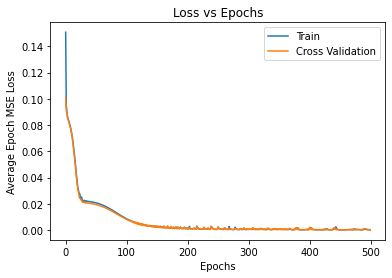

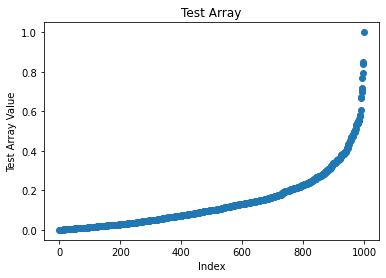

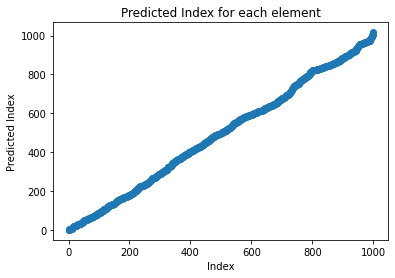

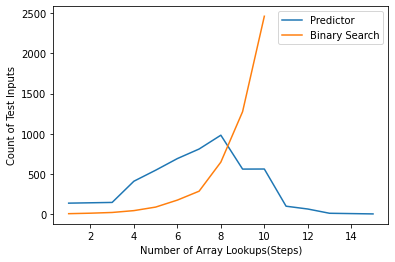

Average Number of Steps
Through Predictor:7.0298
Through Binary Search:8.9918


In [54]:
net_1=Net_1HL()
net_1.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='exponential')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='exponential')
train_dataset(net_1,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=500,lr=1e-3)
test_single_array(net_1,n,'exponential')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='exponential')
out=predict(net_1,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

  0%|          | 4/1000 [00:00<01:04, 15.47it/s]

0.1351035661995411
0.09247826337814331
0.08902624398469924
0.0873591423034668


  1%|          | 7/1000 [00:00<00:51, 19.16it/s]

0.08577670529484749
0.08458271622657776
0.08314531743526458
0.08111704960465431
0.07820836380124092


  1%|▏         | 13/1000 [00:00<00:44, 21.98it/s]

0.07378946542739868
0.06731670126318931
0.058935421705245974
0.05600589811801911
0.05538949631154537


  2%|▏         | 19/1000 [00:00<00:42, 22.88it/s]

0.03992539569735527
0.0321573693305254
0.026389859803020953
0.029455384984612466
0.02858928292989731


  2%|▏         | 22/1000 [00:01<00:42, 23.03it/s]

0.023246202059090136
0.021883604861795903
0.020363168604671956
0.02015940435230732
0.02023628484457731


  3%|▎         | 28/1000 [00:01<00:41, 23.35it/s]

0.020494754426181316
0.019794538058340548
0.02087120395153761
0.02067323066294193
0.01731320209801197


  3%|▎         | 34/1000 [00:01<00:41, 23.47it/s]

0.021092498302459718
0.018479345738887785
0.015165545046329498
0.02494509080424905
0.01904292544350028


  4%|▎         | 37/1000 [00:01<00:41, 23.40it/s]

0.016226495895534754
0.013788344897329807
0.012298053409904242
0.015837942250072956
0.012333670910447837


  4%|▍         | 43/1000 [00:01<00:40, 23.62it/s]

0.012055682949721813
0.019874726049602033
0.014345395006239414
0.01097843497991562
0.009389265347272158


  5%|▍         | 49/1000 [00:02<00:40, 23.57it/s]

0.008780830865725875
0.012011149805039168
0.00782720479182899
0.010276482300832867
0.015541331935673952


  5%|▌         | 52/1000 [00:02<00:40, 23.55it/s]

0.011094792699441313
0.00800593551248312
0.007255399646237492
0.006058056000620126
0.006466696271672845


  6%|▌         | 58/1000 [00:02<00:40, 23.55it/s]

0.006761413067579269
0.008297419454902411
0.007688035257160664
0.007452885340899229
0.006652229139581323


  6%|▋         | 64/1000 [00:02<00:39, 23.60it/s]

0.005638174759224057
0.006068827072158456
0.006586624402552843
0.006607450661249459
0.004949700809083879


  7%|▋         | 67/1000 [00:02<00:39, 23.61it/s]

0.005818487191572785
0.0047812279080972075
0.005066132615320384
0.005632352270185948
0.004936145641840995


  7%|▋         | 73/1000 [00:03<00:39, 23.71it/s]

0.004073448618873954
0.004541071364656091
0.005464154738001525
0.00440496951341629
0.0031539254589006303


  8%|▊         | 79/1000 [00:03<00:39, 23.61it/s]

0.00325511135160923
0.005986443255096674
0.004406641935929656
0.0031362790847197174
0.004145592916756868


  8%|▊         | 82/1000 [00:03<00:38, 23.62it/s]

0.004207234107889235
0.0040478602750226855
0.002689559001009911
0.004124118166510015
0.0032332670758478343


  9%|▉         | 88/1000 [00:03<00:38, 23.67it/s]

0.00265388626139611
0.002059656346682459
0.0016707559232600033
0.003681785287335515
0.00521374266827479


  9%|▉         | 94/1000 [00:04<00:38, 23.65it/s]

0.006508411292452365
0.004045697569381446
0.003388940857257694
0.0029901655972935258
0.0014794651884585618


 10%|▉         | 97/1000 [00:04<00:38, 23.75it/s]

0.0015846100286580622
0.0014706224552355706
0.0017066264059394597
0.001351501903263852
0.0012261621304787695


 10%|█         | 103/1000 [00:04<00:37, 23.65it/s]

0.0028851304086856544
0.00456611760891974
0.004923935676924884
0.0050069553428329526
0.0036317102611064913


 11%|█         | 109/1000 [00:04<00:37, 23.50it/s]

0.002716352388961241
0.0020433741679880767
0.0013089119747746736
0.0008145489147864283
0.0007088994432706385


 11%|█         | 112/1000 [00:04<00:37, 23.44it/s]

0.000584363762754947
0.0005885831720661372
0.0018864061799831688
0.001161357230739668
0.0016859085648320616


 12%|█▏        | 118/1000 [00:05<00:37, 23.49it/s]

0.00096375884313602
0.0025277785840444266
0.003796032187528908
0.003354783996473998
0.005869624041952193


 12%|█▏        | 124/1000 [00:05<00:37, 23.58it/s]

0.0030716162640601397
0.005620423040818423
0.0026116672204807402
0.0015308283152990043
0.0010890799923799932


 13%|█▎        | 127/1000 [00:05<00:36, 23.60it/s]

0.0006614788086153567
0.0004962548991898075
0.0003969040815718472
0.0004047314840136096
0.0003663901181425899


 13%|█▎        | 133/1000 [00:05<00:36, 23.44it/s]

0.0003528129163896665
0.0010731289919931441
0.0010045254428405314
0.0010457800584845246
0.0013876142154913395


 14%|█▍        | 139/1000 [00:05<00:36, 23.59it/s]

0.0017190248938277364
0.00424933263566345
0.0033498784934636204
0.003293579473393038
0.0023363216198049484


 14%|█▍        | 142/1000 [00:06<00:36, 23.48it/s]

0.0026781706197652965
0.00265079460805282
0.0013498969899956137
0.0011419135349569841
0.0004240432695951313


 15%|█▍        | 148/1000 [00:06<00:36, 23.59it/s]

0.00033421975094825027
0.0002788187906844541
0.0002938154299044982
0.00041374931461177764
0.0005175263242563233


 15%|█▌        | 154/1000 [00:06<00:35, 23.54it/s]

0.0003547937871189788
0.0007495003374060616
0.0011363998433807864
0.001111634573317133
0.0009416816727025434


 16%|█▌        | 157/1000 [00:06<00:35, 23.64it/s]

0.0009440424284548499
0.0015594942698953674
0.0038686572457663714
0.0037148192233871667
0.0028361212578602137


 16%|█▋        | 163/1000 [00:07<00:35, 23.68it/s]

0.0017354453273583203
0.0014271778316469863
0.0008251327060861513
0.00040531076228944585
0.0002871026357752271


 17%|█▋        | 169/1000 [00:07<00:35, 23.55it/s]

0.0003347459365613759
0.00023824073432479053
0.00043512594420462846
0.0006861736575956457
0.0004141728539252654


 17%|█▋        | 172/1000 [00:07<00:35, 23.38it/s]

0.0005867672938620671
0.00034207237913506103
0.0016686097165802493
0.0025094575161347167
0.007108539040200412


 18%|█▊        | 178/1000 [00:07<00:35, 23.42it/s]

0.0032105780905112625
0.0012731104565318675
0.0005777225858764723
0.0003850033608614467
0.00033673325669951736


 18%|█▊        | 184/1000 [00:07<00:34, 23.42it/s]

0.00028005404456052927
0.00020310950349085034
0.00016724196029827
0.00035954015620518474
0.0009907542407745495


 19%|█▊        | 187/1000 [00:08<00:34, 23.56it/s]

0.0004935309159918688
0.0012021811766317115
0.00159685121034272
0.0032365985738579185
0.0013873931049602107


 19%|█▉        | 193/1000 [00:08<00:34, 23.41it/s]

0.0003829413020866923
0.00022513545409310609
0.00024359129602089525
0.00022660299437120556
0.0010461328405654059


 20%|█▉        | 199/1000 [00:08<00:33, 23.62it/s]

0.000754042855987791
0.00037166658003116024
0.0005191596326767467
0.0014482815051451326
0.0009494182988419198


 20%|██        | 202/1000 [00:08<00:33, 23.57it/s]

0.0016552522487472744
0.0034845601534470917
0.0015351590613136069
0.0027013286744477227
0.0014353634702274575


 21%|██        | 208/1000 [00:08<00:33, 23.52it/s]

0.0006477462549810298
0.0010956169498967938
0.0015074873314006253
0.0019437699113041163
0.0012857012567110359


 21%|██▏       | 214/1000 [00:09<00:33, 23.54it/s]

0.0007995118532562629
0.00041915369656635447
0.0005758220286224969
0.0004670640715630725
0.00048753788869362327


 22%|██▏       | 217/1000 [00:09<00:33, 23.42it/s]

0.0002705577397136949
0.00022030339678167366
0.0005401121423346921
0.0002908750146161765
0.00045485607988666744


 22%|██▏       | 223/1000 [00:09<00:33, 23.47it/s]

0.00036396244177012705
0.0012811046181013808
0.0013862894513295033
0.0025377541256602853
0.0029145256674382837


 23%|██▎       | 229/1000 [00:09<00:32, 23.51it/s]

0.0023230339778820054
0.0017767469282262028
0.0016417118051322177
0.0007213637712993659
0.001180530560668558


 23%|██▎       | 232/1000 [00:09<00:32, 23.47it/s]

0.001338969761854969
0.0007939645467558876
0.0007656386223970912
0.0011226055183215066
0.0009095933084608987


 24%|██▍       | 238/1000 [00:10<00:32, 23.52it/s]

0.00042274827137589455
0.0006065945824957452
0.0005204569592024199
0.0008505303412675858
0.0018157196114771067


 24%|██▍       | 244/1000 [00:10<00:32, 23.45it/s]

0.0015816164115676657
0.000788082048529759
0.0009459096298087388
0.001045939396135509
0.0007157321175327525


 25%|██▍       | 247/1000 [00:10<00:31, 23.53it/s]

0.0010477444287971594
0.0012426133893313819
0.0005963274350506253
0.00025362943779327907
0.0001921092793054413


 25%|██▌       | 253/1000 [00:10<00:31, 23.64it/s]

0.00013564774271799252
0.00011872061004396528
0.00035365005387575363
0.0005504110289621167
0.0002592082310002297


 26%|██▌       | 259/1000 [00:11<00:31, 23.59it/s]

0.000389820706914179
0.00017275492791668512
0.00048369056021329014
0.0006278493710851762
0.0008347445022081956


 26%|██▌       | 262/1000 [00:11<00:31, 23.22it/s]

0.0009983759744500275
0.00034797516418620943
0.001177305968303699
0.001000734104309231
0.0005242688333964906


 27%|██▋       | 268/1000 [00:11<00:31, 23.38it/s]

0.000860513535735663
0.0002716060698730871
0.0001025106874294579
0.00016067764663603158
0.0017598913371330127


 27%|██▋       | 274/1000 [00:11<00:30, 23.48it/s]

0.0032626480373437517
0.006330455094575882
0.0023735941911581905
0.0010963760403683409
0.0004964670195477083


 28%|██▊       | 277/1000 [00:11<00:30, 23.50it/s]

0.0002287181225256063
0.00018761589672067203
0.0001255885057616979
0.00011502500783535651
0.00016853924898896366


 28%|██▊       | 283/1000 [00:12<00:30, 23.52it/s]

0.0013244501751614735
0.0016323582851327956
0.002033443936670665
0.0005503295571543277
0.000535985101305414


 29%|██▉       | 289/1000 [00:12<00:30, 23.34it/s]

0.0008548725338187069
0.0014864246288198047
0.0015778662578668444
0.00037898953014519065
0.0002459289004036691


 29%|██▉       | 292/1000 [00:12<00:30, 23.47it/s]

0.0001810971982195042
0.00012013843952445314
0.00010471096320543438
0.00018972651232616045
0.00045616895222337915


 30%|██▉       | 298/1000 [00:12<00:30, 23.38it/s]

0.00027477048206492327
0.0004462512086320203
0.0005607104700175114
0.0004077598474395927
0.0007212173470179551


 30%|███       | 304/1000 [00:13<00:29, 23.53it/s]

0.0003854631337162573
0.0005732991456170566
0.0003373978383024223
0.0004072025309142191
0.0013066515515674838


 31%|███       | 307/1000 [00:13<00:29, 23.51it/s]

0.0014924889008398167
0.002975748520111665
0.001614199683535844
0.0022341917152516543
0.0018771271163132042


 31%|███▏      | 313/1000 [00:13<00:29, 23.42it/s]

0.00089565839007264
0.0007111533719580621
0.000798529626626987
0.0012971600372111425
0.0013263596076285467


 32%|███▏      | 319/1000 [00:13<00:29, 23.44it/s]

0.0005886266037123278
0.0002551067620515823
0.0001647147633775603
0.00013828194933012127
9.841085557127371e-05


 32%|███▏      | 322/1000 [00:13<00:28, 23.49it/s]

9.136676162597723e-05
9.013240633066743e-05
0.00015548482115264052
0.00042856458312598986
0.0004197941023448948


 33%|███▎      | 328/1000 [00:14<00:28, 23.49it/s]

0.0004695807467214763
0.00018514040202717298
0.0007084414741257205
0.00048323505907319484
0.00039953140658326446


 33%|███▎      | 334/1000 [00:14<00:28, 23.51it/s]

0.0005745025409851223
0.00018272083980264142
0.0008816666246275418
0.0007880827935878188
0.0006214143257238902


 34%|███▎      | 337/1000 [00:14<00:28, 23.50it/s]

0.00047432985666091555
0.00016091112411231734
0.0011060338118113577
0.0008576377513236366
0.0005908793900744058


 34%|███▍      | 343/1000 [00:14<00:27, 23.57it/s]

0.00017796992469811812
0.0007478403655113653
0.0008828396057651844
0.0004290176555514336
0.0008036544335482176


 35%|███▍      | 349/1000 [00:14<00:27, 23.45it/s]

0.0007030989960185252
0.0005810322210891173
0.0008382405147131066
0.00048739197227405385
0.0010248044345644303


 35%|███▌      | 352/1000 [00:15<00:27, 23.51it/s]

0.0013697881920961663
0.0018892917461926118
0.0030577298864955084
0.0016346726537449286
0.0033000889816321433


 36%|███▌      | 358/1000 [00:15<00:27, 23.53it/s]

0.0013462850212818012
0.0015340525016654283
0.0013152608735254034
0.00035609216283774006
0.00020955226573278197


 36%|███▋      | 364/1000 [00:15<00:27, 23.39it/s]

0.00011393254608265125
0.00010827046717167831
7.710514837526717e-05
7.43814671295695e-05
0.00012728430665447376


 37%|███▋      | 367/1000 [00:15<00:27, 23.34it/s]

0.00041693513048812747
0.0002274344762554392
0.00024630801926832645
0.00044218203838681803
0.00034328926776652227


 37%|███▋      | 373/1000 [00:15<00:26, 23.41it/s]

0.0003840146600850858
0.0002517533393984195
0.00029004162570345215
0.000733636568475049
0.00026973117273882964


 38%|███▊      | 379/1000 [00:16<00:26, 23.46it/s]

0.00034380770375719294
0.00011202780733583495
0.0011239838189794683
0.0005606121994787827
0.0005909724291996099


 38%|███▊      | 382/1000 [00:16<00:26, 23.48it/s]

0.0002128120126144495
0.0006781047079130076
0.0008284547933726571
0.00043605276514426807
0.0008829333251924254


 39%|███▉      | 388/1000 [00:16<00:26, 23.39it/s]

0.0005545196836465038
0.0007675681888940744
0.0006515263157780282
0.0003491143863357138
0.0007160653360188008


 39%|███▉      | 394/1000 [00:16<00:25, 23.39it/s]

0.0005459885229356587
0.0004886943388555665
0.000458190162316896
0.0003686582880618516
0.0008252746745711192


 40%|███▉      | 397/1000 [00:16<00:25, 23.41it/s]

0.0004089648791705258
0.000684472918510437
0.000545999119640328
0.0004370529015432112
0.0007495647441828623


 40%|████      | 403/1000 [00:17<00:25, 23.44it/s]

0.00030719651840627193
0.00045959191847941836
0.0008642930559290107
0.00045219402963994073
0.0008838480687700212


 41%|████      | 409/1000 [00:17<00:25, 23.34it/s]

0.00042467940656933936
0.0007607481413288042
0.0005799987360660452
0.0004364101987448521
0.0002333504024136346


 41%|████      | 412/1000 [00:17<00:25, 23.43it/s]

0.0011658456875011324
0.0018843114608898758
0.0034666376566747205
0.0010726103268098087
0.00039908230683067815


 42%|████▏     | 418/1000 [00:17<00:24, 23.43it/s]

0.0003626899313530885
0.00015803830392542296
0.00016268085164483637
0.00043556203600019215
0.00048091370190377346


 42%|████▏     | 424/1000 [00:18<00:24, 23.48it/s]

0.0006365713990817313
0.00024375831853831186
0.0002308200033439789
0.00042758091585710646
0.0007406683871522546


 43%|████▎     | 427/1000 [00:18<00:24, 23.55it/s]

0.0004907448674202897
0.0002906182598962914
0.00043252006362308747
0.0008024486225622241
0.0005213326046941801


 43%|████▎     | 433/1000 [00:18<00:24, 23.48it/s]

0.000831042040954344
0.0007097838213667273
0.0005598464704235084
0.0008738396514672786
0.0006830358543084003


 44%|████▍     | 439/1000 [00:18<00:24, 23.37it/s]

0.0007468625633919145
0.00032220314315054563
0.0006050612966646441
0.0004709421293227933
0.00033434589713579046


 44%|████▍     | 442/1000 [00:18<00:23, 23.47it/s]

0.0002631254588777665
0.0005077227440779097
0.0007311566994758322
0.0004145924292970449
0.0006886659539304674


 45%|████▍     | 448/1000 [00:19<00:23, 23.60it/s]

0.0002110428613377735
0.0003959389840019867
0.0003067542056669481
0.0008324634967721067
0.0003201500105205923


 45%|████▌     | 454/1000 [00:19<00:23, 23.58it/s]

7.017280513537117e-05
0.0009440340123546776
0.0010168621432967485
0.0005251665170362685
0.0005645757250022143


 46%|████▌     | 457/1000 [00:19<00:23, 23.48it/s]

0.0003778667181904893
0.0004469427964068018
0.00045289931003935637
0.000745241713593714
0.0004449422762263566


 46%|████▋     | 463/1000 [00:19<00:23, 23.29it/s]

0.000349774746428011
0.0005539425990718882
0.0002385305313509889
0.0004208012120216154
0.0010512557986658067


 47%|████▋     | 469/1000 [00:20<00:22, 23.37it/s]

0.000471577474672813
0.000660773013078142
0.00041286272826255297
0.0002735750080319121
0.0008124188869260251


 47%|████▋     | 472/1000 [00:20<00:22, 23.44it/s]

0.00033092745507019573
0.0004608288647432346
0.0003753203091036994
0.0010060293672722765
0.000738479413848836


 48%|████▊     | 478/1000 [00:20<00:22, 23.19it/s]

0.0007226386573165655
0.0005763959830801469
0.00034660866222111506
0.00028459747481974774
0.0009499434090685099


 48%|████▊     | 484/1000 [00:20<00:22, 23.26it/s]

0.00037938188324915245
0.000586563850811217
0.0005326537881046534
0.0005455486054415815
0.00045314917151699773


 49%|████▊     | 487/1000 [00:20<00:22, 23.15it/s]

0.0004767717706272379
0.0004349699927843176
0.0002287813971634023
0.0006342188375128899
0.00045085466845193876


 49%|████▉     | 493/1000 [00:21<00:21, 23.33it/s]

0.0007148580087232403
0.00043310303590260446
0.0005589515618339647
0.0005247421860985924
0.0004339041995990556


 50%|████▉     | 499/1000 [00:21<00:21, 23.30it/s]

0.00046320982291945254
0.00027796059948741457
0.0006767283004592173
0.0004442737830686383
0.0006886601986479945


 50%|█████     | 502/1000 [00:21<00:21, 23.12it/s]

0.00045116660548956135
0.0004789480866747908
0.0006645073721301742
0.0004297145795135293
0.00033369034426868895


 51%|█████     | 508/1000 [00:21<00:21, 23.25it/s]

0.0003621655072493013
0.0006997441276325844
0.00041253997187595814
0.0006219552014954388
0.0004990414781786967


 51%|█████▏    | 514/1000 [00:21<00:20, 23.16it/s]

0.00041225360619137066
0.0003985888099123258
0.000335143918346148
0.0008339579129824415
0.0005087132987682708


 52%|█████▏    | 517/1000 [00:22<00:20, 23.06it/s]

0.00033164439737447536
0.0009353824876598083
0.0003007240513397846
0.0005017776347813196
0.0004549616911390331


 52%|█████▏    | 523/1000 [00:22<00:20, 23.15it/s]

0.0004184394107141998
0.0007620597090863157
0.00039738483756082135
0.000340125075308606
0.0005784096058050637


 53%|█████▎    | 529/1000 [00:22<00:20, 23.27it/s]

0.0005080831149825826
0.00018911819715867751
0.0007938033355458174
0.00043013141039409674
0.0006611344302655198


 53%|█████▎    | 532/1000 [00:22<00:20, 23.25it/s]

0.00044104757471359336
0.00041909652718459257
0.0004411041707498953
0.00026076099602505564
0.0007154689395974856


 54%|█████▍    | 538/1000 [00:23<00:19, 23.38it/s]

0.00034681630349950863
0.0009754148391948547
0.0005226387133006938
0.0005506124638486653
0.00034323968866374345


 54%|█████▍    | 544/1000 [00:23<00:19, 23.31it/s]

0.00032335830328520385
0.00017952734051505104
0.0004742674354929477
0.00036146466663922183
0.0005384408577810973


 55%|█████▍    | 547/1000 [00:23<00:19, 23.32it/s]

0.00044970334492973053
0.0002524848074244801
0.000917257700348273
0.0005021875731472392
0.00029747528678853997


 55%|█████▌    | 553/1000 [00:23<00:19, 23.38it/s]

0.0005474217628943734
0.00045937059257994406
0.0007076049791066907
0.00036890531700919384
0.00044373947530402803


 56%|█████▌    | 559/1000 [00:23<00:19, 23.06it/s]

0.0005768735587480478
0.0005528388071979861
0.0005003562124329619
0.000523257722670678
0.0004137163981795311


 56%|█████▌    | 562/1000 [00:24<00:18, 23.10it/s]

0.0003589090418245178
0.0006132018250355031
0.0003512839422910474
0.0002987647421832662
0.00034093338035745546


 57%|█████▋    | 568/1000 [00:24<00:18, 23.02it/s]

0.0005959969304967672
0.00042023255809908733
0.0006022554443916306
0.0003415244529605843
0.00045177313004387545


 57%|█████▋    | 574/1000 [00:24<00:18, 23.20it/s]

0.0006440004959586077
0.0003985133007518016
0.00027942511878791264
0.00034490706530050376
0.0003368548714206554


 58%|█████▊    | 577/1000 [00:24<00:18, 23.29it/s]

0.0006485093115770723
0.0005008220628951676
0.00034333876246819275
0.0002865046575607266
0.0009450518307858146


 58%|█████▊    | 583/1000 [00:24<00:18, 23.08it/s]

0.00041122673646896144
0.00038167234451975675
0.00041265199761255646
0.00046077815859462133
0.0003920091206964571


 59%|█████▉    | 589/1000 [00:25<00:17, 23.20it/s]

0.00031060294422786684
0.0003758637554710731
0.00026961185612890405
0.0007133391511160881
0.0005760245439887512


 59%|█████▉    | 592/1000 [00:25<00:17, 23.17it/s]

0.0003593628083763178
0.00039000180986477063
0.0004327737929997966
0.00048750500645837745
0.00044033175581716935


 60%|█████▉    | 598/1000 [00:25<00:17, 23.22it/s]

0.0005233818774286192
0.0004184776291367598
0.0004374257347080857
0.0004613652352418285
0.00038769811289967037


 60%|██████    | 604/1000 [00:25<00:17, 23.26it/s]

0.0004208193298836704
0.000320916753844358
0.00037466717403731307
0.0003495295371976681
0.0003575728755095042


 61%|██████    | 607/1000 [00:26<00:16, 23.23it/s]

0.0005921265423239674
0.000505799925304018
0.00035299344162922355
0.0005083958480099682
0.0006712208429235034


 61%|██████▏   | 613/1000 [00:26<00:16, 23.29it/s]

0.0003500059247016907
0.00031377056948258544
0.00045117816480342297
0.0003121117588307243
0.00041307608917122706


 62%|██████▏   | 619/1000 [00:26<00:16, 23.28it/s]

0.0002621627048938535
0.0005889019186724909
0.0006387257752066943
0.0004328666916990187
0.0003745830344996648


 62%|██████▏   | 622/1000 [00:26<00:16, 23.25it/s]

0.000432726970029762
0.0002825315044901799
0.00046735489158891144
0.0003876264585414901
0.0005304219099343755


 63%|██████▎   | 628/1000 [00:26<00:15, 23.35it/s]

0.00043552985807764343
0.0004198067996185273
0.0004606688606145326
0.0003727207251358777
0.0004304398280510213


 63%|██████▎   | 634/1000 [00:27<00:15, 23.01it/s]

0.00045517213802668264
0.00041294967086287216
0.00033771306843846107
0.00027729093126254155
0.0004201004281640053


 64%|██████▎   | 637/1000 [00:27<00:15, 23.17it/s]

0.0003397665495867841
0.0003087204153416678
0.0004768548926222138
0.0004743204772239551
0.00044227552571101113


 64%|██████▍   | 643/1000 [00:27<00:15, 23.23it/s]

0.0004983170234481804
0.00042142453748965635
0.0005070033752417657
0.00031099109182832765
0.0005289561850077007


 65%|██████▍   | 649/1000 [00:27<00:14, 23.44it/s]

0.0004888104493147693
0.0004254904539266136
0.00029100916726747527
0.00026186208851868286
0.0003889234380039852


 65%|██████▌   | 652/1000 [00:27<00:15, 23.17it/s]

0.0003490659284580033
0.00030721166403964163
0.0004021246983029414
0.00041902004668372685
0.0004705166771600489


 66%|██████▌   | 658/1000 [00:28<00:14, 23.31it/s]

0.0004839256376726553
0.0004279605651390739
0.0004995226197934243
0.0003697806940181181
0.0005293827787681948


 66%|██████▋   | 664/1000 [00:28<00:14, 23.27it/s]

0.0003300593249150552
0.000522896605252754
0.0003853833019093145
0.00045904630023869687
0.00031063602727954276


 67%|██████▋   | 667/1000 [00:28<00:14, 23.30it/s]

0.0004619140330760274
0.00039216926743392835
0.0004326996837335173
0.00032309388188878074
0.00042294297891203313


 67%|██████▋   | 673/1000 [00:28<00:14, 23.18it/s]

0.0003726588052813895
0.00045609302324010057
0.00034095817100023853
0.0004540431466011796
0.0003680253590573557


 68%|██████▊   | 679/1000 [00:29<00:13, 23.21it/s]

0.00044099294827901756
0.0003258598233514931
0.0004526696553512011
0.0003600488758820575
0.00043602052901405843


 68%|██████▊   | 682/1000 [00:29<00:13, 23.10it/s]

0.0003299456730019301
0.0004369711306935642
0.0003511663162498735
0.00043880581288249234
0.0003382598952157423


 69%|██████▉   | 688/1000 [00:29<00:13, 23.08it/s]

0.00043445832270663234
0.00034525269802543335
0.00042973939489456827
0.0003417154810449574
0.0004293997692002449


 69%|██████▉   | 694/1000 [00:29<00:13, 23.14it/s]

0.0003480552572000306
0.00042481367199798115
0.00034558088227640835
0.0004309297764848452
0.0003443125358899124


 70%|██████▉   | 697/1000 [00:29<00:13, 22.93it/s]

0.0004278228894690983
0.00034584078384796156
0.00043463278270792214
0.0003399868706765119
0.00043231335876043887


 70%|███████   | 703/1000 [00:30<00:12, 22.96it/s]

0.0003445313464908395
0.0004248090925102588
0.0003433237194258254
0.0004279356078768615
0.0003402841655770317


 71%|███████   | 709/1000 [00:30<00:12, 23.03it/s]

0.00042304451562813483
0.0003441305598244071
0.00041633464497863314
0.0003430048258451279
0.0004190339328488335


 71%|███████   | 712/1000 [00:30<00:12, 23.04it/s]

0.0003435642058320809
0.00041938852373277766
0.00034071973714162597
0.00041882874429575165
0.0003409229939279612


 72%|███████▏  | 718/1000 [00:30<00:12, 23.04it/s]

0.00041690368598210623
0.00033614849526202305
0.0004079146558069624
0.00034001249878201634
0.00040846114861778913


 72%|███████▏  | 724/1000 [00:31<00:12, 22.94it/s]

0.0003467328737315256
0.0003981566485890653
0.0003437272302107885
0.0004095419935765676
0.00034754948428599163


 73%|███████▎  | 727/1000 [00:31<00:11, 23.00it/s]

0.00039504812084487637
0.00034861183812608945
0.00040040761086856946
0.000345787364494754
0.00039386237840517425


 73%|███████▎  | 733/1000 [00:31<00:11, 23.02it/s]

0.0003517139877658337
0.00039382246250170284
0.0003492531010124367
0.00039605858182767406
0.0003475633115158416


 74%|███████▍  | 739/1000 [00:31<00:11, 23.17it/s]

0.00039167936629382896
0.00034876783975050784
0.0003949440557335038
0.00034064883657265456
0.00039415072023984976


 74%|███████▍  | 742/1000 [00:31<00:11, 23.21it/s]

0.0003495020675472915
0.0003881117569108028
0.00033612397164688445
0.0003983189846621826
0.00034605474866111763


 75%|███████▍  | 748/1000 [00:32<00:10, 23.17it/s]

0.00038134230053401554
0.0003394566825591028
0.0003965518240875099
0.0003460956570052076
0.0003798107136390172


 75%|███████▌  | 754/1000 [00:32<00:10, 22.94it/s]

0.0003397410284378566
0.000384754707920365
0.0003443542147579137
0.00038711861707270147
0.000335130094026681


 76%|███████▌  | 757/1000 [00:32<00:10, 23.01it/s]

0.00038481851734104564
0.00033604312338866296
0.00039331424777628855
0.0003356686902407091
0.00038208184923860244


 76%|███████▋  | 763/1000 [00:32<00:10, 23.19it/s]

0.00033780471349018624
0.00038331792238750496
0.0003355157285113819
0.0003746253227291163
0.00032815654121804984


 77%|███████▋  | 769/1000 [00:33<00:10, 22.89it/s]

0.00037456542559084484
0.0003258322190959007
0.00037637866553268394
0.0003314698908070568
0.00037813533926964735


 77%|███████▋  | 772/1000 [00:33<00:09, 22.99it/s]

0.0003306653583422303
0.00037653451654477975
0.0003314398927614093
0.00037682395050069316
0.0003316318332508672


 78%|███████▊  | 778/1000 [00:33<00:09, 23.14it/s]

0.00037559128541033717
0.0003274558242992498
0.0003787963134527672
0.00033208349268534223
0.0003719311498571187


 78%|███████▊  | 784/1000 [00:33<00:09, 23.24it/s]

0.0003217206689441809
0.00038175385343492964
0.00032548688250244595
0.0003687141681439243
0.00032701927739253733


 79%|███████▊  | 787/1000 [00:33<00:09, 23.18it/s]

0.00036898539401590823
0.00032898204954108224
0.0003681867427076213
0.00032310371316270905
0.0003775165001570713


 79%|███████▉  | 793/1000 [00:34<00:08, 23.12it/s]

0.0003218386867956724
0.00036807443684665485
0.000322848156793043
0.000374929302779492
0.0003168045237543993


 80%|███████▉  | 799/1000 [00:34<00:08, 23.03it/s]

0.0003789420035900548
0.00032114151654241143
0.00039430190445273184
0.0003295678208814934
0.0003659799498564098


 80%|████████  | 802/1000 [00:34<00:08, 23.10it/s]

0.00032663621313986366
0.00036453919892665
0.0003131914294499438
0.0003532360555254854
0.00031805495818844066


 81%|████████  | 808/1000 [00:34<00:08, 23.12it/s]

0.0003712147612532135
0.00031784509410499596
0.00035998145322082566
0.0003170050425978843
0.00036825300194323065


 81%|████████▏ | 814/1000 [00:34<00:08, 23.09it/s]

0.0003065665368922055
0.0003616949208662845
0.00031608225217496513
0.00036117741183261387
0.00031097747887542937


 82%|████████▏ | 817/1000 [00:35<00:07, 23.00it/s]

0.00035311042665853165
0.0003179697781888535
0.0003683344817545731
0.00031288498212234117
0.0003698937507579103


 82%|████████▏ | 823/1000 [00:35<00:07, 23.15it/s]

0.0003001821678481065
0.0003869421525450889
0.0002967763226479292
0.00038616942038061097
0.0003030315070645884


 83%|████████▎ | 829/1000 [00:35<00:07, 23.13it/s]

0.00037563280857284554
0.0002913974691182375
0.00035776562144747005
0.0002960046273074113
0.00035342393966857343


 83%|████████▎ | 832/1000 [00:35<00:07, 23.20it/s]

0.0002885716952732764
0.00035688345014932564
0.0003001474309712648
0.0003635969180322718
0.0002963354039820842


 84%|████████▍ | 838/1000 [00:36<00:06, 23.16it/s]

0.0003655611522844993
0.00030705436802236363
0.00035758496378548445
0.0002935307726147585
0.0003443710109422682


 84%|████████▍ | 844/1000 [00:36<00:06, 22.92it/s]

0.0003013081084645819
0.0003408858028706163
0.0003006850471138023
0.00034662086618482136
0.0003014609741512686


 85%|████████▍ | 847/1000 [00:36<00:06, 23.00it/s]

0.0003605592923122458
0.00030394409113796426
0.00035950357632827943
0.0002997506300744135
0.00034211734164273365


 85%|████████▌ | 853/1000 [00:36<00:06, 23.09it/s]

0.000293076153320726
0.00033328773643006573
0.00028426537464838476
0.00032565429828537165
0.0002756820005743066


 86%|████████▌ | 859/1000 [00:36<00:06, 23.17it/s]

0.00032436653382319494
0.00025925440204446206
0.0002895232570153894
0.00023204318385978696
0.0001404994953190908


 86%|████████▌ | 862/1000 [00:37<00:05, 23.13it/s]

0.00037382898008218033
0.0002620616913191043
0.0004046992304211017
0.0004048672490171157
0.0004604977701092139


 87%|████████▋ | 868/1000 [00:37<00:05, 22.95it/s]

0.000322409906948451
0.0004137278338021133
0.00028779403801308944
0.0003112938724370906
0.0002347453533730004


 87%|████████▋ | 874/1000 [00:37<00:05, 23.01it/s]

0.00016486788081238046
0.00020881469099549578
0.0003095601772656664
0.0002498027723049745
0.00024553105686209165


 88%|████████▊ | 877/1000 [00:37<00:05, 23.06it/s]

0.0002711689048737753
0.0002307203259988455
0.0003708094631292624
0.0004517570661846548
0.000434209644299699


 88%|████████▊ | 883/1000 [00:37<00:05, 23.03it/s]

0.0004068317619385198
0.00028788253766833807
0.0002712724839511793
0.00019857557672366965
0.00019301728607388214


 89%|████████▉ | 889/1000 [00:38<00:04, 23.13it/s]

0.0003826411601039581
0.00028945537014806176
0.00034248835072503425
0.00037034950146335176
0.00037408387288451195


 89%|████████▉ | 892/1000 [00:38<00:04, 23.12it/s]

0.0002500172155123437
0.00025727938227646516
0.00036918170808348806
0.0002830591150996042
0.00022527162509504705


 90%|████████▉ | 898/1000 [00:38<00:04, 23.02it/s]

0.00013265422930999193
0.0003614123234001454
0.00048614970946800893
0.000439024216029793
0.00029614216036861763


 90%|█████████ | 904/1000 [00:38<00:04, 23.06it/s]

0.00037157686383579855
0.0004045840396429412
0.00037012859829701485
0.0002477302863553632
0.00035348436067579315


 91%|█████████ | 907/1000 [00:38<00:04, 23.13it/s]

0.00021528349025174976
0.00011652281064016279
0.0003168270610331092
0.0001894061584607698
6.944315719010774e-05


 91%|█████████▏| 913/1000 [00:39<00:03, 23.02it/s]

0.0006260757370910141
0.0004423804544785526
0.00031798131167306567
0.0004156260780291632
0.00038044498942326756


 92%|█████████▏| 919/1000 [00:39<00:03, 22.99it/s]

0.0002496418543159962
0.0002844106282282155
0.00019216924338252283
0.00014448853507929016
0.0002775215485598892


 92%|█████████▏| 922/1000 [00:39<00:03, 22.99it/s]

0.0001804960054869298
0.000143200311504188
0.00044865497620776295
0.0003569427732145414
0.00040741150223766454


 93%|█████████▎| 928/1000 [00:39<00:03, 23.04it/s]

0.00029616142419399696
0.00020799884005100465
0.00023811451355868485
0.00023704029845248443
0.0003853426067507826


 93%|█████████▎| 934/1000 [00:40<00:02, 22.95it/s]

0.0003049159568035975
0.00039302775112446395
0.00030100210933596826
0.0003423649919568561
0.0002176191257603932


 94%|█████████▎| 937/1000 [00:40<00:02, 23.06it/s]

0.00016025111362978351
0.00022312233049888165
0.0002888105416786857
0.00027023498914786616
0.0002762379823252559


 94%|█████████▍| 943/1000 [00:40<00:02, 23.18it/s]

0.0003096111951890634
0.00025874909406411464
0.0002363888230320299
0.00018190885057265405
0.00038165614532772454


 95%|█████████▍| 949/1000 [00:40<00:02, 23.22it/s]

0.00029785524966428054
0.0003582222881959751
0.00044724474573740733
0.0003328040358610451
0.00033732405718183144


 95%|█████████▌| 952/1000 [00:40<00:02, 23.18it/s]

0.00024133379629347472
0.00022534782729053405
0.0001386573367199162
0.00031220659184327815
0.00026411011567688546


 96%|█████████▌| 958/1000 [00:41<00:01, 22.76it/s]

0.0002724189471337013
0.00034596475015860053
0.000364462798461318
0.0003362597606610507
0.00024164472742995712


 96%|█████████▋| 964/1000 [00:41<00:01, 22.92it/s]

0.00021946556007605976
0.000224181199882878
0.0001579055289766984
0.0003605620098824147
0.00022430445242207497


 97%|█████████▋| 967/1000 [00:41<00:01, 23.06it/s]

0.00023180854768725112
0.0004056483470776584
0.000370736769400537
0.00027162432197656015
0.00025557894077792297


 97%|█████████▋| 973/1000 [00:41<00:01, 23.06it/s]

0.00033170021124533377
0.0003293858637334779
0.00020140308479312807
9.936610331351403e-05
0.00035326650031493046


 98%|█████████▊| 979/1000 [00:42<00:00, 23.14it/s]

0.00025596790910640264
0.00036586040805559606
0.0002940222679171711
0.00034648759319679814
0.00041964280753745695


 98%|█████████▊| 982/1000 [00:42<00:00, 21.69it/s]

0.0004034393401525449
0.0002159744421078358
0.0003964782146795187
0.00027804367418866606


 98%|█████████▊| 985/1000 [00:42<00:00, 17.57it/s]

0.00034181544215243774
0.00019065609158133156
0.00035691882549144794


 99%|█████████▉| 990/1000 [00:42<00:00, 18.47it/s]

0.00036133634566795083
0.00034803010858013294
0.00023863664755481296
0.00022183743276400493
0.00012813676294172184


100%|█████████▉| 996/1000 [00:43<00:00, 20.64it/s]

9.198574116453528e-05
0.0003790414077229798
0.00021827103846590036
0.0002072904106171336
0.00022027660488674883


100%|██████████| 1000/1000 [00:43<00:00, 23.10it/s]

0.00026387267098471057
0.00017479549096606207
0.00028437635155569295
0.00017512177873868495


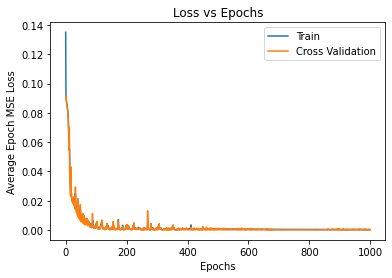

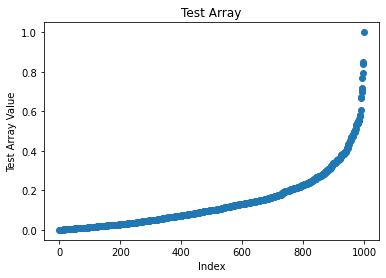

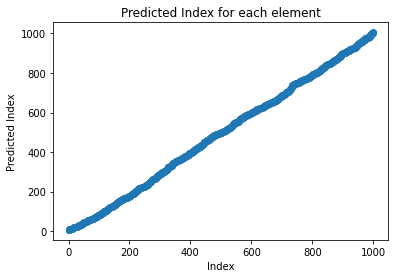

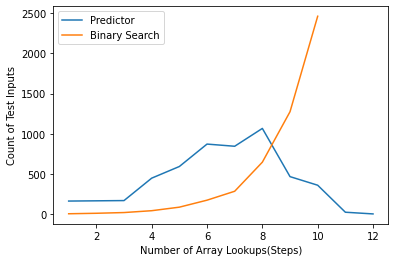

Average Number of Steps
Through Predictor:6.6274
Through Binary Search:8.9918


In [55]:
net_2=Net_2HL()
net_2.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='exponential')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='exponential')
train_dataset(net_2,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=1000,lr=1e-3)
test_single_array(net_2,n,'exponential')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='exponential')
out=predict(net_2,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

#Mixed

  4%|▍         | 22/500 [00:00<00:04, 105.02it/s]

0.16187936887145044
0.12302646711468697
0.10842288359999656
0.09939699321985244
0.09268272295594215
0.08808867782354354
0.08490701541304588
0.08268810957670211
0.08111533895134926
0.07988587468862533
0.07884474769234658
0.07788979709148407
0.07696797326207161
0.07606293186545372
0.07516558542847633
0.07427405416965485
0.07338829711079597
0.07250894531607628
0.07163640558719635
0.07077108472585678
0.0699131391942501
0.06906301379203797


  9%|▉         | 44/500 [00:00<00:04, 103.80it/s]

0.06822085827589035
0.06738688796758652
0.06656132191419602
0.06574432104825974
0.06493604630231857
0.06413666233420372
0.06334632150828838
0.0625651866197586
0.061793404072523116
0.06103112623095512
0.06027849540114403
0.059535615518689154
0.058802537992596625
0.05807921700179577
0.05736546106636524
0.05666091330349445
0.05596500262618065
0.055276987701654436
0.05459596440196037
0.053920922428369523
0.053250792995095254
0.052584574371576306


 11%|█         | 55/500 [00:00<00:04, 100.18it/s]

0.05192156098783016
0.05126181356608868
0.050606579333543775
0.04995833002030849
0.04932005368173122
0.048693948239088056
0.048080473020672795
0.047478436678648
0.04688606411218643
0.046302128955721854
0.04572632387280464
0.04515878446400166
0.04459949843585491
0.0440482497215271
0.04350486546754837
0.04296927563846111
0.042441404238343236
0.041921157762408255
0.04140845611691475
0.040903227776288985
0.040405403822660446


 15%|█▌        | 77/500 [00:00<00:04, 100.35it/s]

0.039914916083216664
0.03943170458078384
0.03895569518208504
0.03848683647811413
0.038025060296058656
0.03757030181586742
0.03712250851094723
0.03668162748217583
0.036247589811682704
0.03582034148275852
0.0353998314589262
0.03498600535094738
0.034578817710280416
0.03417820148169994
0.033784106746315955
0.03339648507535457
0.03301528915762901
0.03264046125113964
0.03227195627987385
0.03190972227603197
0.0315537104383111


 20%|█▉        | 99/500 [00:00<00:03, 102.17it/s]

0.031203871965408324
0.030860156752169132
0.03052250761538744
0.030190872400999068
0.029865194857120515
0.029545412212610245
0.02923146151006222
0.02892328128218651
0.028620796836912633
0.028323926962912083
0.02803258579224348
0.027746681682765485
0.027466123923659325
0.02719079554080963
0.026920593716204165
0.026655402220785617
0.026395105011761188
0.026139582693576812
0.0258887218311429
0.025642400979995726
0.025400512106716632
0.02516295276582241


 24%|██▍       | 121/500 [00:01<00:03, 104.11it/s]

0.024929622560739516
0.024700435623526574
0.024475314281880857
0.024254186265170573
0.02403699401766062
0.02382368464022875
0.02361421175301075
0.023408534936606884
0.023206620290875436
0.023008432053029538
0.022813938558101654
0.02262311112135649
0.022435922361910342
0.022252341173589228
0.022072338685393333
0.021895877830684186
0.021722928062081336
0.021553456969559192
0.0213874239474535
0.021224793046712875
0.02106552869081497
0.020909580029547216


 29%|██▊       | 143/500 [00:01<00:03, 103.79it/s]

0.020756909064948557
0.020607476681470872
0.020461239852011204
0.02031815182417631
0.020178167894482613
0.02004123795777559
0.019907322153449057
0.019776375591754915
0.01964834686368704
0.01952318921685219
0.01940086130052805
0.019281313940882682
0.01916450522840023
0.019050382450222968
0.018938904255628587
0.018830023892223834
0.01872369460761547
0.018619872257113458
0.018518512323498725
0.01841957550495863
0.0183230122551322


 33%|███▎      | 165/500 [00:01<00:03, 101.63it/s]

0.018228779546916485
0.01813684292137623
0.01804715543985367
0.017959664575755596
0.01787433996796608
0.01779113560914993
0.017710011266171933
0.017630926333367825
0.017553847283124924
0.01747872531414032
0.017405520007014275
0.01733419895172119
0.017264722660183907
0.017197056487202645
0.017131160758435727
0.017066998593509197
0.017004534788429736
0.0169437313452363
0.016884557902812958
0.01682697534561157


 37%|███▋      | 187/500 [00:01<00:03, 102.44it/s]

0.016770953126251698
0.016716453060507775
0.016663447208702564
0.016611898317933083
0.01656177397817373
0.01651304345577955
0.016465677320957182
0.01641964502632618
0.016374914534389974
0.016331452876329422
0.016289233695715666
0.01624822663143277
0.0162084074690938
0.016169740725308655
0.016132206097245215
0.01609577527269721
0.016060418076813222
0.01602610871195793
0.01599282119423151
0.01596053410321474
0.01592922080308199
0.015898857172578572


 42%|████▏     | 209/500 [00:02<00:02, 104.45it/s]

0.01586941732093692
0.01584087824448943
0.015813213493674993
0.015786402206867934
0.0157604300417006
0.015735263749957085
0.01571088973432779
0.01568728471174836
0.01566442484036088
0.015642293822020294
0.015620872937142849
0.01560013685375452
0.015580069739371538
0.01556065445765853
0.015541873686015607
0.01552370646968484
0.015506135765463114
0.015489146485924721
0.015472722426056861
0.015456845052540302
0.015441496483981609
0.015426665730774402


 46%|████▌     | 231/500 [00:02<00:02, 104.06it/s]

0.01541233817115426
0.015398492105305195
0.015385116171091794
0.015372197516262532
0.015359725896269083
0.01534768072888255
0.015336051769554614
0.015324827656149865
0.015313995815813542
0.015303540322929621
0.015293450746685266
0.015283716935664415
0.01527432892471552
0.015265273675322533
0.015256536938250066
0.015248115267604589
0.015239994321018458
0.015232162829488517
0.015224615205079317
0.015217339806258678
0.015210326015949249
0.015203566662967205


 51%|█████     | 253/500 [00:02<00:02, 104.64it/s]

0.015197052713483572
0.015190774202346801
0.01518472982570529
0.015178905241191388
0.015173292998224498
0.015167887229472399
0.015162679925560951
0.015157665871083737
0.015152837336063384
0.015148188546299934
0.01514370832592249
0.01513939518481493
0.015135239344090223
0.015131239965558051
0.015127390343695878
0.015123681444674731
0.015120112430304289
0.01511667612940073
0.015113366395235061
0.015110177826136351
0.015107108931988477
0.01510415580123663


 55%|█████▌    | 275/500 [00:02<00:02, 101.71it/s]

0.015101310424506664
0.015098568703979253
0.01509593017399311
0.015093388129025697
0.015090940706431865
0.0150885839946568
0.015086311474442482
0.015084124449640513
0.015082016866654158
0.015079986490309238
0.015078028105199337
0.01507614115253091
0.015074321068823338
0.01507256543263793
0.015070873219519854
0.015069244429469109
0.015067673102021218
0.015066155046224595
0.01506468839943409
0.015063274092972279
0.015061910729855299


 59%|█████▉    | 297/500 [00:02<00:01, 103.42it/s]

0.01506059467792511
0.015059319604188205
0.01505808774381876
0.01505690161138773
0.015055751893669367
0.01505464082583785
0.015053566265851259
0.01505252430215478
0.015051520895212889
0.015050547383725642
0.01504960423335433
0.015048692096024751
0.015047810599207878
0.015046952851116657
0.01504612285643816
0.015045317728072405
0.015044535975903273
0.015043776948004961
0.015043038967996835
0.015042321663349867
0.0150416262447834
0.01504095047712326


 64%|██████▍   | 319/500 [00:03<00:01, 102.79it/s]

0.01504029482603073
0.015039655193686486
0.015039032325148582
0.01503842631354928
0.015037837624549865
0.015037261415272951
0.015036702435463668
0.015036156214773656
0.015035623777657747
0.015035106614232064
0.015034599136561156
0.015034104790538549
0.01503361975774169
0.015033146645873786
0.015032685641199351
0.015032233949750663
0.015031789802014828
0.01503135720267892
0.015030933916568756
0.015030519384890795
0.015030112583190203


 68%|██████▊   | 341/500 [00:03<00:01, 104.36it/s]

0.015029715280979872
0.015029326640069484
0.015028942469507455
0.015028565283864736
0.015028197690844536
0.01502783689647913
0.015027481503784657
0.015027131978422403
0.015026789158582687
0.015026452951133251
0.01502612205222249
0.015025794785469771
0.015025475155562162
0.015025161020457745
0.015024850703775882
0.015024545509368182
0.01502424655482173
0.015023950207978486
0.015023659728467465
0.015023372322320937
0.015023089107125997
0.015022809710353613


 73%|███████▎  | 363/500 [00:03<00:01, 102.90it/s]

0.015022534132003783
0.015022262837737799
0.015021996293216943
0.015021732542663813
0.015021472424268722
0.015021217614412307
0.0150209647603333
0.015020715817809106
0.015020469669252634
0.015020224172621966
0.015019982121884823
0.015019743517041207
0.015019509289413691
0.015019276458770037
0.015019047539681196
0.01501882253214717
0.015018600225448608
0.015018377918750048
0.015018160361796618
0.015017942804843188
0.015017729066312314


 77%|███████▋  | 385/500 [00:03<00:01, 103.14it/s]

0.015017516724765301
0.0150173076428473
0.01501709958538413
0.01501689525321126
0.015016692411154508
0.015016493666917086
0.015016297996044158
0.015016101766377687
0.015015908796340228
0.015015716198831797
0.015015526488423348
0.015015338081866503
0.015015151631087065
0.015014967415481806
0.015014784969389438
0.015014605224132537
0.01501442864537239
0.015014252439141274
0.015014077443629504
0.015013903565704822
0.015013731829822064
0.015013562608510255


 81%|████████▏ | 407/500 [00:03<00:00, 103.58it/s]

0.015013396926224231
0.015013229567557573
0.015013063792139292
0.01501289764419198
0.015012733824551105
0.015012573637068271
0.015012413542717696
0.015012258384376764
0.015012104157358408
0.015011951886117458
0.015011798683553934
0.015011645201593638
0.015011494513601065
0.015011345408856869
0.015011199377477169
0.015011051576584578
0.015010909084230662
0.015010765008628368
0.015010622795671225
0.015010481048375369
0.015010342746973038


 86%|████████▌ | 429/500 [00:04<00:00, 104.60it/s]

0.015010205283761024
0.015010065864771605
0.015009931288659573
0.015009797737002372
0.015009666327387094
0.015009533334523439
0.015009400714188815
0.015009271632879972
0.015009140502661467
0.015009013470262289
0.015008886903524398
0.01500876024365425
0.015008635446429252
0.015008513815701008
0.015008392836898565
0.01500827046111226
0.015008148737251759
0.015008031204342843
0.015007913019508124
0.015007794369012117
0.015007677301764489
0.015007562097162008


 90%|█████████ | 451/500 [00:04<00:00, 104.36it/s]

0.015007449127733708
0.015007337741553783
0.01500722523778677
0.01500711115077138
0.015007000789046288
0.015006891451776028
0.015006782673299312
0.015006674639880657
0.015006567910313606
0.015006462950259447
0.015006357803940773
0.015006254892796278
0.015006152354180813
0.015006049443036318
0.015005948301404715
0.015005847997963428
0.015005749650299549
0.015005651395767927
0.015005550999194383
0.015005453210324048
0.015005356166511774


 95%|█████████▍| 473/500 [00:04<00:00, 101.98it/s]

0.015005260333418846
0.015005165804177522
0.015005071554332972
0.015004974789917469
0.015004883613437414
0.015004792809486389
0.015004702843725681
0.015004613995552063
0.015004520863294601
0.01500443061813712
0.01500434372574091
0.015004256181418896
0.01500416910275817
0.015004081465303899
0.015003996156156062
0.015003910847008228
0.01500382712110877
0.015003742929548026
0.015003658831119537
0.015003577806055546
0.015003496967256068


 97%|█████████▋| 484/500 [00:04<00:00, 100.69it/s]

0.015003415942192077
0.015003336407244206
0.015003254543989897
0.015003176964819431
0.015003100130707025
0.015003020968288183
0.015002944227308034
0.015002866089344025
0.015002787951380015
0.015002713073045015
0.015002639312297106
0.015002564061433077
0.015002492070198058
0.015002419427037238
0.01500234641134739
0.015002273675054311
0.01500220401212573
0.015002133511006831
0.01500206096097827
0.015001991670578719
0.015001920890063048


100%|██████████| 500/500 [00:04<00:00, 102.63it/s]


0.01500185215845704
0.015001784078776836
0.015001715905964375
0.01500164931640029
0.015001581516116858
0.01500151352956891


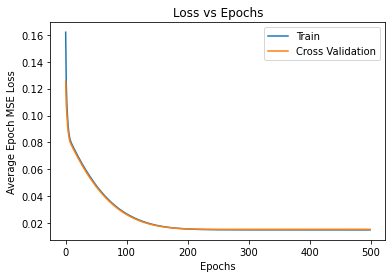

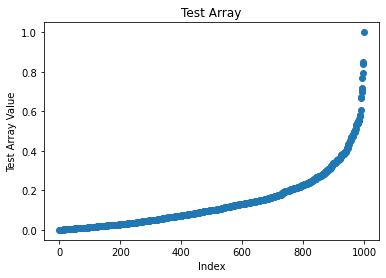

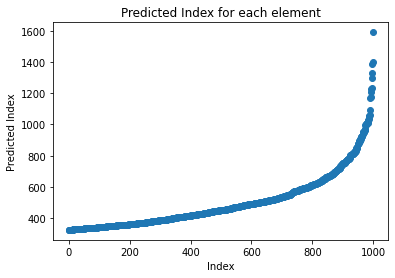

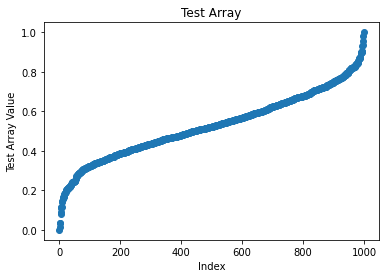

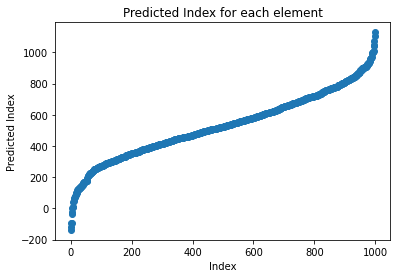

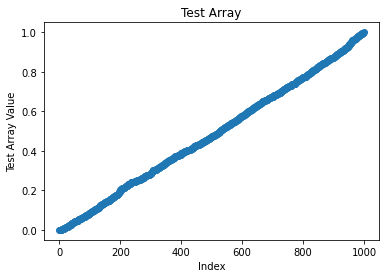

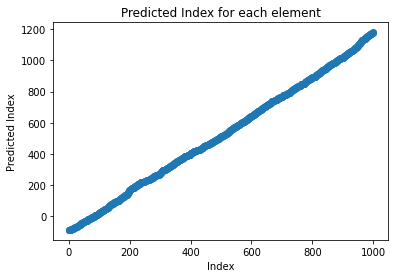

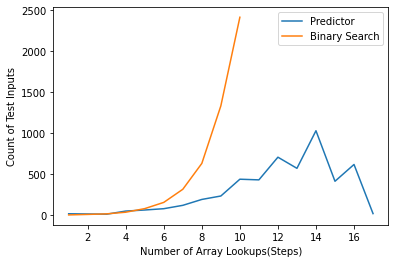

Average Number of Steps
Through Predictor:12.2916
Through Binary Search:9.0004


In [56]:
net=Net_NHL()
net.to('cuda')

train_unif,train_ans1=generate_dataset(17000,n,_type='uniform')
cv_unif,cv_ans1=generate_dataset(1700,n,_type='uniform')

train_normal,train_ans2=generate_dataset(17000,n,_type='normal')
cv_normal,cv_ans2=generate_dataset(1700,n,_type='normal')

train_exponential,train_ans3=generate_dataset(16000,n,_type='exponential')
cv_exponential,cv_ans3=generate_dataset(1600,n,_type='exponential')

train_input=torch.cat((train_unif,train_normal,train_exponential))
train_ans=torch.cat((train_ans1,train_ans2,train_ans3))
cv_input=torch.cat((cv_unif,cv_normal,cv_exponential))
cv_ans=torch.cat((cv_ans1,cv_ans2,cv_ans3))

shuffled_idx=torch.randperm(train_input.shape[0])
train_input=train_input[shuffled_idx]
train_ans=train_ans[shuffled_idx]

shuffled_idx1=torch.randperm(cv_input.shape[0])
cv_input=cv_input[shuffled_idx1]
cv_ans=cv_ans[shuffled_idx1]

train_dataset(net,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=500,lr=1e-3)
test_single_array(net,n,'exponential')
test_single_array(net,n,'normal')
test_single_array(net,n,'uniform')

np.random.seed(42)
test_unif,test_ans1=generate_dataset(1700,n,_type='uniform')
test_normal,test_ans2=generate_dataset(1700,n,_type='normal')
test_exponential,test_ans3=generate_dataset(1600,n,_type='exponential')

test_input=torch.cat((test_unif,test_normal,test_exponential))

shuffled_idx=torch.randperm(test_input.shape[0])
test_input=test_input[shuffled_idx]

out=predict(net,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)




  1%|          | 3/500 [00:00<00:24, 20.15it/s]

0.5067783534526825
0.14060656279325484
0.11606856510043144
0.11046155169606209


  2%|▏         | 10/500 [00:00<00:19, 25.63it/s]

0.10550555512309075
0.10169472768902779
0.09850020855665206
0.09498509094119072
0.09119545668363571
0.08750671967864036
0.08440408557653427


  4%|▎         | 18/500 [00:00<00:16, 29.62it/s]

0.08226813301444054
0.0810173861682415
0.08018602207303047
0.07945100739598274
0.07877731844782829
0.0781364731490612
0.07750518843531609


  4%|▍         | 22/500 [00:00<00:15, 30.49it/s]

0.07686208039522172
0.07619672790169715
0.07549929693341255
0.07476558685302734
0.07398928850889205
0.07316722050309181
0.072291998565197


  6%|▌         | 30/500 [00:01<00:14, 31.76it/s]

0.07136139422655105
0.0703689344227314
0.06931026875972748
0.06818199008703232
0.06698063388466835
0.06570112034678459
0.06433883309364319


  8%|▊         | 38/500 [00:01<00:14, 31.54it/s]

0.06285058930516244
0.06035851538181305
0.057848341017961505
0.05598701722919941
0.05371592603623867
0.05153388641774655
0.04967790022492409


  9%|▉         | 46/500 [00:01<00:14, 31.87it/s]

0.047232674434781075
0.0447191521525383
0.042649435624480245
0.040740112960338595
0.038699062168598176
0.03664017505943775
0.03457891121506691


 10%|█         | 50/500 [00:01<00:14, 32.02it/s]

0.03248951099812984
0.030358350090682506
0.028258965723216532
0.026380615681409834
0.024861694127321244
0.023671221174299716
0.022582443058490755


 12%|█▏        | 58/500 [00:01<00:13, 32.22it/s]

0.02149938903748989
0.02013608515262604
0.020322672091424465
0.02047768197953701
0.018567113392055034
0.01771876998245716
0.016642619296908377


 13%|█▎        | 66/500 [00:02<00:13, 31.95it/s]

0.017064400389790534
0.016754787880927324
0.015556526742875576
0.015869050472974777
0.014453837461769582
0.015680058114230632
0.013821013923734426


 15%|█▍        | 74/500 [00:02<00:13, 31.95it/s]

0.014199284091591834
0.012961408961564303
0.01377054350450635
0.012211972009390592
0.013277095835655927
0.01163942301645875
0.012089033983647824


 16%|█▌        | 78/500 [00:02<00:13, 32.05it/s]

0.012727775145322084
0.01120490562170744
0.011722069792449474
0.010518942028284073
0.011816464737057686
0.010640803258866072
0.01016258979216218


 17%|█▋        | 86/500 [00:02<00:12, 32.27it/s]

0.011821414530277252
0.00993788344785571
0.010480238683521747
0.010076485481113196
0.009478767309337855
0.011534476839005946
0.0095381666906178


 19%|█▉        | 94/500 [00:03<00:12, 32.35it/s]

0.009670765046030283
0.010177831351757049
0.009018177352845668
0.010507874377071857
0.009990920312702656
0.0090177440084517
0.010306324064731597


 20%|██        | 102/500 [00:03<00:12, 32.23it/s]

0.008866771217435598
0.00915326289832592
0.010892197489738464
0.008980032801628113
0.00958794029429555
0.00880086924880743
0.009055131766945123


 21%|██        | 106/500 [00:03<00:12, 32.23it/s]

0.010336178820580244
0.008652093354612589
0.00902850292623043
0.010036301240324974
0.008556978590786458
0.0086959988810122
0.01050140792503953


 23%|██▎       | 114/500 [00:03<00:11, 32.26it/s]

0.008616098761558532
0.00852124341763556
0.0100284437648952
0.008449116302654148
0.00831779120489955
0.010071366559714079
0.00970454839989543


 24%|██▍       | 122/500 [00:03<00:11, 32.11it/s]

0.00859324769116938
0.009000755194574595
0.008480548113584518
0.008557664370164276
0.010153023712337016
0.0083908396307379
0.008321153046563268


 26%|██▌       | 130/500 [00:04<00:11, 32.09it/s]

0.008624739199876785
0.010747947916388511
0.008725254284217953
0.008641068916767835
0.00836948393844068
0.008223748067393899
0.009693783521652222


 27%|██▋       | 134/500 [00:04<00:11, 31.84it/s]

0.0093514459207654
0.008439983893185853
0.008554565673694014
0.009020973276346923
0.008402218436822295
0.008575222780928015
0.009746907744556665


 28%|██▊       | 142/500 [00:04<00:11, 32.16it/s]

0.008278287155553699
0.008223064988851548
0.008215105533599854
0.010800275765359402
0.008738748682662844
0.00834562205709517
0.00872017526999116


 30%|███       | 150/500 [00:04<00:10, 32.16it/s]

0.008167386334389449
0.00820921161212027
0.010024207457900048
0.008815908338874578
0.008371894340962171
0.008528219582512975
0.008846595510840416


 32%|███▏      | 158/500 [00:05<00:10, 32.10it/s]

0.008340953243896365
0.008510566875338554
0.009649970103055239
0.00826452299952507
0.008221527887508273
0.008114212611690163
0.009920334536582231


 32%|███▏      | 162/500 [00:05<00:10, 32.04it/s]

0.009778043441474437
0.008556355210021137
0.008603116497397423
0.00815165122039616
0.00825608060695231
0.009026176203042269
0.008596977358683944


 34%|███▍      | 170/500 [00:05<00:10, 32.03it/s]

0.008079087687656283
0.008152299001812935
0.010102544631808996
0.008904579654335975
0.008372581424191594
0.008662455622106791
0.008245727140456438


 36%|███▌      | 178/500 [00:05<00:10, 31.92it/s]

0.008106292132288218
0.009139974974095822
0.009821394737809897
0.008474020240828394
0.00866038901731372
0.008102353569120169
0.008075334224849939


 37%|███▋      | 186/500 [00:05<00:09, 32.04it/s]

0.008837302355095744
0.009815347194671632
0.008411595644429327
0.008467907225713134
0.008323612017557025
0.0080961340572685
0.008708960097283124


 38%|███▊      | 190/500 [00:06<00:09, 31.98it/s]

0.009924786072224379
0.00840091286227107
0.008376192161813378
0.00849761818535626
0.008134992234408856
0.008477500732988119
0.009905510768294334


 40%|███▉      | 198/500 [00:06<00:09, 31.75it/s]

0.008279610984027385
0.008124754950404166
0.008943939721211791
0.008800102956593036
0.00809105853550136
0.008076278539374471
0.00960925193503499


 41%|████      | 206/500 [00:06<00:09, 31.98it/s]

0.009461020678281784
0.0084372962359339
0.008693729154765606
0.008077239664271475
0.008103794837370514
0.0091549685690552
0.008968862472102046


 43%|████▎     | 214/500 [00:06<00:08, 31.98it/s]

0.008209147769957782
0.008238631300628185
0.00933996932581067
0.008278746670112015
0.008089206041768193
0.00830899402499199
0.010262277629226445


 44%|████▎     | 218/500 [00:06<00:08, 31.99it/s]

0.008400565758347512
0.008223552303388715
0.008760689571499825
0.008176909992471337
0.008113043149933219
0.009447319246828557
0.009112282516434788


 45%|████▌     | 226/500 [00:07<00:08, 31.97it/s]

0.008300820691511035
0.008609018893912435
0.008365144347772002
0.008082332136109472
0.008733549946919083
0.00968489544466138
0.00832992410287261


 47%|████▋     | 234/500 [00:07<00:08, 31.81it/s]

0.008360149152576924
0.00870062904432416
0.00813279920257628
0.008203496132045985
0.009760052524507045
0.008457699231803418
0.00818360480479896


 48%|████▊     | 242/500 [00:07<00:08, 31.89it/s]

0.008631537668406963
0.009133713040500879
0.0081175671890378
0.008074313076213003
0.00941888834349811
0.00903606559149921
0.00828913408331573


 49%|████▉     | 246/500 [00:07<00:07, 31.87it/s]

0.008650002628564834
0.008317705942317843
0.008057038579136134
0.008710719086229802
0.009666938055306672
0.008329058811068536
0.00842905710451305


 51%|█████     | 254/500 [00:08<00:07, 31.87it/s]

0.008567488472908735
0.00808297754265368
0.008331769704818725
0.0097516437061131
0.008229374047368765
0.008102430263534188
0.008971191197633743


 52%|█████▏    | 262/500 [00:08<00:07, 31.81it/s]

0.0089974625967443
0.008196225529536605
0.008297209441661835
0.0092719666659832
0.008144762413576246
0.00805412675254047
0.00880829910747707


 54%|█████▍    | 270/500 [00:08<00:07, 32.06it/s]

0.009788001328706742
0.008417090680450202
0.008692285511642694
0.008062507631257177
0.008088304102420807
0.009054748527705669
0.008727354183793067


 55%|█████▍    | 274/500 [00:08<00:07, 31.92it/s]

0.008116884622722864
0.008239358523860573
0.009647240117192268
0.00822437098249793
0.008096016105264425
0.008930866001173854
0.008930568816140294


 56%|█████▋    | 282/500 [00:08<00:06, 32.01it/s]

0.008171586226671934
0.008287676749750972
0.009320299420505763
0.008142418274655939
0.008058188017457724
0.008888393128290772
0.009515190310776234


 58%|█████▊    | 290/500 [00:09<00:06, 31.93it/s]

0.008344761421903968
0.008646567165851594
0.00808887747116387
0.008061033766716718
0.009082917729392648
0.00899938317015767
0.008212010515853763


 60%|█████▉    | 298/500 [00:09<00:06, 31.83it/s]

0.008482315856963397
0.00878992723301053
0.008045215159654617
0.008111831033602357
0.00977856982499361
0.008531254157423973
0.008176314597949385


 60%|██████    | 302/500 [00:09<00:06, 31.88it/s]

0.008790315873920918
0.008341834926977754
0.008024253509938717
0.008582525979727506
0.009753880556672812
0.0083330437541008
0.008579320181161166


 62%|██████▏   | 310/500 [00:09<00:05, 31.93it/s]

0.00818774988874793
0.008042582403868436
0.00882562850601971
0.009251751704141498
0.008233245322480797
0.008459417009726166
0.008644306287169456


 64%|██████▎   | 318/500 [00:10<00:05, 31.94it/s]

0.008046736335381865
0.008215618086978793
0.00977659048512578
0.008273739786818623
0.008107898011803626
0.008966378215700389
0.008461840264499188


 65%|██████▌   | 326/500 [00:10<00:05, 31.83it/s]

0.008045023726299404
0.008348680846393109
0.009772062394768
0.008271318301558495
0.008269466273486615
0.00872382177039981
0.00808444656431675


 66%|██████▌   | 330/500 [00:10<00:05, 31.83it/s]

0.008125133626163007
0.009550546389073133
0.008461195928975939
0.008139279438182712
0.008741906192153693
0.00871156556531787
0.008053210750222205


 68%|██████▊   | 338/500 [00:10<00:05, 31.97it/s]

0.008187588956207036
0.00973066259175539
0.008263501711189747
0.008106928272172808
0.00894269933924079
0.0083737937733531
0.00802731653675437


 69%|██████▉   | 346/500 [00:10<00:04, 31.95it/s]

0.008463422767817974
0.009676987864077091
0.008286485029384495
0.008453140640631318
0.008371131215244531
0.008036071108654142
0.008522828109562397


 71%|███████   | 354/500 [00:11<00:04, 32.01it/s]

0.009445653855800628
0.008216081978753209
0.008301946939900518
0.008848048746585846
0.008075855066999793
0.008068185672163964
0.009456496266648174


 72%|███████▏  | 358/500 [00:11<00:04, 31.79it/s]

0.008723314804956316
0.008184610866010189
0.008702120231464505
0.00823403731919825
0.008034645207226276
0.008828632021322846
0.009265558375045658


 73%|███████▎  | 366/500 [00:11<00:04, 31.85it/s]

0.008239345019683241
0.008583082025870681
0.008261640323325992
0.008037319593131542
0.00873929150402546
0.009252536576241255
0.008215513685718179


 75%|███████▍  | 374/500 [00:11<00:03, 31.92it/s]

0.008497100509703159
0.008489493327215315
0.008029889175668358
0.008353634551167489
0.009560206159949302
0.008197203138843178
0.0081573358271271


 76%|███████▋  | 382/500 [00:12<00:03, 31.68it/s]

0.009031296242028475
0.008178445510566235
0.008026210218667984
0.008828986482694746
0.009338331595063209
0.008264716062694789
0.008606569934636354


 77%|███████▋  | 386/500 [00:12<00:03, 31.70it/s]

0.00807359702885151
0.008067423850297928
0.009123020572587848
0.008672385104000568
0.00812578690238297
0.008561968989670276
0.008729324024170638


 79%|███████▉  | 394/500 [00:12<00:03, 31.65it/s]

0.008028822299093009
0.008150109183043241
0.009667764604091644
0.00828581596724689
0.008111302182078362
0.008854764606803655
0.008261551754549146


 80%|████████  | 402/500 [00:12<00:03, 31.83it/s]

0.008016579272225498
0.008673366345465183
0.009391668578609824
0.008242270909249783
0.008565144473686814
0.008147434471175075
0.008051282539963723


 82%|████████▏ | 410/500 [00:12<00:02, 31.95it/s]

0.008949580462649464
0.008877305127680302
0.008146472973749042
0.008517443388700485
0.008604032825678587
0.00801982032135129
0.008221062459051609


 83%|████████▎ | 414/500 [00:13<00:02, 31.97it/s]

0.009621529188007117
0.008216866431757808
0.008123454404994845
0.008910014387220144
0.008208682620897889
0.008019282948225737
0.00878703398630023


 84%|████████▍ | 422/500 [00:13<00:02, 31.78it/s]

0.009264002507552504
0.008225423842668533
0.008576378831639886
0.008106575347483158
0.00806559850461781
0.00905662733130157
0.00868465513922274


 86%|████████▌ | 430/500 [00:13<00:02, 31.91it/s]

0.008112393273040652
0.00855426280759275
0.008670457918196917
0.008020036201924086
0.008184879226610065
0.009588864538818598
0.008224747516214848


 88%|████████▊ | 438/500 [00:13<00:01, 31.95it/s]

0.008113209810107946
0.00886885290965438
0.008225572714582085
0.008017024118453264
0.008740995964035391
0.00923379478044808
0.0082060304004699


 88%|████████▊ | 442/500 [00:13<00:01, 31.85it/s]

0.008550496399402618
0.008148914435878396
0.008057567290961742
0.008949839696288108
0.008782164053991437
0.008116237400099636
0.008516617445275187


 90%|█████████ | 450/500 [00:14<00:01, 31.80it/s]

0.008642938267439604
0.008017559023573994
0.008193985745310783
0.009558464027941227
0.00821418990381062
0.008116058818995953
0.008858082070946693


 92%|█████████▏| 458/500 [00:14<00:01, 31.68it/s]

0.008211981458589434
0.008017301093786955
0.008756158780306578
0.009168232325464487
0.008186057955026627
0.00853583300486207
0.008173411386087537


 93%|█████████▎| 466/500 [00:14<00:01, 31.93it/s]

0.008057778235524893
0.008896470675244928
0.008807670511305331
0.008109660074114799
0.008489582082256674
0.008656775392591954
0.008019182085990905


 94%|█████████▍| 470/500 [00:14<00:00, 31.86it/s]

0.00817771372385323
0.009534990880638361
0.008222396997734905
0.008110226830467582
0.008826151955872774
0.008219171501696109
0.00801623179577291


 96%|█████████▌| 478/500 [00:15<00:00, 31.69it/s]

0.008733793487772345
0.009130191430449486
0.008169161342084407
0.0085165545810014
0.008211090555414557
0.008056486910209059
0.008801270322874189


 97%|█████████▋| 486/500 [00:15<00:00, 31.71it/s]

0.008853768184781074
0.008101379824802279
0.00842817984521389
0.008760610315948724
0.008028117381036282
0.00811818172223866
0.009459818154573441


 99%|█████████▉| 494/500 [00:15<00:00, 31.74it/s]

0.008296895958483218
0.008093592245131731
0.00876144003123045
0.008266936661675573
0.008012269157916307
0.008626040630042553
0.009157672058790922


100%|██████████| 500/500 [00:15<00:00, 31.72it/s]


0.008153561921790242
0.008456957153975963
0.008335486426949501
0.00804234785027802
0.008531352877616883
0.009131645411252975


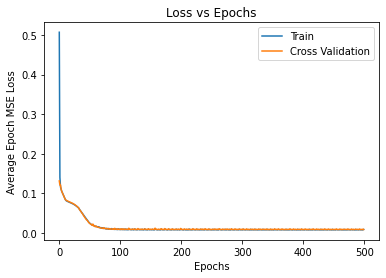

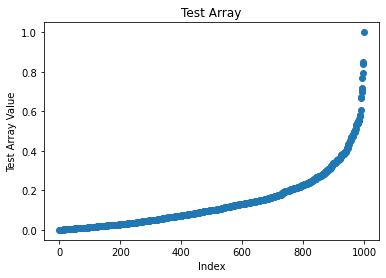

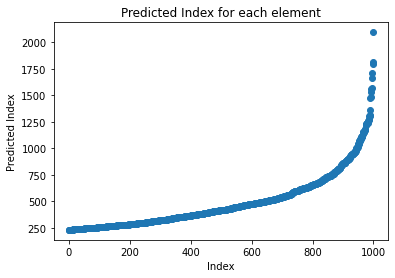

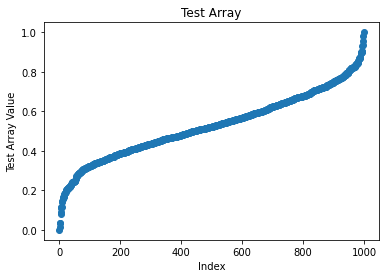

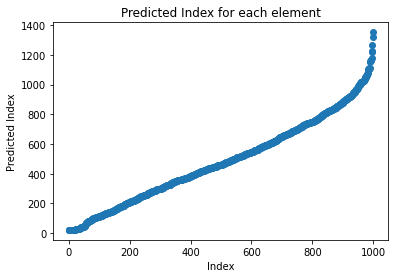

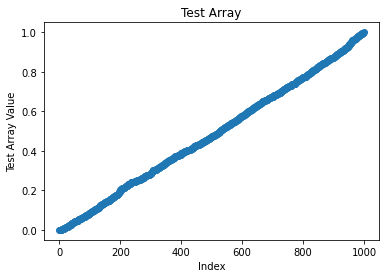

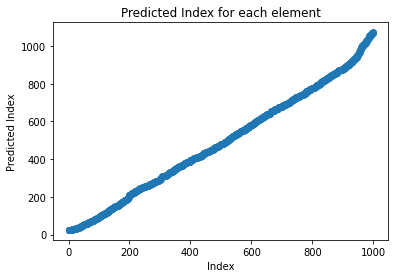

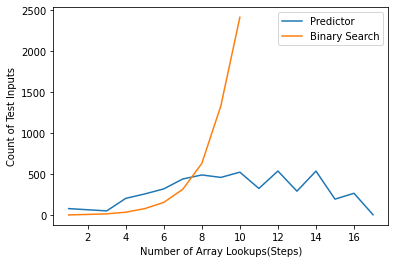

Average Number of Steps
Through Predictor:9.878
Through Binary Search:9.0004


In [57]:
net_1=Net_1HL()
net_1.to('cuda')

train_unif,train_ans1=generate_dataset(17000,n,_type='uniform')
cv_unif,cv_ans1=generate_dataset(1700,n,_type='uniform')

train_normal,train_ans2=generate_dataset(17000,n,_type='normal')
cv_normal,cv_ans2=generate_dataset(1700,n,_type='normal')

train_exponential,train_ans3=generate_dataset(16000,n,_type='exponential')
cv_exponential,cv_ans3=generate_dataset(1600,n,_type='exponential')

train_input=torch.cat((train_unif,train_normal,train_exponential))
train_ans=torch.cat((train_ans1,train_ans2,train_ans3))
cv_input=torch.cat((cv_unif,cv_normal,cv_exponential))
cv_ans=torch.cat((cv_ans1,cv_ans2,cv_ans3))

shuffled_idx=torch.randperm(train_input.shape[0])
train_input=train_input[shuffled_idx]
train_ans=train_ans[shuffled_idx]

shuffled_idx1=torch.randperm(cv_input.shape[0])
cv_input=cv_input[shuffled_idx1]
cv_ans=cv_ans[shuffled_idx1]

train_dataset(net_1,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=500,lr=1e-3)
test_single_array(net_1,n,'exponential')
test_single_array(net_1,n,'normal')
test_single_array(net_1,n,'uniform')

np.random.seed(42)
test_unif,test_ans1=generate_dataset(1700,n,_type='uniform')
test_normal,test_ans2=generate_dataset(1700,n,_type='normal')
test_exponential,test_ans3=generate_dataset(1600,n,_type='exponential')

test_input=torch.cat((test_unif,test_normal,test_exponential))

shuffled_idx=torch.randperm(test_input.shape[0])
test_input=test_input[shuffled_idx]

out=predict(net_1,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)


  1%|          | 4/500 [00:00<00:32, 15.31it/s]

0.16081839203834533
0.11386016011238098
0.10535350292921067
0.09935983344912529


  1%|▏         | 7/500 [00:00<00:26, 18.70it/s]

0.09463844746351242
0.09031167849898339
0.08654099628329277
0.08351894095540047
0.08134687319397926


  3%|▎         | 13/500 [00:00<00:22, 21.37it/s]

0.08000038266181946
0.07917817309498787
0.07854674383997917
0.07788161113858223
0.07720728069543839


  3%|▎         | 16/500 [00:00<00:26, 18.56it/s]

0.07650103196501731
0.07575322985649109
0.07497611120343209


  4%|▍         | 20/500 [00:01<00:28, 16.73it/s]

0.07414927706122398
0.07328081503510475
0.07236966043710709
0.07137362509965897


  5%|▌         | 26/500 [00:01<00:23, 20.01it/s]

0.07037370130419732
0.06928796917200089
0.06817745491862297
0.06695871204137802
0.06559064462780953


  6%|▌         | 29/500 [00:01<00:22, 21.03it/s]

0.06427683383226394
0.06292028836905957
0.06141384206712246
0.05971813537180424
0.05775448679924011


  7%|▋         | 35/500 [00:01<00:21, 21.97it/s]

0.05553625896573067
0.05321081466972828
0.051110217720270155
0.048935148119926455
0.04671369269490242


  8%|▊         | 41/500 [00:02<00:20, 22.28it/s]

0.044382980838418004
0.042010975256562236
0.04011573009192944
0.03782866336405277
0.03566494733095169


  9%|▉         | 44/500 [00:02<00:20, 22.55it/s]

0.03427455946803093
0.03155308291316032
0.02923348043113947
0.029283838532865047
0.027024838142096996


 10%|█         | 50/500 [00:02<00:19, 22.95it/s]

0.024199973233044146
0.024129483103752136
0.02292670253664255
0.020830143801867963
0.020553674176335336


 11%|█         | 56/500 [00:02<00:19, 22.84it/s]

0.02094385735690594
0.019089852832257746
0.017568433843553066
0.01750209778547287
0.01659467415884137


 12%|█▏        | 59/500 [00:02<00:19, 23.01it/s]

0.0159255507402122
0.015899316314607857
0.015507461223751306
0.01463882541283965
0.0140294817276299


 13%|█▎        | 65/500 [00:03<00:18, 22.92it/s]

0.013938663247972726
0.013762602861970664
0.01311763171106577
0.012437913659960031
0.012226181663572788


 14%|█▍        | 71/500 [00:03<00:18, 23.03it/s]

0.012244624365121127
0.011952399089932442
0.011401333101093768
0.011036370787769556
0.010995845776051283


 15%|█▍        | 74/500 [00:03<00:18, 23.00it/s]

0.010949938651174307
0.010713856760412454
0.010391678381711244
0.010101272910833358
0.009924804419279098


 16%|█▌        | 80/500 [00:03<00:18, 23.00it/s]

0.009844718500971794
0.009745366778224707
0.009572691936045884
0.009364650771021842
0.009202728979289532


 17%|█▋        | 86/500 [00:03<00:18, 22.87it/s]

0.009123755525797606
0.009026821795850992
0.008870988991111517
0.008704233542084694
0.008588834945112468


 18%|█▊        | 89/500 [00:04<00:17, 22.93it/s]

0.008537070639431477
0.008457171684131026
0.008343481086194515
0.008219450293108822
0.008105588471516966


 19%|█▉        | 95/500 [00:04<00:17, 22.99it/s]

0.008008940657600761
0.007925916276872159
0.007843551877886056
0.0077577134594321254
0.007675526663661003


 20%|██        | 101/500 [00:04<00:17, 22.98it/s]

0.0076016868930310014
0.007519306009635329
0.007437029760330916
0.00736031043343246
0.007290603453293442


 21%|██        | 104/500 [00:04<00:17, 23.01it/s]

0.007209354313090444
0.007127028470858931
0.0070513340178877115
0.006994379404932261
0.006948934216052294


 22%|██▏       | 110/500 [00:05<00:17, 22.89it/s]

0.0068986023310571905
0.006826693657785654
0.00674616782926023
0.006675312714651227
0.0066253400407731535


 23%|██▎       | 116/500 [00:05<00:16, 22.99it/s]

0.006586813740432263
0.006547449668869376
0.006499641947448254
0.006447064038366079
0.006394382659345865


 24%|██▍       | 119/500 [00:05<00:16, 22.93it/s]

0.006343886209651828
0.0062964286655187605
0.006252667075023055
0.006208370812237263
0.006165564246475697


 25%|██▌       | 125/500 [00:05<00:16, 22.99it/s]

0.006121231336146593
0.006075627449899912
0.006027259724214673
0.005976890586316586
0.005924131209030748


 26%|██▌       | 131/500 [00:05<00:16, 22.96it/s]

0.005868875980377197
0.005813517281785608
0.005765145923942327
0.0057326667476445435
0.00571223609149456


 27%|██▋       | 134/500 [00:06<00:15, 23.01it/s]

0.00569333010353148
0.005668343603610992
0.00563523881137371
0.005597285740077495
0.005558709893375635


 28%|██▊       | 140/500 [00:06<00:15, 22.98it/s]

0.0055227889213711025
0.005491024348884821
0.005460357293486595
0.005430846894159913
0.005395767604932189


 29%|██▉       | 146/500 [00:06<00:15, 23.13it/s]

0.005361534934490919
0.005323253897950053
0.005277415784075856
0.005228389613330364
0.005195863079279661


 30%|██▉       | 149/500 [00:06<00:15, 22.99it/s]

0.00516881481744349
0.005137874931097031
0.005101781105622649
0.005061003612354398
0.005020169215276838


 31%|███       | 155/500 [00:07<00:15, 22.94it/s]

0.004984277673065663
0.0049522722139954565
0.004923369036987424
0.00489220917224884
0.004850182682275772


 32%|███▏      | 161/500 [00:07<00:14, 23.07it/s]

0.004807036789134145
0.004774928046390414
0.004746365640312433
0.004712632903829217
0.0046815784648060795


 33%|███▎      | 164/500 [00:07<00:14, 23.01it/s]

0.004641243256628513
0.004600686859339476
0.0045571787748485805
0.004512800974771381
0.004476315667852759


 34%|███▍      | 170/500 [00:07<00:14, 23.22it/s]

0.004440244566649198
0.004405081132426858
0.004373974096961319
0.00434498421382159
0.00431595453992486


 35%|███▌      | 176/500 [00:07<00:14, 23.07it/s]

0.004283586493693292
0.004248266154900193
0.00421206618193537
0.004177736304700375
0.004144672304391861


 36%|███▌      | 179/500 [00:08<00:13, 22.94it/s]

0.004110257280990482
0.004076829785481096
0.004041308024898172
0.004005387099459768
0.003968863398768008


 37%|███▋      | 185/500 [00:08<00:13, 22.88it/s]

0.0039327062200754884
0.003897308558225632
0.003861563024111092
0.0038275965955108402
0.0037943803239613772


 38%|███▊      | 191/500 [00:08<00:13, 23.00it/s]

0.003761335974559188
0.0037283467827364802
0.00369563652202487
0.0036621085135266187
0.003628636314533651


 39%|███▉      | 194/500 [00:08<00:13, 22.97it/s]

0.003595356224104762
0.0035612105624750257
0.0035274438792839645
0.003493907768279314
0.0034594665048643947


 40%|████      | 200/500 [00:08<00:13, 23.05it/s]

0.0034256827319040896
0.0033921635476872325
0.003357514855451882
0.003323677182197571
0.003289805492386222


 41%|████      | 206/500 [00:09<00:12, 22.82it/s]

0.003255243063904345
0.0032210774486884476
0.0031868641497567298
0.0031535114627331494
0.0031193380476906897


 42%|████▏     | 209/500 [00:09<00:12, 22.82it/s]

0.0030855159042403103
0.003053786884993315
0.003022379521280527
0.002990838931873441
0.0029587705852463842


 43%|████▎     | 215/500 [00:09<00:12, 22.61it/s]

0.002924788207747042
0.002890320401638746
0.002856239373795688
0.0028221447486430407
0.002790235704742372


 44%|████▍     | 221/500 [00:09<00:12, 22.81it/s]

0.0027577186934649943
0.002724377065896988
0.002691091480664909
0.0026569707086309792
0.0026240307372063397


 45%|████▍     | 224/500 [00:10<00:12, 22.81it/s]

0.0025907132774591448
0.0025576269486919045
0.0025235286680981516
0.0024914622306823732
0.0024599797325208783


 46%|████▌     | 230/500 [00:10<00:11, 23.00it/s]

0.0024305365048348905
0.002401350694708526
0.0023727377876639364
0.0023437537718564274
0.0023149588610976934


 47%|████▋     | 236/500 [00:10<00:11, 22.96it/s]

0.002286306885071099
0.0022564394515939058
0.0022244402673095463
0.002189455134794116
0.0021514482912607493


 48%|████▊     | 239/500 [00:10<00:11, 22.79it/s]

0.002109681081492454
0.0020660815644077957
0.002014775515999645
0.001957624207716435
0.00189408891601488


 49%|████▉     | 245/500 [00:10<00:11, 22.97it/s]

0.0018259432050399481
0.0017575578996911645
0.0016971970908343792
0.0016501747071743012
0.0016200905898585915


 50%|█████     | 251/500 [00:11<00:10, 22.73it/s]

0.0015996466157957912
0.0015770241734571755
0.0015534818172454833
0.0015326228458434343
0.001510117668658495


 51%|█████     | 254/500 [00:11<00:10, 22.82it/s]

0.0014862814801745116
0.0014551380765624345
0.0014307082397863268
0.001433895726222545
0.0014723642263561488


 52%|█████▏    | 260/500 [00:11<00:10, 22.86it/s]

0.0015832692268304526
0.0015867550391703844
0.0015932203154079617
0.0015618494129739703
0.0016458666534163058


 53%|█████▎    | 266/500 [00:11<00:10, 22.99it/s]

0.0014454980962909758
0.001664866867940873
0.001342597312759608
0.001529637654311955
0.0017576289363205432


 54%|█████▍    | 269/500 [00:11<00:10, 22.81it/s]

0.0013530166819691659
0.0019015389611013235
0.0033775629010051487
0.0033375091734342277
0.0026187969837337733


 55%|█████▌    | 275/500 [00:12<00:09, 22.84it/s]

0.0020009174244478346
0.0017884333617985248
0.0015441221068613232
0.0014050865778699518
0.0013260058709420263


 56%|█████▌    | 281/500 [00:12<00:09, 22.85it/s]

0.0012547108228318394
0.0011915070819668472
0.0011320275720208884
0.0010757352982182055
0.0010286916804034263


 57%|█████▋    | 284/500 [00:12<00:09, 22.84it/s]

0.0009930864616762847
0.0009697701723780483
0.0009572793904226273
0.0009443862771149724
0.0009306734136771411


 58%|█████▊    | 290/500 [00:12<00:09, 22.86it/s]

0.0009191744378767907
0.0009073053312022239
0.0008966230903752148
0.0008872903999872506
0.0008818345959298313


 59%|█████▉    | 296/500 [00:13<00:08, 22.86it/s]

0.0008903183916117996
0.0009515229088719934
0.00104613074217923
0.0009567262721247971
0.0011112033505924046


 60%|█████▉    | 299/500 [00:13<00:08, 22.86it/s]

0.0010410839808173479
0.0009142870083451271
0.0014498272095806897
0.0014032828970812262
0.001350240223109722


 61%|██████    | 305/500 [00:13<00:08, 22.73it/s]

0.0008677406993228942
0.0008582038863096386
0.0008961356419604271
0.0009824088891036808
0.00096527140121907


 62%|██████▏   | 311/500 [00:13<00:08, 22.78it/s]

0.0008768511353991926
0.0011718249355908484
0.0007679554866626859
0.0007427377859130502
0.0012422132713254541


 63%|██████▎   | 314/500 [00:13<00:08, 22.81it/s]

0.0008854543615598231
0.0015085849212482572
0.002010113245341927
0.001265214552404359
0.0007857280259486287


 64%|██████▍   | 320/500 [00:14<00:07, 22.90it/s]

0.0007486425864044576
0.0007524972257670015
0.0007632139546331018
0.000705926405498758
0.0006285646988544614


 65%|██████▌   | 326/500 [00:14<00:07, 22.54it/s]

0.0007590348192024976
0.0013115521578583866
0.0013627584849018604
0.0014178757555782795
0.000986190204275772


 66%|██████▌   | 329/500 [00:14<00:07, 22.55it/s]

0.0009621009114198387
0.0008884257404133677
0.0009056821640115231
0.0008411847928073257
0.000866555777611211


 67%|██████▋   | 335/500 [00:14<00:07, 22.64it/s]

0.0008119450940284878
0.0008516281610354781
0.0008105810848064721
0.0008346448361407965
0.0007531577197369188


 68%|██████▊   | 341/500 [00:15<00:06, 22.79it/s]

0.0007184431655332446
0.0005650988954585045
0.0005524932057596743
0.0005937580077443272
0.0009175662184134125


 69%|██████▉   | 344/500 [00:15<00:06, 22.79it/s]

0.0005733925703680143
0.0005738140491303057
0.000866484543075785
0.0007580657140351832
0.0005154359270818532


 70%|███████   | 350/500 [00:15<00:06, 22.66it/s]

0.0005155326769454404
0.0017328133748378606
0.002262072789017111
0.0010367749026045203
0.0007057227718178183


 71%|███████   | 356/500 [00:15<00:06, 22.69it/s]

0.0005883329431526363
0.0006535859283758327
0.000642486845026724
0.0007381722680293024
0.0007212157186586409


 72%|███████▏  | 359/500 [00:15<00:06, 22.80it/s]

0.0007660559611395001
0.0006993832299485803
0.0007204713998362422
0.0006466606457252056
0.0006433058035327122


 73%|███████▎  | 365/500 [00:16<00:05, 22.83it/s]

0.0005210934032220393
0.0004558370303129777
0.0006397696677595377
0.000648296158760786
0.00045554839016404003


 74%|███████▍  | 371/500 [00:16<00:05, 22.91it/s]

0.0008283751783892512
0.0005451815755805001
0.000851256342139095
0.001060750868055038
0.001414225553162396


 75%|███████▍  | 374/500 [00:16<00:05, 22.85it/s]

0.0010397406469564885
0.0005657219007844105
0.00042483831639401616
0.0004328020528191701
0.0004036384809296578


 76%|███████▌  | 380/500 [00:16<00:05, 22.60it/s]

0.00038776115979999304
0.0003870371438097209
0.000706521951360628
0.0007559619698440656
0.0005102556111523882


 77%|███████▋  | 386/500 [00:17<00:04, 22.87it/s]

0.0005509561218786984
0.0003798954334342852
0.0007955461012898013
0.0004554461716907099
0.0003694751881994307


 78%|███████▊  | 389/500 [00:17<00:04, 22.74it/s]

0.000588322797557339
0.0011697097739670425
0.0027716550626792013
0.0022919837647350505
0.0019547300296835603


 79%|███████▉  | 395/500 [00:17<00:04, 22.84it/s]

0.0011978429974988103
0.0007380987401120365
0.0005283071368467063
0.00043287293228786437
0.0003813607560005039


 80%|████████  | 401/500 [00:17<00:04, 22.73it/s]

0.00035140218678861854
0.00033828976156655697
0.0003327572048874572
0.0003289044980192557
0.000325970453559421


 81%|████████  | 404/500 [00:17<00:04, 22.78it/s]

0.00032339566969312726
0.0003213680349290371
0.00031946696108207104
0.0003174053563270718
0.00031580640352331103


 82%|████████▏ | 410/500 [00:18<00:03, 22.83it/s]

0.00031391149386763575
0.0003129877208266407
0.0003134309692541137
0.0003230667440220714
0.0004203345073619857


 83%|████████▎ | 416/500 [00:18<00:03, 22.92it/s]

0.000766978831961751
0.0005450549302622676
0.0004453070054296404
0.0006920551182702184
0.0007850102236261591


 84%|████████▍ | 419/500 [00:18<00:03, 22.78it/s]

0.0010813897824846208
0.0013766572432359681
0.0005894141097087414
0.00034073464921675624
0.0003092258528340608


 85%|████████▌ | 425/500 [00:18<00:03, 22.70it/s]

0.00031847800710238516
0.00029643666930496694
0.0002890112838940695
0.000309151312103495
0.00039267468673642725


 86%|████████▌ | 431/500 [00:19<00:03, 22.73it/s]

0.0007009088934864849
0.0003723436559084803
0.000540983458631672
0.000349495469708927
0.00031060668698046356


 87%|████████▋ | 434/500 [00:19<00:02, 22.82it/s]

0.0006569851509993895
0.0007232643314637244
0.0009128090896410868
0.0018720355961704626
0.001125282866996713


 88%|████████▊ | 440/500 [00:19<00:02, 22.84it/s]

0.00039869532629381864
0.00033515263930894434
0.0003282747755292803
0.0002989641739986837
0.00029928789299447087


 89%|████████▉ | 446/500 [00:19<00:02, 22.65it/s]

0.00027171265974175186
0.00026251824747305366
0.00026808067632373423
0.0004813387145986781
0.0006136338924989104


 90%|████████▉ | 449/500 [00:19<00:02, 22.62it/s]

0.000306883140001446
0.0004654161893995479
0.00042542867304291577
0.0003634374792454764
0.0005658834706991911


 91%|█████████ | 455/500 [00:20<00:01, 22.68it/s]

0.0005429041309980675
0.00026068151637446133
0.0004159334552241489
0.0011651519656879828
0.002211898355744779


 92%|█████████▏| 461/500 [00:20<00:01, 22.72it/s]

0.0008820387884043157
0.00048790003929752854
0.00033807228464866057
0.00025984800304286183
0.0002492433734005317


 93%|█████████▎| 464/500 [00:20<00:01, 22.78it/s]

0.0002423390149488114
0.00024347835133085028
0.0002478966227499768
0.00025584340473869813
0.00044283018505666407


 94%|█████████▍| 470/500 [00:20<00:01, 22.72it/s]

0.00058340513787698
0.00039726423128740864
0.0003262429221649654
0.00040868883079383524
0.0005665253265760839


 95%|█████████▌| 476/500 [00:21<00:01, 22.77it/s]

0.0002871374599635601
0.00048784233804326503
0.0003521179169183597
0.00024690399586688725
0.00026513389020692556


 96%|█████████▌| 479/500 [00:21<00:00, 22.65it/s]

0.0009736836451338604
0.0006962253435631282
0.0007539021375123411
0.0009019582270411774
0.0008281956950668245


 97%|█████████▋| 485/500 [00:21<00:00, 22.84it/s]

0.0009454360813833773
0.0007381529430858791
0.00033740359940566124
0.00029082371620461347
0.000252860329055693


 98%|█████████▊| 491/500 [00:21<00:00, 22.65it/s]

0.00023717839794699103
0.00022344222088577226
0.0002329486218513921
0.00021670799615094438
0.00021424253209261223


 99%|█████████▉| 494/500 [00:21<00:00, 22.59it/s]

0.00025772304506972433
0.000681253318907693
0.00042308820120524616
0.00033485208841739223
0.0005128519376739859


100%|██████████| 500/500 [00:22<00:00, 22.59it/s]

0.00026605404127622023
0.00038593348290305585
0.0003470083553111181
0.0003511486283969134


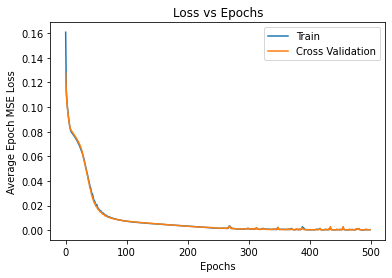

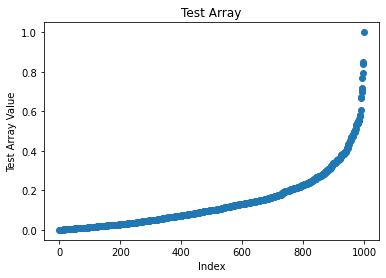

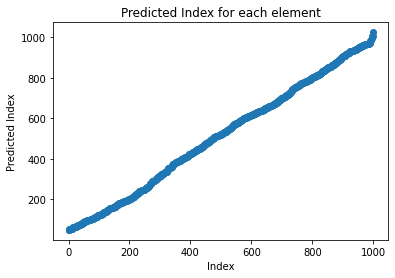

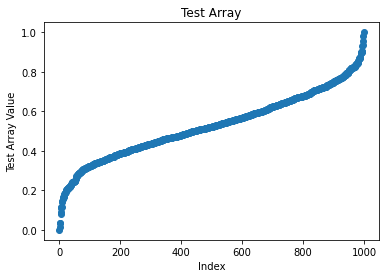

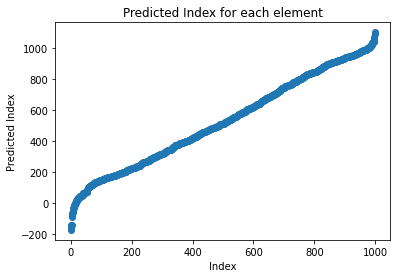

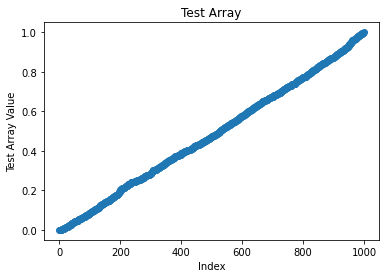

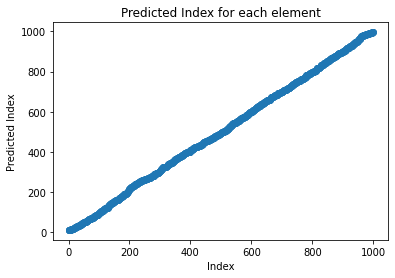

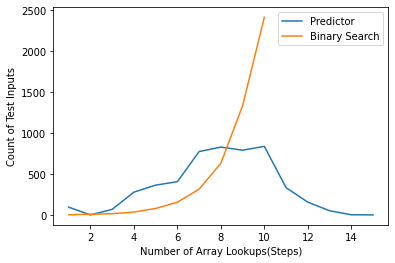

Average Number of Steps
Through Predictor:7.9124
Through Binary Search:9.0004


In [59]:
net_2=Net_2HL()
net_2.to('cuda')

train_unif,train_ans1=generate_dataset(17000,n,_type='uniform')
cv_unif,cv_ans1=generate_dataset(1700,n,_type='uniform')

train_normal,train_ans2=generate_dataset(17000,n,_type='normal')
cv_normal,cv_ans2=generate_dataset(1700,n,_type='normal')

train_exponential,train_ans3=generate_dataset(16000,n,_type='exponential')
cv_exponential,cv_ans3=generate_dataset(1600,n,_type='exponential')

train_input=torch.cat((train_unif,train_normal,train_exponential))
train_ans=torch.cat((train_ans1,train_ans2,train_ans3))
cv_input=torch.cat((cv_unif,cv_normal,cv_exponential))
cv_ans=torch.cat((cv_ans1,cv_ans2,cv_ans3))

shuffled_idx=torch.randperm(train_input.shape[0])
train_input=train_input[shuffled_idx]
train_ans=train_ans[shuffled_idx]

shuffled_idx1=torch.randperm(cv_input.shape[0])
cv_input=cv_input[shuffled_idx1]
cv_ans=cv_ans[shuffled_idx1]

train_dataset(net_2,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=500,lr=1e-4)
test_single_array(net_2,n,'exponential')
test_single_array(net_2,n,'normal')
test_single_array(net_2,n,'uniform')

np.random.seed(42)
test_unif,test_ans1=generate_dataset(1700,n,_type='uniform')
test_normal,test_ans2=generate_dataset(1700,n,_type='normal')
test_exponential,test_ans3=generate_dataset(1600,n,_type='exponential')

test_input=torch.cat((test_unif,test_normal,test_exponential))

shuffled_idx=torch.randperm(test_input.shape[0])
test_input=test_input[shuffled_idx]

out=predict(net_2,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)
